In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr

warnings.filterwarnings('ignore')
font = {'weight' : 'bold',
        'size'   : 22}
matplotlib.rc('font', **font)
pd.options.display.max_rows = 120

path = '/home/sareeves/final/predictions'

def stack_frames(dbf):
    db_stack = dbf.copy(deep=True)
    df = db_stack.melt(var_name='pred_col', value_name='value', value_vars=db_stack.columns, ignore_index=False)
    df = df.reset_index()
    df.loc[df['pred_col'].str.contains('dir'), 'direction'] = 'dir'
    df.loc[df['pred_col'].str.contains('inv'), 'direction'] = 'inv'
    assert len(df.loc[df['pred_col'].str.contains('dir') & df['pred_col'].str.contains('inv')]) == 0
    df = df.set_index(['direction', 'uid'])  # Assuming 'index' is the name of uid column
    df['pred_col'] = df['pred_col'].str.replace('_dir', '')
    df['pred_col'] = df['pred_col'].str.replace('_inv', '')
    dbf = df.pivot_table(index=['direction', 'uid'], columns='pred_col', values='value')
    return dbf

def extract_decimal_number(text):
    # Define a regular expression to match decimal numbers
    decimal_regex = r"\d+\.\d+"
    
    # Search for the decimal number in the text using the regular expression
    match = re.search(decimal_regex, text)
    
    # If a match is found, return the float value of the matched string
    if match:
        return float(match.group())
    
    # If no match is found, return NaN
    return np.nan

db = pd.read_csv(os.path.join(path, '..', 's669_mapped_preds_korpm.csv'))

db['uid2'] = db['code'] + '_' + (db['position'].astype(int) - db['offset_up'].astype(int)).astype(str) + db['mutation'].str[-1]
db = db.set_index(['uid', 'uid2'])

cols = db.columns
drop = [col for col in db.columns if 'Unnamed' in col]
drop += [col for col in db.columns if 'pdb' in col]
drop += [col for col in db.columns if 'offset' in col]

db_full = db.copy(deep=True)
db_full['uid3'] = db['code'] + '_' + db['PDB_Mut'].str[1:]
db_full = db_full.reset_index().set_index('uid3')

s461 = pd.read_csv(os.path.join(path, '..', 'S461.csv'))
s461['uid3'] = s461['PDB'] + '_' + s461['MUT_D'].str[2:]
s461 = s461.set_index('uid3')
s461['ddG_I'] = -s461['ddG_D']

s461.columns = [s+'_dir' for s in s461.columns]
s461 = s461.rename({'ddG_D_dir': 'ddG_dir', 'ddG_I_dir': 'ddG_inv'}, axis=1)


db = s461.join(db_full, how='left').reset_index(drop=True).set_index(['uid', 'uid2'])
db.to_csv(os.path.join(path, '..', 'S461_joined.csv'))
db = db.drop(drop, axis=1)
db = db.drop(['PDB_dir', 'MUT_D_dir'], axis=1)

cols = db.columns

#db['msa_transformer_mean_dir'] = db[[f'msa_{i}' for i in range(1,6)]].mean(axis=1)

incl = [col for col in db.columns if ('_dir' in col) or ('_inv' in col)]
db_preds = db[incl].drop(['DDG_checked_dir', 'SEC_STR_dir', 'DDG_checked_inv', 'SEC_STR_inv', 'ddG_dir', 'ddG_inv'], axis=1)
db_preds = db_preds.drop([col for col in db_preds.columns if 'runtime_' in col], axis=1).drop_duplicates()
#db_preds = db_preds.drop(['mif_inv', 'mifst_inv', 'mpnn_inv', 'esmif_monomer_inv'], axis=1)

db_feats = db[['code', 'multimer', 'TEMP', 'pH', 'SEC_STR_dir', 'SOL_ACC_dir']]
ddgs = db[['code', 'ddG_dir', 'ddG_inv']] #.rename({'DDG_checked_dir': 'ddG'}, axis=1)

db_runtimes = db[[col for col in db.columns if 'runtime' in col]].drop_duplicates()

db_preds['esm1v_median_inv'] = -db_preds['esm1v_median_dir']
db_preds['esm1v_mean_inv'] = -db_preds['esm1v_mean_dir']
db_preds['msa_transformer_median_inv'] = -db_preds['msa_transformer_median_dir']
db_preds['msa_transformer_mean_inv'] = -db_preds['msa_transformer_mean_dir']
db_preds['tranception_red_inv'] = -db_preds['tranception_red_dir']

db_preds['mpnn_mean_dir'] = db_preds[['mpnn_10_00_dir', 'mpnn_20_00_dir', 'mpnn_30_00_dir']].mean(axis=1) 
db_runtimes['runtime_mpnn_mean_dir'] = db_runtimes[['runtime_mpnn_10_00_dir', 'runtime_mpnn_20_00_dir', 'runtime_mpnn_30_00_dir']].sum(axis=1)
db_preds['mpnn_mean_inv'] = db_preds[['mpnn_10_00_inv', 'mpnn_20_00_inv', 'mpnn_30_00_inv']].mean(axis=1) #'mpnn_10_00_dir', 
db_runtimes['runtime_mpnn_mean_inv'] = db_runtimes[['runtime_mpnn_10_00_inv', 'runtime_mpnn_20_00_inv', 'runtime_mpnn_30_00_inv']].sum(axis=1)

db_preds['mpnn_20_mean_dir'] = db_preds[[f'mpnn_20_00{i}_dir' for i in range(1,6)]].mean(axis=1)
db_preds = db_preds.drop([f'mpnn_20_00{i}_dir' for i in range(1,6)], axis=1)
db_runtimes['runtime_mpnn_20_mean_dir'] = db_runtimes[[f'runtime_mpnn_20_00{i}_dir' for i in range(1,6)]].mean(axis=1)
db_runtimes = db_runtimes.drop([f'runtime_mpnn_20_00{i}_dir' for i in range(1,6)], axis=1)

db_preds['mpnn_30_noise_dir'] = db_preds[[f'mpnn_30_{"0"+str(i) if i != 30 else "03"}_dir' for i in range(28,33)]].mean(axis=1)
db_preds = db_preds.drop([f'mpnn_30_{"0"+str(i) if i != 30 else "03"}_dir' for i in range(28,30)], axis=1)
db_preds = db_preds.drop([f'mpnn_30_{"0"+str(i) if i != 30 else "03"}_dir' for i in range(31,33)], axis=1)
db_runtimes['runtime_mpnn_30_noise_dir'] = db_runtimes[[f'runtime_mpnn_30_{"0"+str(i) if i != 30 else "03"}_dir' for i in range(28,33)]].mean(axis=1)
db_runtimes = db_runtimes.drop([f'runtime_mpnn_30_{"0"+str(i) if i != 30 else "03"}_dir' for i in range(28,30)], axis=1)
db_runtimes = db_runtimes.drop([f'runtime_mpnn_30_{"0"+str(i) if i != 30 else "03"}_dir' for i in range(31,33)], axis=1)

#db_preds['mpnn_30_mean_dir'] = db_preds[['mpnn_30_029_dir', 'mpnn_30_03_dir', 'mpnn_30_031_dir']].mean(axis=1) #'mpnn_10_00_dir', 
#db_runtimes['runtime_mpnn_30_mean_dir'] = db_runtimes[['runtime_mpnn_30_029_dir', 'runtime_mpnn_30_03_dir', 'runtime_mpnn_30_031_dir']].sum(axis=1)
#db_preds['mpnn_30_mean_inv'] = db_preds[['mpnn_30_029_inv', 'mpnn_30_03_inv', 'mpnn_30_031_inv']].mean(axis=1) #'mpnn_10_00_dir', 
#db_runtimes['runtime_mpnn_30_mean_inv'] = db_runtimes[['runtime_mpnn_30_029_inv', 'runtime_mpnn_30_03_inv', 'runtime_mpnn_30_031_inv']].sum(axis=1)

db_preds = db_preds.reset_index(level=1)
db_preds = db_preds.drop('ppl_esmif_multimer_full_masked_dir', axis=1)
db_preds['esmif_multimer_full_masked_dir']

uid
1A0F_11A    -0.061322
1BA3_457D   -0.004358
1BA3_485D    0.002357
1BA3_485K    0.003621
1BA3_485M   -0.006085
               ...   
4HE7_19G    -0.017793
4HE7_19K    -0.004815
5JXB_25G    -0.010242
5JXB_25P    -0.013142
5OAQ_199H   -0.039911
Name: esmif_multimer_full_masked_dir, Length: 461, dtype: float64

In [227]:
remap_names = {'esmif_monomer': 'ESM-IF(HM)', 'esmif_monomer_full': 'ESM-IF(M)', 'esmif_multimer_full': 'ESM-IF', 'esmif_multimer': 'ESM-IF(H)', 
        'esmif_multimer_full_masked': 'ESM-IF(masked)', 'ddG': 'ΔΔG',
        'mpnn_mean': 'ProteinMPNN_mean', 'msa_transformer_mean': 'MSA-T_mean', 'tranception_red': 'Tranception', 'esm1v_mean': 'ESM-1V_mean',
        'mif': 'MIF', 'mifst': 'MIF-ST', 'monomer_ddg': 'Ros_ddG_monomer', 'cartesian_ddg': 'Rosetta_CartDDG', 'mpnn_20_mean': 'ProteinMPNN_20_mean',
        'mpnn_10_00': 'ProteinMPNN_10', 'mpnn_20_00': 'ProteinMPNN_20', 'mpnn_30_00': 'ProteinMPNN_30', 'mpnn_30_noise': 'ProteinMPNN_30_noise',
         'esm1v_2': 'ESM-1V_2', 'msa_transformer_1': 'MSA-T_1', 'korpm': 'KORPM', 'msa_transformer_median': 'MSA-T_median','random': 'Gaussian noise'}

remap_names_2 = {f"{key}_dir": value for key, value in remap_names.items()}
remap_names_2.update({'ddG_dir': 'ΔΔG label', 'dTm_dir': 'ΔTm label', 'cartesian_ddg_dir': 'Rosetta_CartDDG'})

In [3]:
db_preds.loc[db_preds['korpm_dir'].isna()].head()

uid2  KORPMD_dir  CartddgD_dir  FoldXD_dir  EvoD_dir  \
uid                                                                    
1R2Y_243E  1R2Y_243E      -1.721         -2.85       -2.59     -2.02   

           Dyna2D_dir  PopMsD_dir  DDGunD_dir  TNetD_dir  ACDCNND_dir  ...  \
uid                                                                    ...   
1R2Y_243E      -0.077       -0.86        -1.5      0.101       -0.608  ...   

           korpm_inv  esm1v_median_inv  esm1v_mean_inv  \
uid                                                      
1R2Y_243E      1.448          5.753062        6.294906   

           msa_transformer_median_inv  msa_transformer_mean_inv  \
uid                                                               
1R2Y_243E                    6.103989                  5.892816   

           tranception_red_inv  mpnn_mean_dir  mpnn_mean_inv  \
uid                                                            
1R2Y_243E             0.019696       -3.03854       2.828177   

           mpnn_20_mean_dir  mpnn_30_noise_dir  
uid                                             
1R2Y_243E         -2.848037          -2.577188  

[1 rows x 86 columns]

In [4]:
def parse_cartesian(filename, reduce='mean'):
    # read the file into a dataframe
    df = pd.read_csv(filename, delim_whitespace=True, header=None)
    # take the average of the fourth field for the first 3 lines
    if reduce == 'mean':
        means = df.groupby(2).mean()
    elif reduce == 'min':
        means = df.groupby(2).min()
    wt_mean = means.loc['WT:', 3]
    mut_mean = means.drop('WT:')[3].item()
    return float(wt_mean - mut_mean)

def parse_monomer(filename):
    df = pd.read_csv(filename, delim_whitespace=True, header=None)
    return -float(df.at[1, 2])

def parse_predictions(df, root_name, inverse=False, reduce='mean', kind='cartesian'):
    df_rosetta = pd.DataFrame(columns=[f"cartesian_ddg{'_inv' if inverse else '_dir'}"] if kind=='cartesian' else [f"monomer_ddg{'_inv' if inverse else '_dir'}"])
    for (code, chain), group in df.reset_index(level=0).groupby(['code', 'chain']):
        complete = 0
        new_path = os.path.join(root_name, f'{code}_{chain}')
        for subfolder, _ in group.groupby('uid'):
            if kind=='monomer':
                subfolder += '_monomer'

            pred_path = os.path.join(new_path, subfolder)
            
            if inverse:
                pred_path = os.path.join(pred_path, 'inv_robetta')

            got_file = False
            for file in os.listdir(pred_path):
                if '.ddg' in file and kind == 'cartesian':
                    complete += 1
                    df_rosetta.at[subfolder, f"cartesian_ddg{'_inv' if inverse else '_dir'}"] = parse_cartesian(os.path.join(pred_path, file), reduce=reduce)
                    got_file = True
                elif '.out' in file and kind == 'monomer':
                    complete += 1
                    df_rosetta.at[subfolder.replace('_monomer', ''), f"monomer_ddg{'_inv' if inverse else '_dir'}"] = parse_monomer(os.path.join(pred_path, file))
                    got_file = True
                if 'runtime' in file:
                    db_runtimes.at[subfolder.replace('_monomer', ''), f"runtime_cartesian_ddg{'_inv' if inverse else '_dir'}"] = int(open(os.path.join(pred_path, file), 'r').read().strip())
            if not got_file:
                print('missing scores for', subfolder)
        if complete < 1:
            print('No scores found in', code)
    return df_rosetta


#print('getting monomer predictions')
#df_monomer = parse_predictions(db, path, kind='monomer')
#db_preds = db_preds.join(df_monomer.astype(float), how='left')

print('getting cartesian predictions')
df_cart = parse_predictions(db, path)
db_preds = db_preds.join(df_cart.astype(float), how='left')

#print('getting monomer inverse predictions')
#df_monomer_inv = parse_predictions(db, path, kind='monomer', inverse=True)
#db_preds = db_preds.reset_index(level=1)
#db_preds = db_preds.join(df_monomer_inv.astype(float), how='left')

print('getting cartesian inverse predictions')
df_cart_inv = parse_predictions(db, path, inverse=True)
db_preds = db_preds.join(df_cart_inv.astype(float), how='left')

db_preds = db_preds.reset_index().set_index(['uid', 'uid2'])

getting cartesian predictions
getting cartesian inverse predictions


In [5]:
db_preds.corr().to_csv(os.path.join(path, '..', 'S461_corrs.csv'))
db_preds.to_csv(os.path.join(path, '..', 's461_preds.csv'))

                     korpm_dir  korpm_inv
uid       uid2                           
1A0F_11A  1A0F_11A       0.143     -0.268
1BA3_457D 1BA3_461D     -1.054      0.857
1BA3_485D 1BA3_489D      0.265      0.076
1BA3_485K 1BA3_489K      0.390     -0.127
1BA3_485M 1BA3_489M     -0.209      1.205
...                        ...        ...
4HE7_19G  4HE7_19G      -0.238      0.146
4HE7_19K  4HE7_19K      -0.064      0.127
5JXB_25G  5JXB_332G     -0.413     -0.109
5JXB_25P  5JXB_332P     -0.923      0.008
5OAQ_199H 5OAQ_429H     -2.722      1.419

[461 rows x 2 columns]
antisymmetry (should be close to -1) -0.830520153928844
bias (should be close to 0) -0.029642391304347825


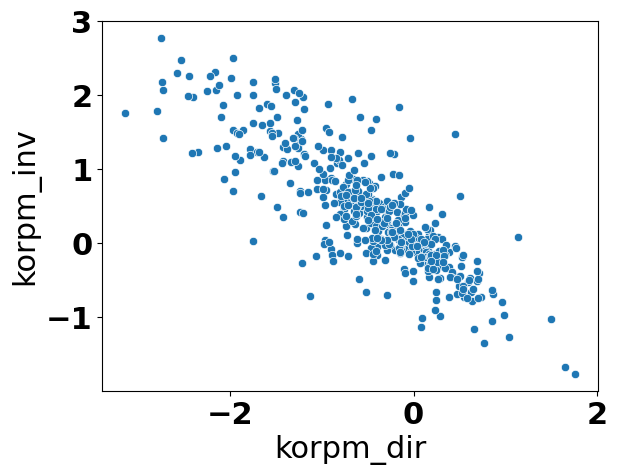

In [6]:
c1 = 'korpm_dir'
c2 = 'korpm_inv'

def antisymmetry(fwd, rvs):
    try:
        arr = pd.concat([fwd, rvs], axis=1).dropna()
    except:
        print(fwd)
        print(rvs)
    #if len(arr) != 669:
        #print(len(arr))
    cov = np.cov(arr.T)
    std1 = fwd.dropna().std()
    std2 = rvs.dropna().std()
    return (cov/(std1*std2))[0,1]

def bias(fwd, rvs):
    arr = pd.concat([fwd, rvs], axis=1).dropna()
    #if len(arr) != 669:
        #print(len(arr))
    s = arr.sum(axis=1)
    s2 = s.sum()
    return s2 / (2*len(arr))

db_tmp = db_preds.copy()
print(db_tmp[[c1, c2]])
#db_tmp['code'] = db_tmp.reset_index(level=1).index.str[:4]
#db_tmp = db_tmp.loc[db_tmp['code']=='1A7V']
sns.scatterplot(data=db_tmp, x=c1, y=c2, legend=False)

print('antisymmetry (should be close to -1)', antisymmetry(db_preds[c1], db_preds[c2]))
print('bias (should be close to 0)', bias(db_preds[c1], db_preds[c2]))

In [7]:
db_complete = db_preds.copy(deep=True).reset_index()
db_complete = db_complete.set_index('uid')

neff = pd.read_csv(os.path.join(path, '..', 'neff.csv'), header=None).set_index(0)
neff.index.name = 'code'
neff.columns = ['neff']

db_feats_2 = pd.read_csv(os.path.join(path, '..', 's669_mapped_feats.csv'))
db_feats_2['uid'] = db_feats_2['code'] + '_' + db_feats_2['position'].astype(str) + db_feats_2['mutation']
db_feats_2 = db_feats_2[['uid', 'wild_type', 'on_interface', 'entropy', 'conservation', 'column_completeness', 'completeness_score', 'n_seqs', 'structure_length', 'multimer', 'SS',
                        'features', 'hbonds', 'saltbrs', 'b_factor', 'residue_depth', 'kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'rel_ASA', 'nmr_xray', 'pH', 'resolution']]

db_feats_2['on_interface'] = db_feats_2['on_interface'].astype(int)
db_feats_2['features'] = db_feats_2['features'].fillna("")#.apply(list)
db_complete = db_complete.join(ddgs)
db_complete = db_complete.join(db_feats_2.set_index('uid')).drop('code', axis=1).drop('uid2', axis=1).reset_index().drop('uid2', axis=1).set_index('uid')
db_complete['delta_kdh'] = db_complete['kdh_mut'] - db_complete['kdh_wt']
db_complete['delta_vol'] = db_complete['vol_mut'] - db_complete['vol_wt']
db_complete['delta_chg'] = db_complete['chg_mut'] - db_complete['chg_wt']
db_complete['delta_asa'] = db_complete['SOL_ACC_inv'] - db_complete['SOL_ACC_dir']
db_complete['to_proline'] = (db_complete.index.str[-1] == 'P').astype(int)
db_complete['to_glycine'] = (db_complete.index.str[-1] == 'G').astype(int)
db_complete['from_proline'] = db_complete['wild_type'] == 'P'
db_complete['from_glycine'] = db_complete['wild_type'] == 'G'
db_complete['helix'] = db_complete['SS'] == 'H'
db_complete['bend'] = db_complete['SS'] == 'S'
db_complete['turn'] = db_complete['SS'] == 'T'
db_complete['coil'] = db_complete['SS'] == '-'
db_complete['strand'] = db_complete['SS'] == 'E'
db_complete['xray_else_NMR'] = db_complete['nmr_xray'].str.contains('X-RAY')
db_complete['active_site'] = db_complete['features'].str.contains('ACT_SITE')
db_complete['resolution'] = db_complete['resolution'].fillna('').apply(lambda x: extract_decimal_number(x))
#db_complete['mpnn_median_dir'] = db_complete[['mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir']].mean(axis=1)
db_complete = db_complete.drop(['kdh_wt', 'kdh_mut', 'vol_wt', 'vol_mut', 'chg_wt', 'chg_mut', 'features', 'SS', 'wild_type', 'nmr_xray'], axis=1)
# 'mpnn_20_021_dir', 'mpnn_20_022_dir', 'mpnn_20_019_dir', 'mpnn_10_dir', 'mpnn_30_dir', 'mpnn_30_03_dir', 'mpnn_20_02_dir',
db_complete['code'] = db_complete.index.str[:4]
db_complete = db_complete.reset_index().merge(neff['neff'].dropna(), on='code', how='left')#.drop('code', axis=1)#.set_index('uid')
db_complete['neff'] = db_complete['neff'].fillna(0)
unique_indices = db_complete.groupby('uid')['neff'].idxmax()#.astype(int)
db_complete = db_complete.loc[unique_indices].set_index('uid')

db_complete['random_dir'] = np.random.rand(len(db_complete)) - 0.5
db_complete['random_inv'] = np.random.rand(len(db_complete)) - 0.5

# follow sign convention for DDG of unfolding (higher is less stable)
#db_complete['DDG_checked_dir'] *= -1
#db_complete['DDG_checked_inv'] *= -1

In [8]:
def compute_ndcg(dbf, pred_col, true_col):
    # Shift scores to be non-negative
    df = dbf.copy(deep=True)
    #min_score = min(df[true_col].min(), df[pred_col].min())
    min_score = df[true_col].min()
    shift = 0
    if min_score < 0:
        shift = -min_score

    df[true_col] += shift
    #df[pred_col] += shift
    
    # Sort dataframe by ground truth labels
    df_sorted = df.sort_values(by=pred_col, ascending=False)
    
    # Get the sorted predictions
    sorted_preds = df_sorted[pred_col].values
    
    # Compute the relevance scores. In this case, we'll just use the ground truth labels.
    # You might want to modify this if your relevance scores are not the same as your labels.
    relevance = df_sorted[true_col].values
    
    # Reshape data as ndcg_score expects a 2D array
    sorted_preds = sorted_preds.reshape(1, -1)
    relevance = relevance.reshape(1, -1)
    
    # Compute and return NDCG
    return metrics.ndcg_score(relevance, sorted_preds)

In [23]:
def classifications(db_gt_preds, split_col=None, split_val=None, split_col_2=None, split_val_2=None, stats=(), directions=('dir', 'inv'), stacked=False):

    '''Summarizes the response of all models on one or two feature splits'''

    db_discrete = db_gt_preds.copy(deep=True)
    
    #if split_col is not None:
    #    print(db_discrete[db_discrete[split_col].isna()])

    if split_col_2 is None and split_val_2 is not None:
        split_col_2 = split_col
    if split_col is not None:
        db_discrete = db_discrete.copy(deep=True).dropna(subset=[split_col])
    if split_col_2 is not None and split_col_2 != split_col:
        db_discrete = db_discrete.copy().dropna(subset=[split_col_2])

    if (split_col is None) or (split_val is None):
        split_col = 'tmp'
        split_val = 0
    if (split_col_2 is None) or (split_val_2 is None):
        split_col_2 = 'tmp2'
        split_val_2 = 0

    db_discrete = db_discrete.astype(float)
    #f ddG{("_"+direction) if not stacked else ""} gets flipped by convention, such that positivef ddG{("_"+direction) if not stacked else ""} means destabilizing
    #db_discrete[f'ddG{("_"+direction) if not stacked else ""}'] = -db_discrete[f'ddG{("_"+direction) if not stacked else ""}']
    
    if not stacked:
        # binarize thef ddG{("_"+direction) if not stacked else ""} column: above 0 (or equal to) means destabilized (0), below means stabilized
        db_discrete.loc[db_discrete['ddG_dir'] > 0, 'ddG_dir'] = 1
        db_discrete.loc[db_discrete['ddG_dir'] < 0, 'ddG_dir'] = 0
        db_discrete.loc[db_discrete['ddG_inv'] > 0, 'ddG_inv'] = 1
        db_discrete.loc[db_discrete['ddG_inv'] < 0, 'ddG_inv'] = 0     
    else:
        db_discrete.loc[db_discrete['ddG'] > 0, 'ddG'] = 1
        db_discrete.loc[db_discrete['ddG'] < 0, 'ddG'] = 0

    cols = db_discrete.columns #.drop([f'ddG{("_"+direction) if not stacked else ""}'])
    
    db_complete_bin = db_discrete.copy(deep=True)

    # binarize all columns (needed for about half of the statistics to be calculated)
    if split_col != 'tmp':
        db_complete_bin = db_discrete.copy(deep=True).dropna(subset=[split_col]).drop(split_col, axis=1).astype(float)
    if split_col_2 != 'tmp2' and split_col_2 != split_col:
        db_complete_bin = db_complete_bin.dropna(subset=[split_col_2]).drop(split_col_2, axis=1).astype(float)

    # more likely means predicted stabilized
    db_complete_bin[db_complete_bin > 0] = 1
    db_complete_bin[db_complete_bin < 0] = 0

    if split_col != 'tmp':
        db_complete_bin = db_complete_bin.join(db_discrete[[split_col]])
    if split_col_2 != 'tmp2':
        db_complete_bin = db_complete_bin.join(db_discrete[[split_col_2]])

    # avoid grouping columns at all
    if split_col == 'tmp' and split_col_2 == 'tmp2':
        split = ['']
    # only one type of column, so just want higher or lower than value
    elif split_col_2 == 'tmp2':
        split = [f'{split_col} > {split_val}', f'{split_col} <= {split_val}']
    # if we specify two of the same split column we are assuming there are two different threshold values
    elif split_col == split_col_2:
        split = [f'{split_col} > {split_val}', f'{split_val} >= {split_col} > {split_val_2}', f'{split_col} <= {split_val_2}']
    # if we specify two different splits we need all permutations
    else:
        split = [f'{split_col} > {split_val} & {split_col_2} > {split_val_2}', 
                 f'{split_col} <= {split_val} & {split_col_2} > {split_val_2}',
                 f'{split_col} > {split_val} & {split_col_2} <= {split_val_2}',
                 f'{split_col} <= {split_val} & {split_col_2} <= {split_val_2}']

    # create a multi-index such that each row looks like ('dir','mpnn_dir'): statistics
    idx = pd.MultiIndex.from_product([['dir', 'inv', 'combined'], split, cols])
    df_out = pd.DataFrame(index=idx)
    for direction in directions: 
        for sp in split:
            # reset on each iteration
            current_binary_split = db_complete_bin.copy(deep=True)
            current_continuous_split = db_discrete.copy(deep=True)
            current_full_split = db_gt_preds.copy(deep=True) 

            # invert the ground truth label when predicting the inverse mutation
            #if direction == 'inv':
                #current_binary_split[f'ddG{("_"+direction) if not stacked else ""}'] = 1 - current_binary_split[f'ddG{("_"+direction) if not stacked else ""}']
                #current_continuous_split[f'ddG{("_"+direction) if not stacked else ""}'] = 1 - current_continuous_split[f'ddG{("_"+direction) if not stacked else ""}']
                #current_full_split[f'ddG{("_"+direction) if not stacked else ""}'] = 1 - current_continuous_split[f'ddG{("_"+direction) if not stacked else ""}']
            # invert the change to a property when predicting the inverse mutation
            if 'delta' in split_col and direction == 'inv':
                current_binary_split[split_col] = -current_binary_split[split_col]
                current_continuous_split[split_col] = -current_continuous_split[split_col]
                current_full_split = -current_continuous_split[split_col]
            # don't invert the second column if it is the same as the first (would cancel out)
            if 'delta' in split_col_2 and direction == 'inv' and split_col != split_col_2:
                current_binary_split[split_col_2] = -current_binary_split[split_col_2]
                current_continuous_split[split_col_2] = -current_continuous_split[split_col_2]
                current_full_split = -current_continuous_split[split_col_2]
            
            # case where the columns are both specified and different
            if split_col != 'tmp' and split_col_2 != 'tmp2' and split_col != split_col_2:
                
                # if the first column is > threshold (& is to specify the simultanous conditions)
                if '>' in sp.split('&')[0]:
                    # only get the slice where this column is greater than its threshold
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col] > split_val]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col] > split_val]
                    current_full_split = current_full_split.loc[current_full_split[split_col] > split_val]
                elif '<=' in sp.split('&')[0]:
                    # get the complement
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col] <= split_val]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col] <= split_val]
                    current_full_split = current_full_split.loc[current_full_split[split_col] <= split_val]
                # if the second column is > threshold
                if '>' in sp.split('&')[1]:
                    # only get the slice where this column is greater than its threshold
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col_2] > split_val_2]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col_2] > split_val_2]
                    current_full_split = current_full_split.loc[current_full_split[split_col_2] > split_val_2]
                elif '<=' in sp.split('&')[1]:
                    # get the complement
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col_2] <= split_val_2]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col_2] <= split_val_2]
                    current_full_split = current_full_split.loc[current_full_split[split_col_2] <= split_val_2]

            # case where the columns are the same, and specified (most common case)
            elif split_col == split_col_2 and split_col != 'tmp':
                
                # case where we are only getting the highest values, and there should be two thresholds such that there are also intermediate and low values
                if ('>' in sp and not '>=' in sp):
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col] > split_val]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col] > split_val]
                    current_full_split = current_full_split.loc[current_continuous_split[split_col] > split_val]
                # lowest values case
                elif '<=' in sp:
                    # since split_col = split_col_2 we can reference split_col but we want to use split_val_2 which is the lower split_val
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col] <= split_val_2]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col] <= split_val_2]
                    current_full_split = current_full_split.loc[current_full_split[split_col] <= split_val_2]
                # intermediate values case
                else:
                    print('case intermediate')
                    # greater than the low split_val but less than or equal to the higher split_val
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col] > split_val_2].loc[current_binary_split[split_col] <= split_val]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col] > split_val_2].loc[current_continuous_split[split_col] <= split_val]
                    current_full_split = current_full_split.loc[current_full_split[split_col] > split_val_2].loc[current_full_split[split_col] <= split_val]

            # case where there is only one split columns
            elif split_col_2 == 'tmp2' and split_col != 'tmp':
                if '>' in sp:
                    # only get the slice where this column is greater than its threshold
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col] > split_val]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col] > split_val]
                    current_full_split = current_full_split.loc[current_full_split[split_col] > split_val]
                else:
                    # get the complement
                    current_binary_split = current_binary_split.loc[current_binary_split[split_col] <= split_val]
                    current_continuous_split = current_continuous_split.loc[current_continuous_split[split_col] <= split_val]  
                    current_full_split = current_full_split.loc[current_full_split[split_col] <= split_val]
            
            # only calculate statistics for predictions that correspond to the direction specified
            if not stacked:
                current_pred_cols = [pred_col for pred_col in cols if direction in pred_col]
            else:
                current_pred_cols = cols
            for pred_col in tqdm(current_pred_cols):
                #print(pred_col)
                # only want to consider not-NA values, which we will count as well
                if not stacked:
                    current_binary_predictions = current_binary_split[[pred_col,f'ddG{("_"+direction) if not stacked else ""}']].dropna().T.drop_duplicates().T
                else:
                    current_binary_predictions = current_binary_split.xs(direction, level=0) #[current_binary_split.index.str.contains('_'+direction)]
                    current_binary_predictions = current_binary_predictions[[pred_col,'ddG']].dropna().T.drop_duplicates().T
                    if len(current_binary_predictions.columns) == 2:
                        current_binary_predictions.columns = [pred_col, f'ddG{("_"+direction) if not stacked else ""}']
                    else:
                        current_binary_predictions.columns = [f'ddG{("_"+direction) if not stacked else ""}']

                # note - this will change for each column to maximize values assessed (not always exactly apples-to-apples)
                if 'n' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'n'] = len(current_binary_predictions)
                #try:
                #    tn, fp, fn, tp = metrics.confusion_matrix(current_binary_predictions[f'ddG{("_"+direction) if not stacked else ""}'], current_binary_predictions[pred_col]).ravel()
                #except Exception as e:
                #    print(pred_col)
                #    print(e)
                #    continue
                try:
                    tn, fp, fn, tp = metrics.confusion_matrix(current_binary_predictions[f'ddG{("_"+direction) if not stacked else ""}'], current_binary_predictions[pred_col]).ravel()
                # there are no values in this column, probably because the inverse was not calculated.
                except:
                    print(direction,sp,pred_col)
                    continue
                if 'tp' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'tp'] = tp
                if 'fp' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'fp'] = fp
                if 'tn' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'tn'] = tn 
                if 'fn' in stats or stats == ():  
                    df_out.at[(direction,sp,pred_col), 'fn'] = fn   
                if 'sensitivity' in stats or stats == (): 
                    df_out.at[(direction,sp,pred_col), 'sensitivity'] = tp/(tp+fn)
                if 'specificity' in stats or stats == ():         
                    df_out.at[(direction,sp,pred_col), 'specificity'] = tn/(tn+fp)
                if 'precision' in stats or stats == (): 
                    df_out.at[(direction,sp,pred_col), 'precision'] = tp/(tp+fp)
                if 'pred_positives_ratio' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'pred_positives_ratio'] = (tp+fp)/(tp+fn)
                if 'accuracy' in stats or stats == (): 
                    df_out.at[(direction,sp,pred_col), 'accuracy'] = metrics.accuracy_score(current_binary_predictions[f'ddG{("_"+direction) if not stacked else ""}'], current_binary_predictions[pred_col])
                if 'f1_score' in stats or stats == (): 
                    df_out.at[(direction,sp,pred_col), 'f1_score'] = metrics.f1_score(current_binary_predictions[f'ddG{("_"+direction) if not stacked else ""}'], current_binary_predictions[pred_col])
                if 'MCC' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'MCC'] = metrics.matthews_corrcoef(current_binary_predictions[f'ddG{("_"+direction) if not stacked else ""}'], current_binary_predictions[pred_col])

                
                if not stacked:
                    current_continuous_predictions = current_continuous_split[[pred_col,f'ddG_{direction}']].dropna().T.drop_duplicates().T
                else:
                    current_continuous_predictions = current_continuous_split.xs(direction, level=0) #.loc[current_continuous_split.index.str.contains(direction)]
                    current_continuous_predictions = current_continuous_predictions[[pred_col,'ddG']].dropna().T.drop_duplicates().T
                    if len(current_continuous_predictions.columns) == 2:
                        current_continuous_predictions.columns = [pred_col, f'ddG{("_"+direction) if not stacked else ""}']
                    else:
                        current_continuous_predictions.columns = [f'ddG{("_"+direction) if not stacked else ""}']

                auroc = metrics.roc_auc_score(current_continuous_predictions[f'ddG{("_"+direction) if not stacked else ""}'], current_continuous_predictions[pred_col])
                auprc = metrics.average_precision_score(current_continuous_predictions[f'ddG{("_"+direction) if not stacked else ""}'], current_continuous_predictions[pred_col])
                if 'auroc' in stats or stats == (): 
                    df_out.at[(direction,sp,pred_col), 'auroc'] = auroc
                if 'auprc' in stats or stats == (): 
                    df_out.at[(direction,sp,pred_col), 'auprc'] = auprc   

                topk = current_continuous_predictions.sort_values(pred_col, ascending=False).index
                stable_ct = len(current_continuous_predictions.loc[current_continuous_predictions[f'ddG{("_"+direction) if not stacked else ""}'] > 0])

                if 'n_stable' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'n_stable'] = stable_ct

                # precision of the top-k predicted-most-stable proteins across the whole slice of data
                for stat in [s for s in stats if 'precision@' in s] if stats != [] else ['precision@k']:
                    k = stat.split('@')[-1]
                    if k == 'k':
                        # precision @ k is the fraction of the top k predictions that are actually stabilizing, 
                        # where k is the number of stabilizing mutations in the slice.
                        df_out.at[(direction,sp,pred_col), 'precision@k'] = current_continuous_predictions.loc[topk[:stable_ct], f'ddG{("_"+direction) if not stacked else ""}'].sum() / stable_ct
                    else:
                        k = int(k)
                        if k > stable_ct:
                            print('The number of stabilizing mutations is fewer than k')
                        df_out.at[(direction,sp,pred_col), stat] = current_continuous_predictions.loc[topk[:k], f'ddG{("_"+direction) if not stacked else ""}'].sum() / min(k, stable_ct)

                    #topn = current_continuous_predictions.sort_values(f'ddG{("_"+direction) if not stacked else ""}', ascending=False).index
                    #df_out.at[(direction,sp,pred_col), 'sensitivity @ k'] = current_continuous_predictions.loc[topn[:stable_ct], pred_col].sum() / stable_ct
                
                if not stacked:
                    current_full_predictions = current_full_split[[pred_col,f'ddG_{direction}']].dropna().T.drop_duplicates().T
                else:
                    current_full_predictions = current_full_split.xs(direction, level=0) #.loc[current_full_split.index.str.contains('_dir')]
                    current_full_predictions = current_full_predictions[[pred_col,'ddG']].dropna().T.drop_duplicates().T
                    if len(current_full_predictions.columns) == 2:
                        current_full_predictions.columns = [pred_col, f'ddG{("_"+direction) if not stacked else ""}']
                    else:
                        current_full_predictions.columns = [f'ddG{("_"+direction) if not stacked else ""}']

                current_full_predictions['code'] = list(current_full_predictions.reset_index()['uid'].str[:4])

                if 'mean_stabilization' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'mean_stabilization'] = current_full_predictions.loc[current_full_predictions[pred_col]>0, f'ddG{("_"+direction) if not stacked else ""}'].mean()
                if 'net_stabilization' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'net_stabilization'] = current_full_predictions.loc[current_full_predictions[pred_col]>0, f'ddG{("_"+direction) if not stacked else ""}'].sum()
                if 'mean_stable_pred' in stats or stats == ():
                    df_out.at[(direction,sp,pred_col), 'mean_stable_pred'] = current_full_predictions.loc[current_full_predictions[f'ddG{("_"+direction) if not stacked else ""}']>0, pred_col].mean()

                if ('t1s' in stats) or (stats == ()): 
                    top_1_stab = 0
                    for code, group in current_full_predictions.groupby('code'):
                        top_1_stab += group.sort_values(pred_col, ascending=False)[f'ddG{("_"+direction) if not stacked else ""}'].head(1).item()

                    df_out.at[(direction,sp,pred_col), 'mean_t1s'] = top_1_stab / len(current_full_predictions['code'].unique())

                if ('ndcg' in stats) or (stats == ()):
                    df_out.at[(direction,sp,pred_col), 'ndcg'] = compute_ndcg(current_full_predictions, pred_col, f'ddG{("_"+direction) if not stacked else ""}')
                    cum_ndcg = 0
                    w_cum_ndcg = 0
                    cum_d = 0
                    w_cum_d = 0
                    for _, group in current_full_predictions.groupby('code'): 
                        if len(group) > 1 and not all(group[f'ddG{("_"+direction) if not stacked else ""}']==group[f'ddG{("_"+direction) if not stacked else ""}'][0]):
                            cur_ndcg = compute_ndcg(group, pred_col, f'ddG{("_"+direction) if not stacked else ""}')
                            cum_ndcg += cur_ndcg
                            cum_d += 1
                            w_cum_ndcg += cur_ndcg * np.log(len(group))
                            w_cum_d += np.log(len(group))
                    df_out.at[(direction,sp,pred_col), 'mean_ndcg'] = cum_ndcg / (cum_d if cum_d > 0 else 1)
                    #print(pred_col)
                    #print(w_cum_ndcg)
                    df_out.at[(direction,sp,pred_col), 'weighted_ndcg'] = w_cum_ndcg / (w_cum_d if w_cum_d > 0 else 1)
                    #if np.isnan(df_out.at[(direction,sp,pred_col), 'weighted_ndcg']):
                    #    assert False

                if ('spearman' in stats) or (stats == ()):
                    whole_p, _ = spearmanr(current_full_predictions[pred_col], current_full_predictions[f'ddG{("_"+direction) if not stacked else ""}'])
                    df_out.at[(direction,sp,pred_col), 'spearman'] = whole_p
                    cum_p = 0
                    w_cum_p = 0
                    cum_d = 0
                    w_cum_d = 0
                    for code, group in current_full_predictions.groupby('code'): 
                        if len(group) > 1 and not all(group[f'ddG{("_"+direction) if not stacked else ""}']==group[f'ddG{("_"+direction) if not stacked else ""}'][0]):
                            spearman, _ = spearmanr(group[pred_col], group[f'ddG{("_"+direction) if not stacked else ""}'])
                            if np.isnan(spearman):
                                #print(code, group[[pred_col, f'ddG{("_"+direction) if not stacked else ""}']])
                                spearman = 0
                            cum_p += spearman
                            cum_d += 1
                            w_cum_p += spearman * np.log(len(group))
                            w_cum_d += np.log(len(group))
                    df_out.at[(direction,sp,pred_col), 'mean_spearman'] = cum_p / (cum_d if cum_d > 0 else 1)
                    #print(pred_col)
                    #print(w_cum_p)
                    df_out.at[(direction,sp,pred_col), 'weighted_spearman'] = w_cum_p / (w_cum_d if w_cum_d > 0 else 1)
                    #if df_out.at[(direction,sp,pred_col), 'weighted_spearman'].isna():
                    #    assert False

                current_continuous_predictions['code'] = list(current_continuous_predictions.reset_index()['uid'].str[:4])
                
                if ('auprc' in stats) or (stats == ()):
                    cum_ps = 0
                    w_cum_ps = 0
                    cum_d = 0
                    w_cum_d = 0
                    for _, group in current_continuous_predictions.groupby('code'): 
                        if len(group) > 1 and not all(group[f'ddG{("_"+direction) if not stacked else ""}']==group[f'ddG{("_"+direction) if not stacked else ""}'][0]):
                            cur_ps = metrics.average_precision_score(group[f'ddG{("_"+direction) if not stacked else ""}'], group[pred_col])
                            if np.isnan(cur_ps):
                                continue
                            cum_ps += cur_ps
                            cum_d += 1
                            w_cum_ps += cur_ps * np.log(len(group))
                            w_cum_d += np.log(len(group))

                    df_out.at[(direction,sp,pred_col), 'mean_auprc'] = cum_ps / (cum_d if cum_d > 0 else 1)
                    df_out.at[(direction,sp,pred_col), 'weighted_auprc'] = w_cum_ps / (w_cum_d if cum_d > 0 else 1)

                if split_col == 'tmp':
                    if ('ausrc' in stats) or (stats == ()):
                        percentiles = [str(int(s))+'$' for s in range(101)]
                    else:
                        percentiles = [s for s in stats if '$' in s]

                    for stat in percentiles:
                        df_out.at[(direction,sp,pred_col), stat] = 0
                        df_out.at[(direction,sp,pred_col), 'pos_'+stat] = 0
                        df_out.at[(direction,sp,pred_col), 'stab_'+stat] = 0
                    
                    for name, group in current_full_predictions.groupby('code'):
                        ground_truth = set(group.loc[group[f'ddG{("_"+direction) if not stacked else ""}'] > 0].index)
                        sorted_predictions = group.sort_values(pred_col, ascending=False)
                        sorted_truth = group.sort_values([f'ddG{("_"+direction) if not stacked else ""}'] , ascending=False)

                        for stat in percentiles:
                            k = stat.split('$')[0]
                            k = (100-int(k))/100
                            l = int(len(group) * k) #np.floor

                            kth_prediction = set(sorted_predictions.head(l).index)
                            kth_true = set(sorted_truth.head(l).index)

                            df_out.at[(direction,sp,pred_col), stat] += len(ground_truth.intersection(kth_prediction))
                            df_out.at[(direction,sp,pred_col), 'pos_'+stat] += len(kth_prediction)
                            df_out.at[(direction,sp,pred_col), 'stab_'+stat] += len(ground_truth.intersection(kth_true))

                    for stat in percentiles:
                        df_out.at[(direction,sp,pred_col), stat] /= df_out.at[(direction,sp,pred_col), 'pos_'+stat]
                        df_out.at[(direction,sp,pred_col), 'stab_'+stat] /= len(current_full_predictions.loc[current_full_predictions[f'ddG{("_"+direction) if not stacked else ""}'] > 0])
                    
                    df_out = df_out.drop(['pos_'+stat for stat in percentiles], axis=1)

                    if ('ausrc' in stats) or (stats == ()):
                        df_out.at[(direction,sp,pred_col), 'ausrc'] = df_out.loc[(direction,sp,pred_col), [c for c in df_out.columns if '$' in c and not 'stab_' in c]].mean()

                    if ('aumrc' in stats) or (stats == ()):
                        ks = [str(round(s, 2))+'x_recovery' for s in np.logspace(np.log(0.01), np.log(3), 100, base=np.e)]
                    else:
                        ks = [s for s in stats if 'x_recovery' in s]
                    for k_ in ks:
                        k_factor = float(k_.split('x_recovery')[0])
                        total = 0
                        total_gt = 0
                        for name, group in current_full_predictions.groupby('code'):
                            kth_ground_truth = set(group.loc[group[f'ddG{("_"+direction) if not stacked else ""}'] > 0].index)
                            k = len(kth_ground_truth)
                            if k == 0:
                                continue
                            k *= k_factor
                            k = int(k)
                            kth_prediction = set(group.sort_values(pred_col, ascending=False).head(k).index)
                            overlapping_values = kth_ground_truth.intersection(kth_prediction)

                            total += len(overlapping_values)
                            total_gt += len(kth_ground_truth)

                        df_out.at[(direction,sp,pred_col), str(k_factor)+'x_recovery'] = total / total_gt
                    if ('aumrc' in stats) or (stats == ()):
                        df_out.at[(direction,sp,pred_col), 'aumrc'] = df_out.loc[(direction,sp,pred_col), [c for c in df_out.columns if 'x_recovery' in c]].mean()

                # only get combined data for entries which have an inverse since they are more likely to have a corresponding forward as well
                if direction == 'inv':
                    # undo the previous inversion
                    #current_binary_split[['ddG']] = 1 - current_binary_split[['ddG']]
                    #current_continuous_split[['ddG']] = 1 - current_continuous_split[['ddG']]
                    #current_full_split[['ddG']] = 1 - current_full_split[['ddG']]

                    try:
                        if not stacked:
                            pred_col_comb = pred_col[:-4]
                            current_binary_predictions = current_binary_split.loc[:, [pred_col_comb+'_dir',pred_col_comb+'_inv','ddG_dir', 'ddG_inv']].dropna().T.drop_duplicates().T
                            current_continuous_predictions = current_continuous_split.loc[:, [pred_col_comb+'_dir',pred_col_comb+'_inv','ddG_dir', 'ddG_inv']].dropna().T.drop_duplicates().T
                            current_full_predictions = current_full_split.loc[:, [pred_col_comb+'_dir',pred_col_comb+'_inv','ddG_dir', 'ddG_inv']].dropna().T.drop_duplicates().T
                        else:
                            pred_col_comb = pred_col
                            current_binary_predictions = current_binary_split.loc[:, [pred_col_comb,pred_col_comb,'ddG']].dropna().T.drop_duplicates().T
                            current_continuous_predictions = current_continuous_split.loc[:, [pred_col_comb,pred_col_comb,'ddG']].dropna().T.drop_duplicates().T
                            current_full_predictions = current_full_split.loc[:, [pred_col_comb,pred_col_comb,'ddG']].dropna().T.drop_duplicates().T

                    except KeyError as e:
                        print(e)
                        continue

                    if not stacked:
                        current_continuous_predictions = stack_frames(current_continuous_predictions)
                        current_binary_predictions = stack_frames(current_binary_predictions)
                        current_full_predictions = stack_frames(current_full_predictions)

                    fwd = current_full_predictions.xs('dir', level=0)[pred_col_comb]
                    #fwd.index = fwd.index.str[:-4]
                    fwd.columns = [pred_col_comb+'_dir']
                    rvs = current_full_predictions.xs('inv', level=0)[pred_col_comb]
                    #rvs.index = rvs.index.str[:-4]
                    rvs.columns = [pred_col_comb+'_inv']

                    df_out.at[('combined',sp,pred_col_comb), 'antisymmetry'] = antisymmetry(fwd, rvs)
                    df_out.at[('combined',sp,pred_col_comb), 'bias'] = bias(fwd, rvs)
                    
                    if 'n' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'n'] = len(current_binary_predictions)
                    try:
                        tn, fp, fn, tp = metrics.confusion_matrix(current_binary_predictions[['ddG']], current_binary_predictions[pred_col_comb]).ravel()
                    except Exception as e:
                        print(pred_col_comb)
                        print(pd.concat([current_binary_predictions[['ddG']], current_binary_predictions[pred_col_comb]], axis=1))
                        print(e)
                        continue
                    if 'tp' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'tp'] = tp
                    if 'fp' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'fp'] = fp
                    if 'tn' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'tn'] = tn 
                    if 'fn' in stats or stats == ():  
                        df_out.at[('combined',sp,pred_col_comb), 'fn'] = fn   
                    if 'sensitivity' in stats or stats == (): 
                        df_out.at[('combined',sp,pred_col_comb), 'sensitivity'] = tp/(tp+fn)
                    if 'specificity' in stats or stats == ():         
                        df_out.at[('combined',sp,pred_col_comb), 'specificity'] = tn/(tn+fp)
                    if 'precision' in stats or stats == (): 
                        df_out.at[('combined',sp,pred_col_comb), 'precision'] = tp/(tp+fp)
                    if 'pred_positives_ratio' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'pred_positives_ratio'] = (tp+fp)/(tp+fn)
                    if 'accuracy' in stats or stats == (): 
                        df_out.at[('combined',sp,pred_col_comb), 'accuracy'] = metrics.accuracy_score(current_binary_predictions[['ddG']], current_binary_predictions[pred_col_comb])
                    if 'f1_score' in stats or stats == (): 
                        df_out.at[('combined',sp,pred_col_comb), 'f1_score'] = metrics.f1_score(current_binary_predictions[['ddG']], current_binary_predictions[pred_col_comb])
                    if 'MCC' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'MCC'] = metrics.matthews_corrcoef(current_binary_predictions[['ddG']], current_binary_predictions[pred_col_comb])

                    current_continuous_predictions = current_continuous_predictions[[pred_col_comb,'ddG']].dropna().T.drop_duplicates().T
                    auroc = metrics.roc_auc_score(current_continuous_predictions['ddG'], current_continuous_predictions[pred_col_comb])
                    auprc = metrics.average_precision_score(current_continuous_predictions['ddG'], current_continuous_predictions[pred_col_comb])

                    if 'auroc' in stats or stats == (): 
                        df_out.at[('combined',sp,pred_col_comb), 'auroc'] = auroc
                    if 'auprc' in stats or stats == (): 
                        df_out.at[('combined',sp,pred_col_comb), 'auprc'] = auprc   

                    topk = current_continuous_predictions.sort_values(pred_col_comb, ascending=False).index
                    stable_ct = len(current_continuous_predictions.loc[current_continuous_predictions['ddG'] > 0])

                    if 'n_stable' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'n_stable'] = stable_ct

                    # precision of the top-k predicted-most-stable proteins across the whole slice of data
                    for stat in [s for s in stats if 'precision@' in s] if stats != [] else ['precision@k']:
                        k = stat.split('@')[-1]
                        if k == 'k':
                            # precision @ k is the fraction of the top k predictions that are actually stabilizing, 
                            # where k is the number of stabilizing mutations in the slice.
                            df_out.at[('combined',sp,pred_col_comb), 'precision@k'] = current_continuous_predictions.loc[topk[:stable_ct], 'ddG'].sum() / stable_ct
                        else:
                            k = int(k)
                            if k > stable_ct:
                                print('The number of stabilizing mutations is fewer than k')
                            df_out.at[('combined',sp,pred_col_comb), stat] = current_continuous_predictions.loc[topk[:k], 'ddG'].sum() / min(k, stable_ct)

                    #current_full_predictions = current_full_split[[pred_col_comb,'ddG']].dropna()
                    #print(current_full_predictions)
                    current_full_predictions['code'] = list(current_full_predictions.reset_index()['uid'].str[:4])

                    if 'mean_stabilization' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'mean_stabilization'] = current_full_predictions.loc[current_full_predictions[pred_col_comb]>0, 'ddG'].mean()
                    if 'net_stabilization' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'net_stabilization'] = current_full_predictions.loc[current_full_predictions[pred_col_comb]>0, 'ddG'].sum()
                    if 'mean_stable_pred' in stats or stats == ():
                        df_out.at[('combined',sp,pred_col_comb), 'mean_stable_pred'] = current_full_predictions.loc[current_full_predictions['ddG']>0, pred_col_comb].mean()

                    if ('t1s' in stats) or (stats == ()): 
                        top_1_stab = 0
                        for code, group in current_full_predictions.groupby('code'):
                            top_1_stab += group.sort_values(pred_col_comb, ascending=False)['ddG'].head(1).item()

                    df_out.at[('combined',sp,pred_col_comb), 'mean_t1s'] = top_1_stab / len(current_full_predictions['code'].unique())

                    if ('ndcg' in stats) or (stats == ()):
                        df_out.at[('combined',sp,pred_col_comb), 'ndcg'] = compute_ndcg(current_full_predictions, pred_col_comb, 'ddG')
                        cum_ndcg = 0
                        w_cum_ndcg = 0
                        cum_d = 0
                        w_cum_d = 0
                        for _, group in current_full_predictions.groupby('code'): 
                            if len(group) > 1 and not all(group['ddG']==group['ddG'][0]):
                                cur_ndcg = compute_ndcg(group, pred_col_comb, 'ddG')
                                cum_ndcg += cur_ndcg
                                cum_d += 1
                                w_cum_ndcg += cur_ndcg * np.log(len(group))
                                w_cum_d += np.log(len(group))
                        df_out.at[('combined',sp,pred_col_comb), 'mean_ndcg'] = cum_ndcg / (cum_d if cum_d > 0 else 1)
                        df_out.at[('combined',sp,pred_col_comb), 'weighted_ndcg'] = w_cum_ndcg / (w_cum_d if w_cum_d > 0 else 1)

                    if ('spearman' in stats) or (stats == ()):
                        whole_p, _ = spearmanr(current_full_predictions[pred_col_comb], current_full_predictions['ddG'])
                        df_out.at[('combined',sp,pred_col_comb), 'spearman'] = whole_p
                        cum_p = 0
                        w_cum_p = 0
                        cum_d = 0
                        w_cum_d = 0
                        for code, group in current_full_predictions.groupby('code'): 
                            if len(group) > 1 and not all(group['ddG']==group['ddG'][0]):
                                spearman, _ = spearmanr(group[pred_col_comb], group['ddG'])
                                if np.isnan(spearman):
                                    #print('combined')
                                    #print(code, group[[pred_col_comb, 'ddG']])
                                    spearman = 0
                                cum_p += spearman
                                cum_d += 1
                                w_cum_p += spearman * np.log(len(group))
                                w_cum_d += np.log(len(group))
                        df_out.at[('combined',sp,pred_col_comb), 'mean_spearman'] = cum_p / (cum_d if cum_d > 0 else 1)
                        df_out.at[('combined',sp,pred_col_comb), 'weighted_spearman'] = w_cum_p / (w_cum_d if w_cum_d > 0 else 1)

                    current_continuous_predictions['code'] = list(current_continuous_predictions.reset_index()['uid'].str[:4])
                    
                    if ('auprc' in stats) or (stats == ()):
                        cum_ps = 0
                        w_cum_ps = 0
                        cum_d = 0
                        w_cum_d = 0
                        for _, group in current_continuous_predictions.groupby('code'): 
                            if len(group) > 1:
                                cur_ps = metrics.average_precision_score(group['ddG'], group[pred_col_comb])
                                if np.isnan(cur_ps):
                                    continue
                                cum_ps += cur_ps
                                cum_d += 1
                                w_cum_ps += cur_ps * np.log(len(group))
                                w_cum_d += np.log(len(group))

                        df_out.at[('combined',sp,pred_col_comb), 'mean_auprc'] = cum_ps / (cum_d if cum_d > 0 else 1)
                        df_out.at[('combined',sp,pred_col_comb), 'weighted_auprc'] = w_cum_ps / (w_cum_d if cum_d > 0 else 1)

                    if split_col == 'tmp':
                        if ('ausrc' in stats) or (stats == ()):
                            percentiles = [str(int(s))+'$' for s in range(101)]
                        else:
                            percentiles = [s for s in stats if '$' in s]

                        for stat in percentiles:
                            df_out.at[('combined',sp,pred_col_comb), stat] = 0
                            df_out.at[('combined',sp,pred_col_comb), 'pos_'+stat] = 0
                            df_out.at[('combined',sp,pred_col_comb), 'stab_'+stat] = 0
                        
                        for name, group in current_full_predictions.groupby('code'):
                            ground_truth = set(group.loc[group['ddG'] > 0].index)
                            sorted_predictions = group.sort_values(pred_col_comb, ascending=False)
                            sorted_truth = group.sort_values('ddG', ascending=False)

                            for stat in percentiles:
                                k = stat.split('$')[0]
                                k = (100-int(k))/100
                                l = int(len(group) * k) #np.floor

                                kth_prediction = set(sorted_predictions.head(l).index)
                                kth_true = set(sorted_truth.head(l).index)

                                df_out.at[('combined',sp,pred_col_comb), stat] += len(ground_truth.intersection(kth_prediction))
                                df_out.at[('combined',sp,pred_col_comb), 'pos_'+stat] += len(kth_prediction)
                                df_out.at[('combined',sp,pred_col_comb), 'stab_'+stat] += len(ground_truth.intersection(kth_true))

                        for stat in percentiles:
                            df_out.at[('combined',sp,pred_col_comb), stat] /= df_out.at[('combined',sp,pred_col_comb), 'pos_'+stat]
                            df_out.at[('combined',sp,pred_col_comb), 'stab_'+stat] /= len(current_full_predictions.loc[current_full_predictions['ddG'] > 0])
                        
                        df_out = df_out.drop(['pos_'+stat for stat in percentiles], axis=1)

                        if ('ausrc' in stats) or (stats == ()):
                            df_out.at[('combined',sp,pred_col_comb), 'ausrc'] = df_out.loc[('combined',sp,pred_col_comb), [c for c in df_out.columns if '$' in c and not 'stab_' in c]].mean()

                        if ('aumrc' in stats) or (stats == ()):
                            ks = [str(round(s, 2))+'x_recovery' for s in np.logspace(np.log(0.01), np.log(3), 100, base=np.e)]
                        else:
                            ks = [s for s in stats if 'x_recovery' in s]
                        for k_ in ks:
                            k_factor = float(k_.split('x_recovery')[0])
                            total = 0
                            total_gt = 0
                            for name, group in current_full_predictions.groupby('code'):
                                kth_ground_truth = set(group.loc[group['ddG'] > 0].index)
                                k = len(kth_ground_truth)
                                if k == 0:
                                    continue
                                k *= k_factor
                                k = int(k)
                                kth_prediction = set(group.sort_values(pred_col_comb, ascending=False).head(k).index)
                                overlapping_values = kth_ground_truth.intersection(kth_prediction)

                                total += len(overlapping_values)
                                total_gt += len(kth_ground_truth)

                            df_out.at[('combined',sp,pred_col_comb), str(k_factor)+'x_recovery'] = total / total_gt
                        if ('aumrc' in stats) or (stats == ()):
                            df_out.at[('combined',sp,pred_col_comb), 'aumrc'] = df_out.loc[('combined',sp,pred_col_comb), [c for c in df_out.columns if 'x_recovery' in c]].mean()
 
    #df_out.to_csv('../../zeroshot suppl/class_na_1.csv')
    
    hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
    evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
    structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', 'korpm']

    df_out = df_out.reset_index()
    df_out = df_out.rename({'pred_col': 'level_2'}, axis=1)
    df_out['model_type'] = 'structural'
    for k,v in {'hybrid': hybrid, 'evolutionary': evolutionary, 'structural': structural}.items():
        for m in v:
            if '+' in m:
                df_out.loc[df_out['level_2'].str.contains(m), 'model_type'] = 'ensemble'
            else:
                df_out.loc[df_out['level_2'].str.contains(m), 'model_type'] = k
    df_out = df_out.rename({'level_0': 'direction', 'level_1': 'class', 'level_2': 'model'}, axis=1)

    df_out = df_out.set_index(['direction', 'model_type', 'model', 'class'])
    df_out = df_out.sort_index(level=1).sort_index(level=0)
    #df_out.to_csv('../../zeroshot suppl/class_na_2.csv')

    return df_out.dropna(how='all')

In [10]:
#d3 = pd.read_csv('../../zeroshot suppl/class_na_2.csv').dropna(how='all')
#d3.reset_index().set_index('model').loc['ACDC-NN + I-Mutant3.0 * 0.2'].dropna(how='all')

In [127]:
class_result_new = classifications(db_complete.drop('code', axis=1), stats=())

  0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

In [129]:
class_result_new.xs('combined')[['mean_t1s', 'mean_stable_pred', 'stab_90$', '90$']]

mean_t1s  mean_stable_pred  \
model_type   model                  class                               
evolutionary ACDC-NN-Seq                   1.267750          0.787740   
             DDGun                         1.113255          1.166204   
             DDGun3D                       1.252417          0.815468   
             I-Mutant3.0-Seq               0.618723         -0.533479   
             INPS-Seq                      1.266208          0.952240   
             SAAFEC-Seq                    0.174042         -0.696432   
             esm1v_mean                    1.427458          3.471626   
             esm1v_median                  1.381146          3.465572   
             msa_transformer_mean          1.398511          4.718123   
             msa_transformer_median        1.403889          4.761820   
             tranception_red               1.250383          0.018012   
hybrid       ACDC-NN                       0.928792          0.723087   
             DUET                          0.694625         -0.287096   
             Dynamut                       0.808000          0.395270   
             I-Mutant3.0                   0.675149         -0.606543   
             INPS3D                        1.204812          0.388189   
             MAESTRO                       1.086312         -0.175065   
             PremPS                        1.587687          0.926447   
             SDM                           0.381437         -0.054924   
structural   FoldX                         1.230511          0.497701   
             MuPro                         0.313396         -0.732088   
             PopMusic                      1.002083         -0.247124   
             SOL_ACC                       0.494188          0.310847   
             ThermoNet                     0.954292          0.382040   
             cartesian_ddg                 1.246000          1.105730   
             ddG                           2.300437          1.311172   
             esmif_monomer                 1.281896          0.903915   
             esmif_monomer_full            1.357085          0.004425   
             korpm                         1.410532          0.489502   
             mCSM                          0.635562         -0.582723   
             mif                           1.429146          0.983682   
             mifst                         1.565479          2.424627   
             mpnn_10_00                    1.567063          1.032438   
             mpnn_20_00                    1.600437          1.320464   
             mpnn_30_00                    1.692854          1.586592   
             mpnn_mean                     1.580479          1.313165   
             random                        0.124521          0.004489   

                                           stab_90$       90$  
model_type   model                  class                      
evolutionary ACDC-NN-Seq                   0.163399  0.920000  
             DDGun                         0.162037  0.942857  
             DDGun3D                       0.163399  0.946667  
             I-Mutant3.0-Seq               0.164114  0.720000  
             INPS-Seq                      0.163399  0.933333  
             SAAFEC-Seq                    0.162996  0.554054  
             esm1v_mean                    0.163399  0.880000  
             esm1v_median                  0.163399  0.866667  
             msa_transformer_mean          0.165198  0.866667  
             msa_transformer_median        0.165198  0.853333  
             tranception_red               0.163755  0.840000  
hybrid       ACDC-NN                       0.163399  0.933333  
             DUET                          0.163399  0.813333  
             Dynamut                       0.163399  0.853333  
             I-Mutant3.0                   0.164114  0.653333  
             INPS3D                        0.163399  0.920000  
             MAESTRO                       

In [52]:
class_result_new.sort_values('weighted_ndcg', ascending=False)['weighted_ndcg'].head(20)

direction  model_type    model                   class
combined   structural    ddG                              1.000000
inv        structural    ddG_inv                          1.000000
dir        structural    ddG_dir                          1.000000
combined   hybrid        PremPS                           0.938580
           structural    mpnn_30_00                       0.938333
                         korpm                            0.932971
                         mpnn_mean                        0.932942
                         mifst                            0.932261
           evolutionary  msa_transformer_mean             0.931565
                         msa_transformer_median           0.931107
                         esm1v_mean                       0.930875
           structural    mpnn_20_00                       0.929504
           evolutionary  esm1v_median                     0.929298
           structural    mpnn_10_00                       0.928067
       

In [53]:
#class_result_ = classifications(db_complete.drop('code', axis=1)[['ddG_dir', 'ddG_inv', 'SDM_dir', 'SDM_inv', 'korpm_dir', 'korpm_inv', 'SOL_ACC_dir', 'SOL_ACC_inv', 'ACDC-NN-Seq_dir', 'ACDC-NN-Seq_inv', 'DDGun_dir', 'DDGun_inv']], stats=()) #MCC', 'precision', '1%', '50%', '99%', '0.5x_recovery', '1x_recovery'
#class_result_['weighted_spearman']
class_result = pd.read_csv('../../zeroshot suppl/s461_summary_final_korpm_spec.csv').set_index(['direction', 'model_type', 'model'])
class_result.sort_values('weighted_ndcg', ascending=False)['weighted_ndcg'].head(20)

direction  model_type    model                 
combined   structural    ddG                       1.000000
inv        structural    ddG_inv                   1.000000
dir        structural    ddG_dir                   1.000000
combined   hybrid        PremPS                    0.938580
           structural    mpnn_30_00                0.938333
                         korpm                     0.932971
                         mpnn_mean                 0.932942
                         mifst                     0.932261
           evolutionary  msa_transformer_mean      0.931565
                         msa_transformer_median    0.931107
                         esm1v_mean                0.930875
           structural    mpnn_20_00                0.929504
           evolutionary  esm1v_median              0.929298
           structural    mpnn_10_00                0.928067
           evolutionary  tranception_red           0.924920
                         INPS-Seq                  0

In [12]:
#class_result = classifications(db_complete.drop('code', axis=1), stats=()) #MCC', 'precision', '1%', '50%', '99%', '0.5x_recovery', '1x_recovery'
#class_result.to_csv('../../zeroshot suppl/s461_summary_final_final.csv')
#class_result

In [13]:
class_result.loc[:, ['n', 'auprc', 'MCC', 'f1_score', 'ausrc', 'aumrc', '0.5x_recovery', '1.0x_recovery', 'weighted_ndcg']].xs('combined').sort_values('weighted_ndcg', ascending=False)
#d2.loc[d2['model'].str.contains('SOL_ACC')]
#d1.xs('combined', level=0)
#d1.reset_index().loc[d1.reset_index()['model'].str.contains('SOL_ACC'), ['direction', '1%', '10%', '30%', '70%', '90%']]

n     auprc       MCC  f1_score  \
model_type   model                                                         
structural   ddG                     922.0  1.000000  1.000000  1.000000   
hybrid       PremPS                  916.0  0.899834  0.635665  0.819459   
structural   mpnn_30_00              922.0  0.860042  0.588550  0.787472   
             korpm                   920.0  0.837207  0.485094  0.735786   
             mpnn_mean               922.0  0.849773  0.566277  0.770286   
             mifst                   922.0  0.840435  0.578601  0.773148   
evolutionary msa_transformer_mean    912.0  0.840041  0.662287  0.830769   
             msa_transformer_median  912.0  0.834893  0.662287  0.830769   
             esm1v_mean              922.0  0.873766  0.674627  0.836957   
structural   mpnn_20_00              922.0  0.849062  0.577063  0.776256   
evolutionary esm1v_median            922.0  0.871544  0.683304  0.841304   
structural   mpnn_10_00              922.0  0.820894  0.520275  0.740396   
evolutionary tranception_red         920.0  0.831173  0.678267  0.838780   
             INPS-Seq                922.0  0.892296  0.642079  0.819672   
structural   esmif_monomer_full      920.0  0.795596  0.469398  0.676884   
hybrid       INPS3D                  922.0  0.845154  0.515263  0.711610   
structural   cartesian_ddg           922.0  0.853081  0.514327  0.721072   
             mif                     922.0  0.807372  0.480184  0.699387   
             esmif_monomer           922.0  0.810675  0.515480  0.715347   
evolutionary ACDC-NN-Seq             922.0  0.873190  0.542196  0.757991   
             DDGun                   868.0  0.882022  0.613157  0.802353   
hybrid       ACDC-NN                 922.0  0.883327  0.587845  0.793028   
evolutionary DDGun3D                 922.0  0.852322  0.530792  0.747100   
structural   FoldX                   918.0  0.715455  0.368410  0.675615   
hybrid       MAESTRO                 922.0  0.716923  0.308888  0.556005   
structural   PopMusic                922.0  0.729564  0.275720  0.449923   
             ThermoNet               922.0  0.774427  0.344956  0.673160   
hybrid       Dynamut                 922.0  0.767365  0.347117  0.667403   
             DUET                    922.0  0.674661  0.227209  0.474286   
evolutionary I-Mutant3.0-Seq         918.0  0.632317  0.092577  0.211679   
hybrid       I-Mutant3.0             918.0  0.591011  0.061077  0.149712   
structural   mCSM                    922.0  0.628174  0.106549  0.243816   
hybrid       SDM                     922.0  0.632461  0.210524  0.551471   
structural   MuPro                   922.0  0.668532  0.097346  0.105263   
             SOL_ACC                 922.0  0.490844  0.021805  0.654600   
evolutionary SAAFEC-Seq              912.0  0.545759 -0.009499  0.080645   
structural   random                  922.0  0.479471 -0.021503  0.500530   

                                        ausrc     aumrc  0.5x_recovery  \
model_type   model                                                       
structural   ddG                     0.853722  0.499203       0.470588   
hybrid       PremPS                  0.792003  0.468480       0.436404   
structural   mpnn_30_00              0.771570  0.459695       0.427015   
             korpm                   0.752032  0.450531       0.414847   
             mpnn_mean               0.764379  0.456736       0.424837   
             mifst                   0.757086  0.453094       0.411765   
evolutionary msa_transformer_mean    0.745141  0.454468       0.407489   
             msa_transformer_median  0.749777  0.454007       0.407489   
             esm1v_mean              0.764799  0.459565       0.424837   
structural   mpnn_20_00              0.763146  0.456281       0.422658   
evolutionary esm1v_median            0.764036  0.459012       0.422658   
structural   mpnn_10_00              0.744819  0.447664       0.416122   
evolutionary tranception_red         0.7

In [14]:
class_result.loc[:, ['n', 'auprc', 'MCC', 'f1_score', 'ausrc', 'aumrc', '0.5x_recovery', '1.0x_recovery']].xs('dir').sort_values('0.5x_recovery', ascending=False)

n     auprc       MCC  \
model_type   model                                                           
structural   ddG_dir                             461.0  1.000000  1.000000   
evolutionary esm1v_median_dir                    461.0  0.385677  0.311572   
             esm1v_mean_dir                      461.0  0.389893  0.299588   
             DDGun3D_dir                         461.0  0.364394  0.314972   
             DDGunD_dir                          461.0  0.364394  0.314972   
structural   cartesian_ddg_dir                   461.0  0.442844  0.314680   
evolutionary INPS-Seq_dir                        461.0  0.356618  0.248497   
             DDGun_dir                           434.0  0.385639  0.327079   
structural   mifst_dir                           461.0  0.339800  0.257745   
             ACDCNND_dir                         461.0  0.354987  0.182807   
hybrid       ACDC-NN_dir                         461.0  0.355010  0.182807   
             INPS3D_dir                          461.0  0.327208  0.202880   
             I-Mutant3.0_dir                     461.0  0.278326  0.126456   
structural   CartddgD_dir                        461.0  0.408492  0.309355   
             esmif_multimer_full_masked_dir      461.0  0.312808  0.269089   
             mif_dir                             461.0  0.385021  0.271987   
             mpnn_30_noise_dir                   461.0  0.333143  0.263548   
evolutionary SAAFEC-Seq_dir                      461.0  0.278326  0.126456   
             I-Mutant3.0-Seq_dir                 461.0  0.256910  0.151752   
structural   mCSM_dir                            461.0  0.263096  0.098490   
             SOL_ACC_dir                         461.0  0.269219  0.069014   
evolutionary tranception_red_dir                 460.0  0.272287  0.220594   
structural   esmif_multimer_full_dir             461.0  0.340064  0.207317   
             esmif_monomer_full_dir              461.0  0.348376  0.202314   
evolutionary tranception_dir                     403.0  0.253863  0.182058   
structural   korpm_dir                           460.0  0.387393  0.308065   
             esmif_multimer_dir                  461.0  0.332448  0.253472   
evolutionary ACDC-NN-Seq_dir                     461.0  0.304495  0.185404   
structural   KORPMD_dir                          461.0  0.386404  0.299678   
hybrid       PremPS_dir                          461.0  0.328557  0.178962   
             DUET_dir                            461.0  0.305984  0.240554   
structural   EvoD_dir                            461.0  0.276056  0.192213   
hybrid       SDM_dir                             461.0  0.344147  0.267444   
structural   mpnn_30_00_dir                      461.0  0.303225  0.218754   
             mpnn_20_mean_dir                    461.0  0.320439  0.259471   
             mpnn_20_00_dir                      461.0  0.322436  0.295921   
             mpnn_10_00_dir                      461.0  0.291209  0.228483   
             PopMusic_dir                        461.0  0.355413  0.266973   
hybrid       MAESTRO_dir                         461.0  0.347280  0.314734   
structural   PopMsD_dir                          461.0  0.355413  0.266973   
             mpnn_mean_dir                       461.0  0.318742  0.231175   
             esmif_monomer_dir                   461.0  0.322104  0.257049   
             FoldXD_dir                          461.0  0.237904  0.169925   
evolutionary msa_transformer_mean_dir            456.0  0.271057  0.142562   
structural   FoldX_dir                           461.0  0.234433  0.153177   
             MuPro_dir                           461.0  0.262716  0.048983   
             mpnn_30_03_dir                      461.0  0.321112  0.251306   
             ThermoNet_dir                       461.0  0.282970  0.182021   
             TNetD_dir                           461.0  0.282889  0.184403   
evolutionary msa_transformer_median_dir          456.0  0.266543  0.142562 

In [11]:
def recovery_curves(rcv, models, percentile_labels, x_recovery_labels, text_offset, spacing, directions=['dir', 'inv'], x_scale=None):

    def annotate_points(ax, data, x_col, y_col, hue_col, x_values, text_offset=(0, 0), spacing=0.02):
        line_colors = {}

        for line in ax.lines:
            label = line.get_label()
            color = line.get_color()
            line_colors[label] = color

        for x_val in x_values:
            models_and_points = []
            for model, model_data in data.groupby(hue_col):
                value_row = model_data.loc[model_data[x_col] == x_val]
                if not value_row.empty:
                    x, y = value_row[x_col].values[0], value_row[y_col].values[0]
                    models_and_points.append((model, x, y))

            # Sort models_and_points by y values to space them evenly
            models_and_points = sorted(models_and_points, key=lambda x: x[2], reverse=True)

            # Calculate annotation positions and add annotations
            y_annot = max(y for _, _, y in models_and_points) - text_offset[1]
            for model, x, y in models_and_points:
                ax.annotate(f"{y:.2f}", (x, y),
                            xytext=(x - text_offset[0], y_annot),
                            arrowprops=dict(arrowstyle='-', lw=1, color='gray'),
                            fontsize=12, color=line_colors[model])
                y_annot -= spacing
                ax.axvline(x=x, color='r', linestyle='dashed')

    font = {'size'   : 15}
    matplotlib.rc('font', **font)

    if len(directions) == 1:
        nrows = 1
        ncols = 2
    else:
        nrows = 2
        ncols = 3
        directions += ['combined']

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 12))

    d5 = rcv.reset_index()
    d5 = d5.loc[d5['model'].isin([m+'_dir' for m in models] + [m+'_inv' for m in models] + models)].set_index(['direction', 'model_type', 'model', 'class'])
    # for plotting recovery over thresholds

    if len(directions) == 1:
        plot_locations = [0, 1]
    else:
        plot_locations = [(0, 0), (1, 0), (0, 1), (1, 1), (0, 2), (1, 2)]

    plot_no = 0

    dirs = {'dir': 'Direct', 'inv': 'Inverse', 'combined': 'Both Directions'}

    for direction in directions:

        recov = d5[[c for c in d5.columns if '$' in c]].reset_index()
        #recov = recov.loc[recov['model'].isin(['cartesian_ddg_dir', 'mpnn_20_00_dir', 'msa_transformer_mean_dir', 'esm1v_mean_dir'])]
        recov = recov.loc[recov['direction']==direction]
        recov = recov.drop(['direction', 'model_type', 'class'], axis=1)
        recov = recov.melt(id_vars='model')
        recov_pos = recov.loc[recov['variable'].str.contains('stab_')]
        recov_pos['variable'] = recov_pos['variable'].str.strip('$').str.strip('stab_').astype(float)
        sns.lineplot(data=recov_pos, x='variable', y='value', hue='model', ax=axes[plot_locations[plot_no]])

        recov = recov.loc[~recov['variable'].str.contains('stab_')]
        recov['variable'] = recov['variable'].str.strip('$').astype(float)

        if x_scale == 'exp':
            recov['variable'] = 100**(recov['variable']/100)
        sns.lineplot(data=recov, x='variable', y='value', hue='model', ax=axes[plot_locations[plot_no]])
        #sns.lineplot(data=)
        axes[plot_locations[plot_no]].set_xlabel('percentile of predictions assessed')
        axes[plot_locations[plot_no]].set_ylabel('fraction stabilizing')
        axes[plot_locations[plot_no]].set_title(dirs[direction])
        annotate_points(axes[plot_locations[plot_no]], recov, 'variable', 'value', 'model', percentile_labels, text_offset=(text_offset[0]*30, text_offset[1]), spacing=spacing if plot_no != 2 else 0.01)
        #axes[plot_locations[plot_no]].set_xscale(xscale)

        plot_no += 1

        recov = d5[[c for c in d5.columns if 'x_recovery' in c]].reset_index()
        #recov = recov.loc[recov['model'].isin(['cartesian_ddg_dir', 'mpnn_20_00_dir', 'msa_transformer_mean_dir', 'esm1v_mean_dir'])]
        recov = recov.loc[recov['direction']==direction]
        recov = recov.drop(['direction', 'model_type', 'class'], axis=1)
        recov = recov.melt(id_vars='model')
        recov['variable'] = recov['variable'].str.strip('x_recovery').astype(float)
        #if x_scale == 'exp':
        #    recov['variable'] = 10**recov['variable']
        sns.lineplot(data=recov, x='variable', y='value', hue='model', ax=axes[plot_locations[plot_no]])
        axes[plot_locations[plot_no]].set_xlabel('multiple of each protein\'s stablizing mutants screened')
        axes[plot_locations[plot_no]].set_ylabel('fraction recovered')
        annotate_points(axes[plot_locations[plot_no]], recov, 'variable', 'value', 'model', [x_recovery_labels[0]], text_offset=(0.5, -0.1), spacing=spacing)
        annotate_points(axes[plot_locations[plot_no]], recov, 'variable', 'value', 'model', [x_recovery_labels[1]], text_offset=(-0.5, 0.5), spacing=spacing)
        if len(directions)==1:
            axes[plot_locations[plot_no]].set_title(dirs[direction])

        plot_no += 1

        #if xscale is not None:
        #    plt.xscale(xscale)

    #axes[1, 1].set_yscale('log')
    handles, labels = axes[plot_locations[0]].get_legend_handles_labels()
    if 'ddG' in labels:
        labels[labels.index('ddG')] = 'Ground truth label'
    if 'CartDDG + ProteinMPNN_mean * 0.5' in labels:
        labels[labels.index('cartesian_ddg + mpnn_mean * 0.5')] = 'CartDDG + ProteinMPNN_mean * 0.5'
    labels = [remap_names[name] if name in remap_names.keys() else name for name in labels]

    for ax in axes.flat:
        ax.get_legend().remove()

    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
    plt.tight_layout()
    plt.show()
    return

In [12]:
recovery_curves(class_result_new, ['cartesian_ddg', 'INPS3D', 'mpnn_mean', 'esm1v_mean', 'PremPS', 'esmif_monomer_full', 'korpm', 'ddG', 'random'], 
    percentile_labels=[90], x_recovery_labels=[0.5, 1, 2], text_offset=(0.5, 0.1), spacing=0.04, directions=['dir', 'inv'])

NameError: name 'class_result_new' is not defined

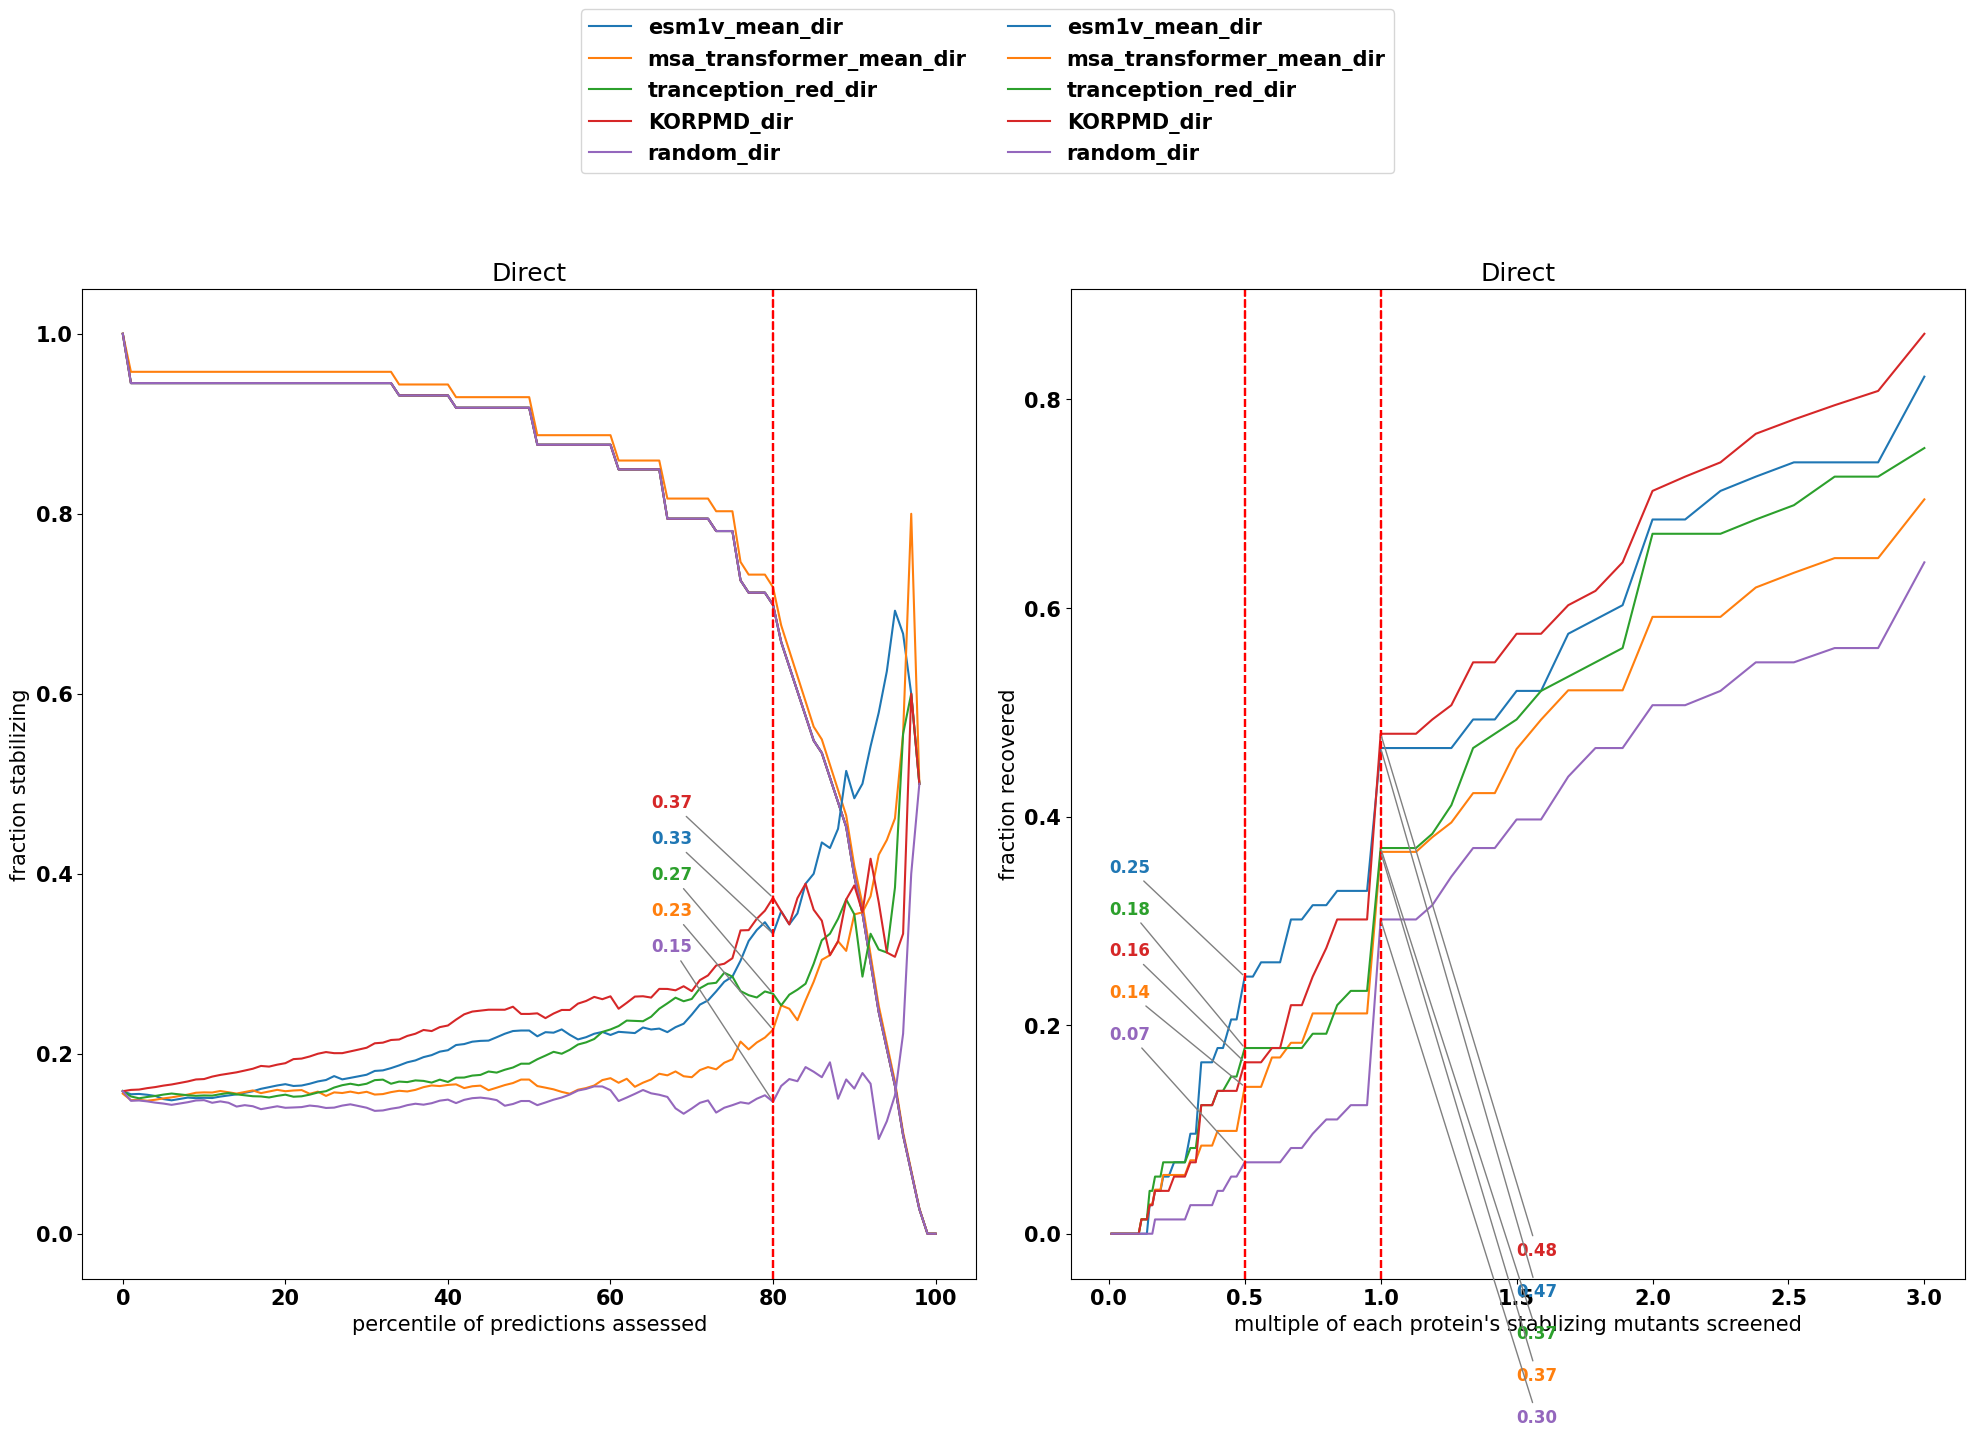

In [133]:
recovery_curves(class_result_new, ['KORPMD', 'esm1v_mean', 'msa_transformer_mean', 'tranception_red', 'random'], 
    percentile_labels=[80], x_recovery_labels=[0.5, 1, 2], text_offset=(0.5, -0.1), spacing=0.04, directions=['dir'])

In [13]:
def correlations(db_complete, score_name, score_name_2=None, min_obs=5, bins=20, corr='spearman', out=True, plot=False, direction='dir'): #stacked=False,
    print(score_name)
    dbf = db_complete.copy(deep=True)

    if score_name_2==None:
        score_name_2 = 'tmp'
        dbf[score_name_2]=0

    if direction == 'combined':
        ddg = 'ddG'
        cols = ['code', score_name, score_name_2, ddg]
        cols = list(set(cols))
        g = dbf[cols].dropna()

    else:
        ddg = f'ddG_{direction}'
        cols = ['code', score_name, score_name_2, ddg]
        cols = list(set(cols))
        g = dbf[cols].dropna()
        new_score_name = score_name.replace('_dir', '').replace('_inv', '')
        g = g.rename({score_name: new_score_name, ddg: 'ddG'}, axis=1)
        dbf = dbf.rename({score_name: new_score_name, ddg: 'ddG'}, axis=1)
        score_name = new_score_name
        ddg = 'ddG'

        if score_name_2 != 'tmp':
            g = g.rename({score_name_2: score_name_2[:-4]}, axis=1)
            dbf = dbf.rename({score_name_2: score_name_2[:-4]}, axis=1)
            score_name_2 = score_name_2[:-4]          

    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(40, 15))
        fig.suptitle(score_name)
        axs[1].set_title(f'distribution of {score_name} predictions')

        sns.histplot(ax=axs[1], data=dbf[score_name], alpha=0.3, color='red', bins=bins)

    g[score_name] = g[score_name].astype(float)
    g[score_name_2] = g[score_name_2].astype(float)

    # get the correlation of each set of predictions, for each protein, to the ground truth
    f = g.groupby('code').corr(corr)[[ddg]]
    h = g.groupby('code').count().iloc[:, -1]
    h.name = 'n_muts'
    f = f.join(h).reset_index()
    f.columns = ['code', 'model', 'corr', 'n_muts']
    if score_name != ddg:
        f = f.loc[f['model']!=ddg]
    i = f.loc[f['n_muts']>=min_obs].pivot_table(index=['code', 'n_muts'], columns=['model'], values='corr')

    ungrouped = g.corr(corr)[[ddg]]#.drop(ddg)
    ungrouped['n_total'] = len(g)
    if score_name_2 == 'tmp':
        ungrouped = ungrouped.drop('tmp')

    #if plot:
    #    axs[0].set_title(f'{score_name} to ground truth')
    #    sns.scatterplot(ax=axs[0], data=g, x=score_name, y='ddG')
    #return(f)  
    
    label_shift = 0.1
    if plot:
        axs[0].set_title(f'distribution of {corr} correlations to ground truth')
        sns.histplot(ax=axs[0],data=i[score_name], alpha=0.3, color='orange', bins=bins, stat='count', kde=True)
        axs[0].set_xlim((-1, 1))
        plt.show()
        data=i
        g = sns.jointplot(data=data, x=score_name_2, y=score_name, kind='hist', 
                          marginal_kws=dict(bins=20), joint_kws=dict(alpha=0), height=30)
        
        threshold = 0.005
        for idx, row in data.reset_index().iterrows():
            tmp_data = data.reset_index().drop(idx).loc[(data.reset_index().drop(idx)[score_name]-row[score_name])**2 < threshold]
            tmp_data_2 = tmp_data.loc[(tmp_data[score_name_2]-row[score_name_2])**2 < threshold]
            if len(tmp_data_2) > 0:
                dx = random.uniform(-label_shift, label_shift)
                dx += 0.01
                dy = random.uniform(-label_shift, label_shift)
                dy += 0.01
                g.ax_joint.text(row[score_name_2]+dx, row[score_name]+dy, f"{row['code']}:{row['n_muts']}", size=4*5)
                g.ax_joint.plot([row[score_name_2], row[score_name_2]+dx], [row[score_name], row[score_name]+dy])
            else:
                g.ax_joint.text(row[score_name_2]+0.01, row[score_name]+0.01, f"{row['code']}:{row['n_muts']}", size=4*5)

        sns.scatterplot(data=data, x=score_name_2, y=score_name, size='n_muts', sizes=(2*100,70*100), ax=g.ax_joint, alpha=0.4)
        small = np.array(i[[score_name_2, score_name]].dropna()).min().min()
        sns.lineplot(data=pd.DataFrame({'x': np.arange(small, 1, 0.01), 'y': np.arange(small, 1, 0.01)}), 
                        x='x', y='y', ax=g.ax_joint, color='red')
        plt.show()
        
    if out:
        df_out = pd.DataFrame(columns=[score_name, score_name_2] if score_name_2 != 'tmp' else [score_name], dtype=float) 
        
        reduced = i.reset_index()

        for score in [score_name] + ([score_name_2] if score_name_2 != 'tmp' else []):
            df_out.at[f'n_total', score] = ungrouped.at[score, 'n_total']
            df_out.at[f'n_proteins', score] = len(reduced.loc[reduced['n_muts']>=min_obs])
            df_out.at[f'avg_{corr}', score] = reduced[score].mean()
            df_out.at[f'weighted_{corr}', score] = np.average(reduced[score], weights=np.log(reduced['n_muts']))
            df_out.at[f'ungrouped_{corr}', score] = ungrouped.at[score, ddg]

        #for col in [d for d in df_out.columns if '_inv' in d]:
        #    df_out.loc[[f'avg_{corr}', f'weighted_{corr}', f'ungrouped_{corr}'], col]
        df_out = df_out.T.reset_index().rename({'index': 'model'}, axis=1)
        df_out['direction'] = direction
        df_out = df_out.set_index(['direction', 'model'])

        return df_out
    
    return i

korpm_dir


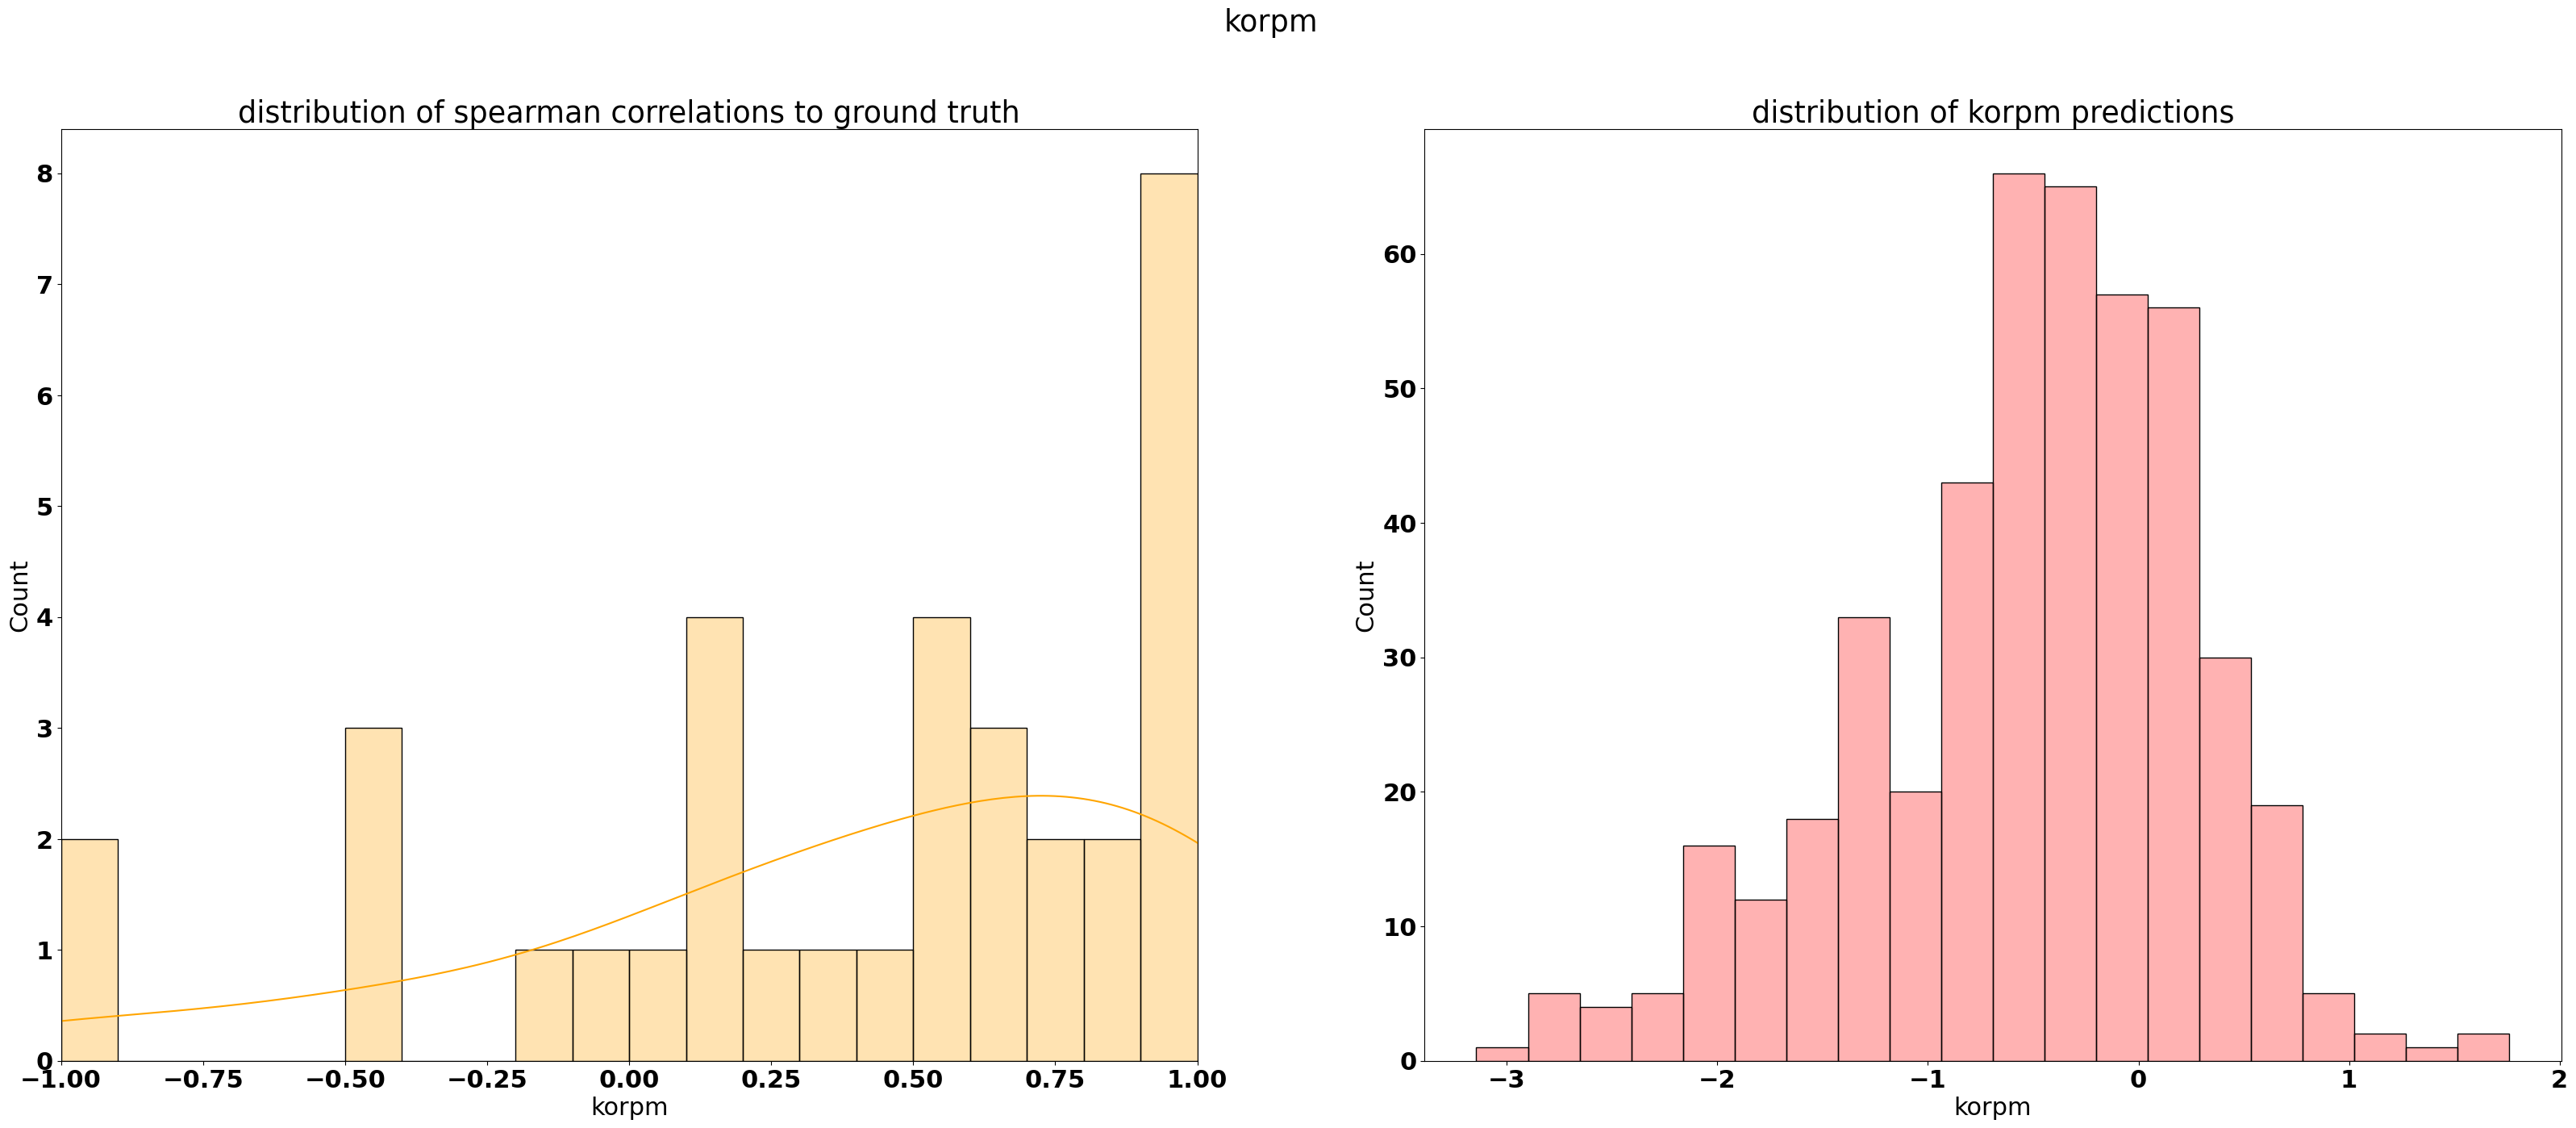

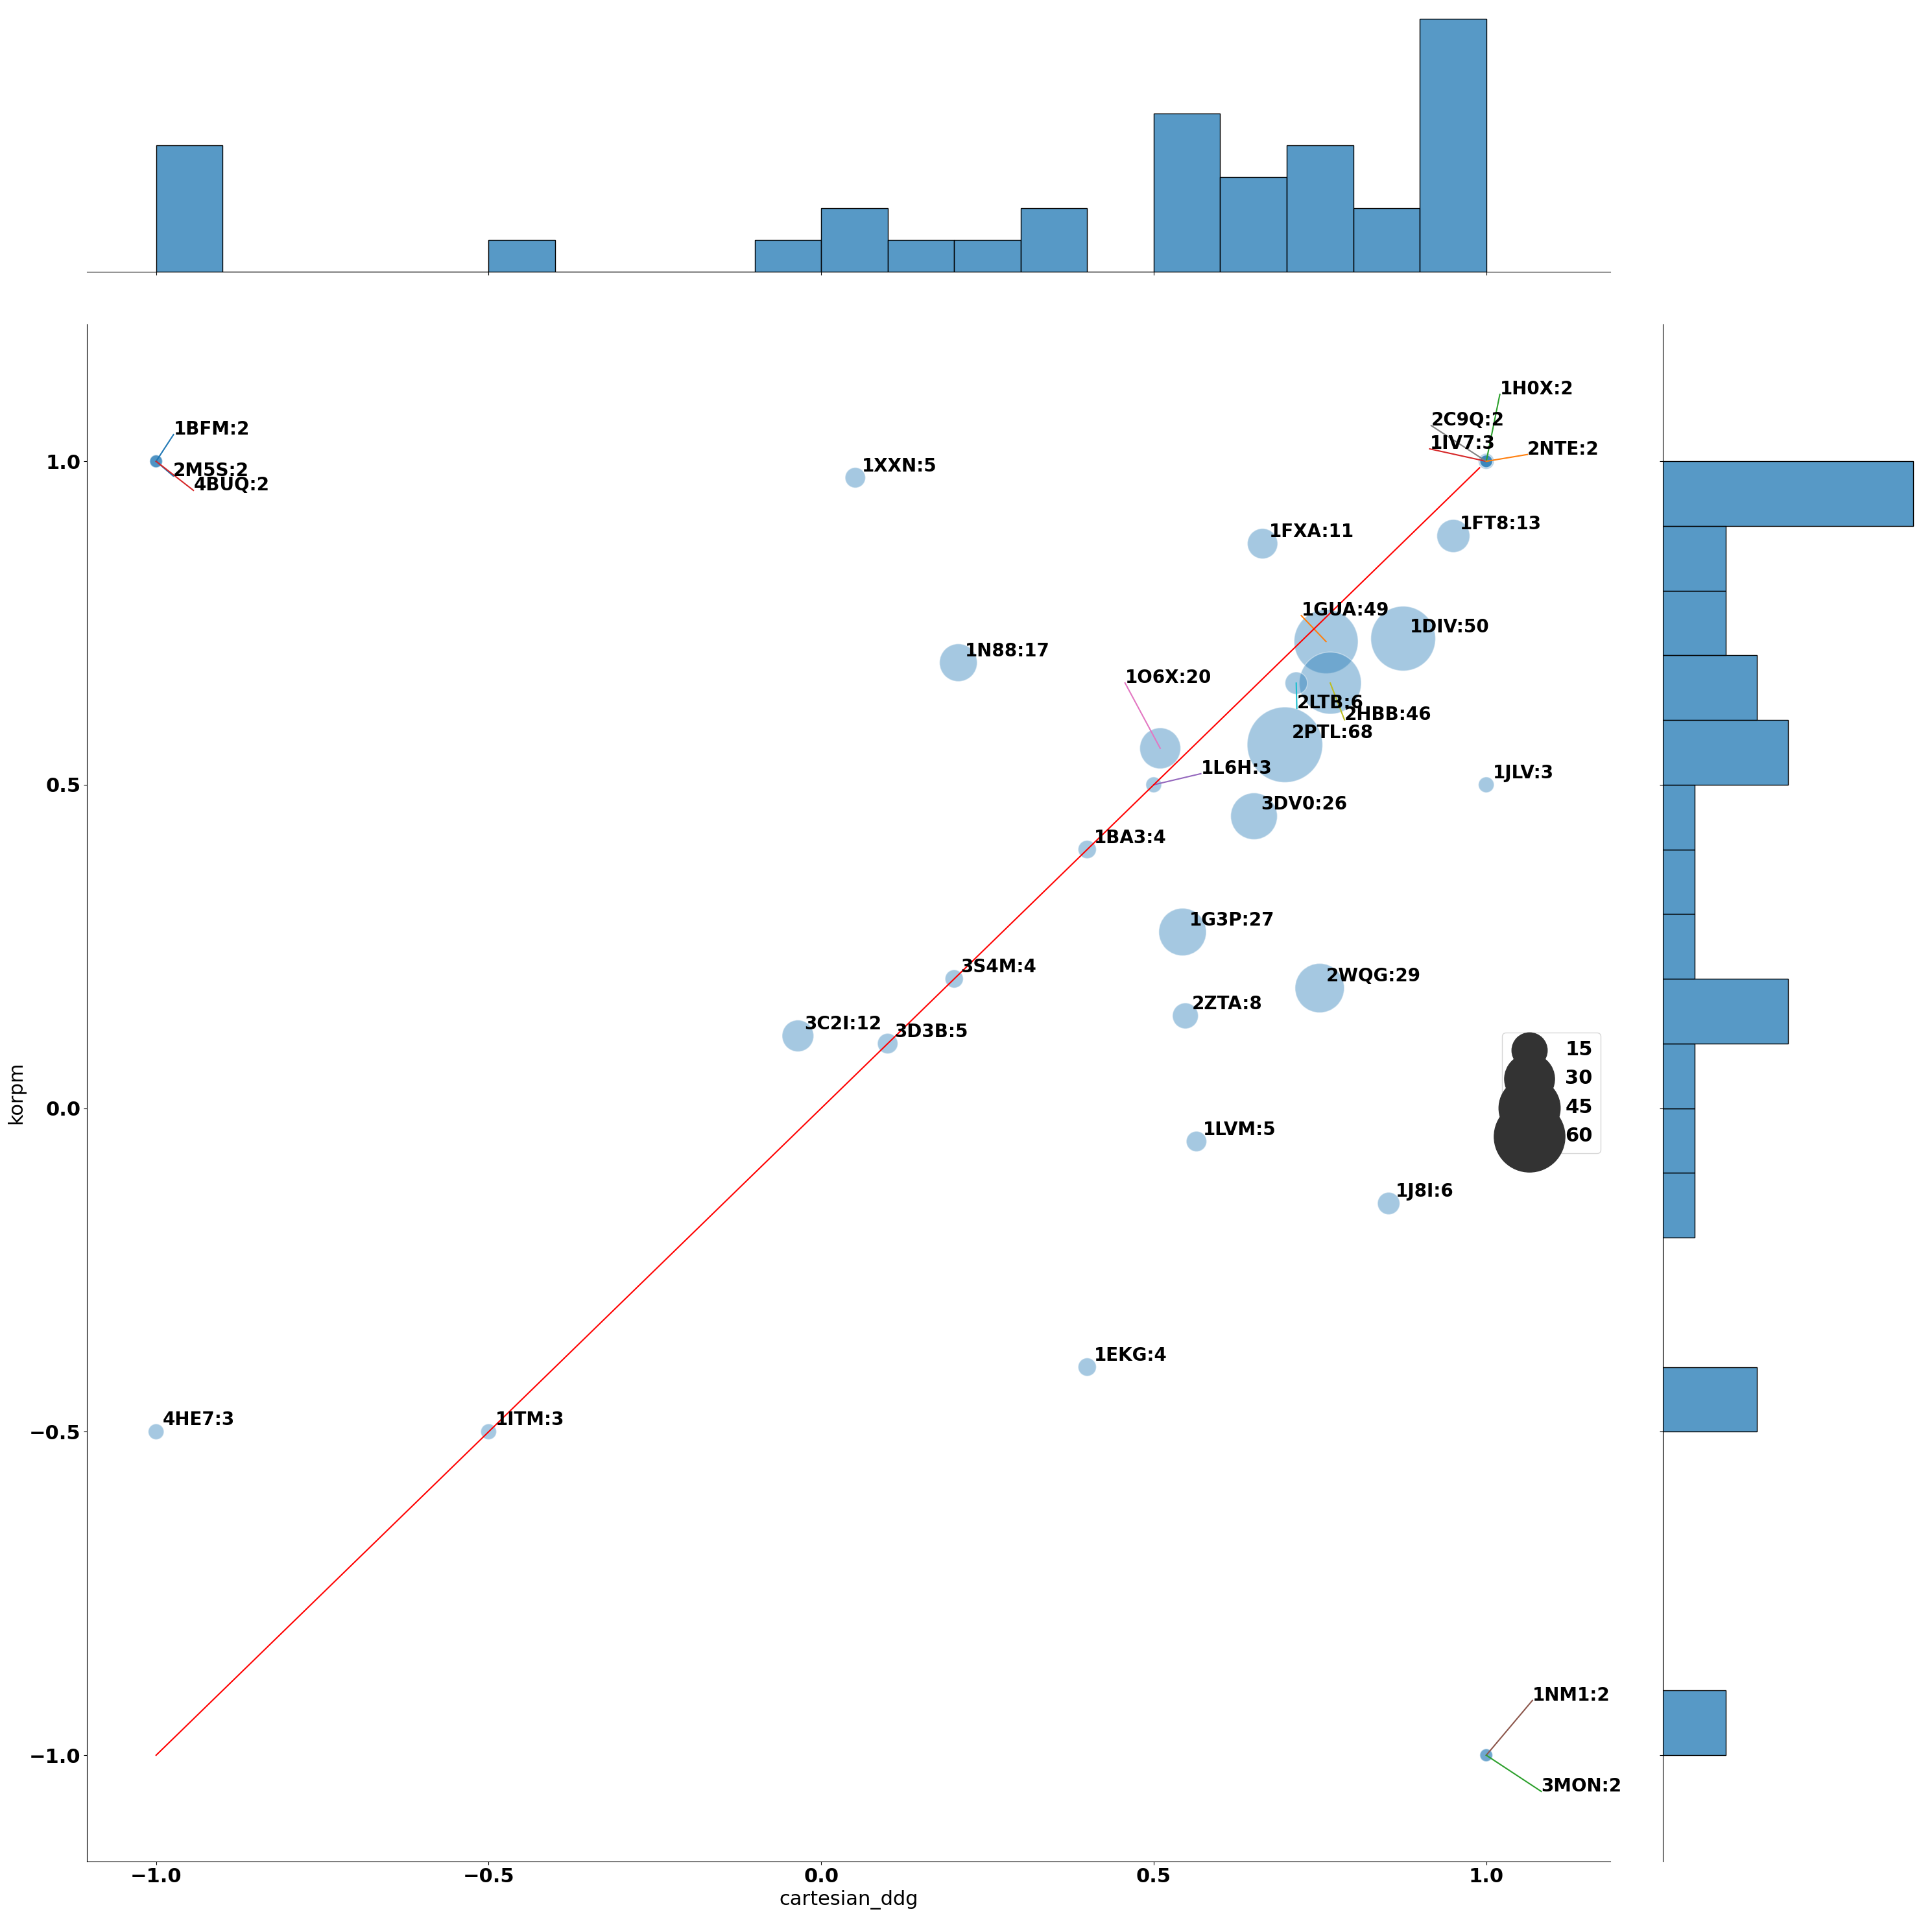

n_total  n_proteins  avg_spearman  weighted_spearman  \
direction model                                                                 
dir       korpm            460.0        34.0      0.399025           0.444771   
          cartesian_ddg    460.0        34.0      0.416668           0.520715   

                         ungrouped_spearman  
direction model                              
dir       korpm                    0.547762  
          cartesian_ddg            0.632916

In [14]:
score_1 = 'korpm_dir'
score_2 = 'cartesian_ddg_dir'
correlations(db_complete, score_1, score_name_2=score_2, min_obs=1, corr='spearman', plot=True, out=True, direction='dir')

In [15]:
def get_summary_df(db_complete, cols=None, saveloc='../../zeroshot suppl/ensemble_s461_summary.csv', stats=(), stacked=False):

    assert not os.path.exists(saveloc)
    if cols is None:
        cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    #df_reg_dir = pd.concat([correlations(db_complete, s1, min_obs=1, corr='spearman', plot=False, out=True, direction='dir') for s1 in tqdm(cols) if '_dir' in s1])
    #df_reg_inv = pd.concat([correlations(db_complete, s1, min_obs=1, corr='spearman', plot=False, out=True, direction='inv') for s1 in tqdm(cols) if '_inv' in s1])
    if not stacked:
        db_stacked = stack_frames(db_complete)
    else:
        db_stacked = db_complete
    db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])
    #df_reg_comb = pd.concat([correlations(db_stacked, s1, min_obs=1, corr='spearman', plot=False, out=True, direction='combined') for s1 in tqdm(db_stacked.columns.drop('code'))])

    #df_reg = pd.concat([df_reg_dir, df_reg_inv, df_reg_comb])
    #df_reg.to_csv('../../zeroshot suppl/test.csv')

    df_summ = classifications(db_stacked.drop(['code'], axis=1), stacked=True, stats=()).reset_index().set_index(['direction', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['direction', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [16]:
#d3 = pd.read_csv('../../zeroshot suppl/class_na_2.csv', index_col=[0,1,2]).dropna(how='all')
#d3 = d3.reset_index().set_index(['direction', 'model'])
#d3 = d3.reset_index().rename({'index': 'model'}, axis=1).set_index(['direction', 'model_type', 'model', 'class'])
#d3 = d3.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
#d3 = d3.reset_index()
#d3.loc[d3['model'] == 'ACDC-NN + I-Mutant3.0 * 0.2']

In [17]:
db_complete

KORPMD_dir  CartddgD_dir  FoldXD_dir  EvoD_dir  Dyna2D_dir  \
uid                                                                     
1A0F_11A        0.138          1.45        0.48     -0.37       0.545   
1BA3_457D      -1.065         -4.47       -0.86     -0.77       0.160   
1BA3_485D       0.270          0.64       -0.13      0.96      -0.193   
1BA3_485K       0.398          0.86        0.19      1.12       0.190   
1BA3_485M      -0.211         -1.08        0.30      1.42      -0.138   
...               ...           ...         ...       ...         ...   
4HE7_19G       -0.249         -2.20       -0.04     -0.71      -0.133   
4HE7_19K       -0.063          0.59        0.04      0.18      -0.119   
5JXB_25G       -0.426         -4.72       -0.85     -0.53       0.694   
5JXB_25P       -0.930         -8.00       -0.97      0.42       0.390   
5OAQ_199H      -2.512         -8.00       -3.64     -4.12      -0.411   

           PopMsD_dir  DDGunD_dir  TNetD_dir  ACDCNND_dir  ACDC-NN-Seq_dir  \
uid                                                                          
1A0F_11A        -1.04         0.5      0.021        0.225         0.041723   
1BA3_457D       -1.19        -1.2      0.123       -0.230        -0.447964   
1BA3_485D        0.07        -0.1      0.037       -0.040        -0.000271   
1BA3_485K        0.26        -0.1      0.139        0.201         0.006583   
1BA3_485M        0.29         0.0      0.169        0.231         0.079617   
...               ...         ...        ...          ...              ...   
4HE7_19G        -0.83        -0.4      0.106       -0.728        -0.914432   
4HE7_19K        -0.46        -0.3      0.657       -0.346         0.026103   
5JXB_25G        -0.05        -0.3      0.094       -0.134        -0.000839   
5JXB_25P        -0.06        -0.2     -0.137        0.134         0.000536   
5OAQ_199H       -2.46        -2.4     -0.230       -1.356        -1.387815   

           ...   bend   turn   coil  strand  xray_else_NMR  active_site  code  \
uid        ...                                                                  
1A0F_11A   ...  False   True  False   False           True        False  1A0F   
1BA3_457D  ...   True  False  False   False           True        False  1BA3   
1BA3_485D  ...  False   True  False   False           True        False  1BA3   
1BA3_485K  ...  False   True  False   False           True        False  1BA3   
1BA3_485M  ...  False   True  False   False           True        False  1BA3   
...        ...    ...    ...    ...     ...            ...          ...   ...   
4HE7_19G   ...  False   True  False   False           True        False  4HE7   
4HE7_19K   ...  False   True  False   False           True        False  4HE7   
5JXB_25G   ...   True  False  False   False           True        False  5JXB   
5JXB_25P   ...   True  False  False   False           True        False  5JXB   
5OAQ_199H  ...  False  False  False    True           True        False  5OAQ   

                   neff  random_dir  random_inv  
uid                                              
1A0F_11A   11312.451628   -0.179499   -0.319942  
1BA3_457D   9739.398597   -0.489166    0.232741  
1BA3_485D   9739.398597    0.342114   -0.312638  
1BA3_485K   9739.398597    0.121679   -0.384936  
1BA3_485M   9739.398597   -0.444621   -0.427213  
...                 ...         ...         ...  
4HE7_19G    1019.898713    0.135129   -0.180265  
4HE7_19K    1019.898713   -0.441292    0.309738  
5JXB_25G     112.986182    0.204656    0.054384  
5JXB_25P     112.986182   -0.426989   -0.399893  
5OAQ_199H    197.028468   -0.069730    0.176159  

[461 rows x 123 columns]

In [18]:
zs_feats = ['delta_kdh', 'delta_vol', 'delta_chg']

db_ens = db_complete.copy(deep=True)
for zs in zs_feats:
    db_ens[zs+'_dir'] = db_ens[zs]
    db_ens[zs+'_inv'] = -db_ens[zs]

print(len(db_ens))
db_ens['random_dir'] = np.random.rand(len(db_ens)) - 0.5
db_ens['random_inv'] = np.random.rand(len(db_ens)) - 0.5
db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
db_ens

461


ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1BA3_457D        -0.447964         0.447964    -0.230352     0.297794   
1BA3_485D        -0.000271         0.000271    -0.040138     0.058415   
1BA3_485K         0.006583        -0.006583     0.201055    -0.153260   
1BA3_485M         0.079617        -0.079617     0.230963    -0.235092   
...                    ...              ...          ...          ...   
4HE7_19G         -0.914432         0.914432    -0.728433     0.865697   
4HE7_19K          0.026103        -0.026103    -0.345831     0.496220   
5JXB_25G         -0.000839         0.000839    -0.134107     0.134107   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1BA3_457D         -1.2          1.4       -1.4        1.4    -1.757    -0.005   
1BA3_485D         -0.1          0.1       -0.7        0.6    -0.252     0.522   
1BA3_485K         -0.1          0.2       -0.9        0.9     0.358    -0.220   
1BA3_485M          0.0          0.0        0.0       -0.1     0.287     0.507   
...                ...          ...        ...        ...       ...       ...   
4HE7_19G          -0.4          0.9       -1.3        1.2    -0.021     0.150   
4HE7_19K          -0.3          0.5       -1.1        1.0    -0.518     0.128   
5JXB_25G          -0.3          0.0       -0.7        0.4     0.254    -0.833   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   

           ...  code          neff  random_dir  random_inv  delta_kdh_dir  \
uid        ...                                                              
1A0F_11A   ...  1A0F  11312.451628    0.365694    0.029240            2.6   
1BA3_457D  ...  1BA3   9739.398597    0.285386   -0.129802           -0.3   
1BA3_485D  ...  1BA3   9739.398597   -0.304294   -0.349100           -0.3   
1BA3_485K  ...  1BA3   9739.398597   -0.068276    0.215192           -0.7   
1BA3_485M  ...  1BA3   9739.398597    0.368111   -0.267392            5.1   
...        ...   ...           ...         ...         ...            ...   
4HE7_19G   ...  4HE7   1019.898713   -0.189994    0.147142           -2.2   
4HE7_19K   ...  4HE7   1019.898713   -0.297881   -0.190020           -5.7   
5JXB_25G   ...  5JXB    112.986182    0.333636    0.055403            3.1   
5JXB_25P   ...  5JXB    112.986182   -0.244157   -0.000966            1.9   
5OAQ_199H  ...  5OAQ    197.028468   -0.155472    0.330731           -1.9   

           delta_kdh_inv  delta_vol_dir  delta_vol_inv  delta_chg_dir  \
uid                                                                     
1A0F_11A            -2.6          -0.60           0.60              0   
1BA3_457D            0.3          -1.88           1.88             -1   
1BA3_485D            0.3          -1.88           1.88             -1   
1BA3_485K            0.7           0.11          -0.11              1   
1BA3_485M           -5.1          -0.23           0.23              0   
...                  ...            ...            ...            ...   
4HE7_19G             2.2          -1.00           1.00              0   
4HE7_19K             5.7           3.77          -3.77              1   
5JXB_25G            -3.1          -2.78           2.78              1   
5JXB_25P            -1.9          -0.06           0.06              1   
5OAQ_199H            1.9          -1.81           1.81              0   

           delta_chg_inv  
uid                       
1

In [19]:
models = [c for c in db_ens.columns if ('_dir' in c or '_inv' in c) and not ('DDG_' in c or 'random' in c or 'MUT_D' in c or 'PDB' in c or 'ddG' in c)]
#models = [c for c in db_ens.columns if ('_dir' in c or '_inv' in c) and ('SAAFEC' in c or 'Dynamut' in c or 'mpnn_mean' in c)]
dfm = db_ens.copy(deep=True)#.T.drop_duplicates().T
dfm = dfm[models + ['ddG_dir', 'ddG_inv']]
dfm2 = dfm.copy(deep=True)
dfm

ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1BA3_457D        -0.447964         0.447964    -0.230352     0.297794   
1BA3_485D        -0.000271         0.000271    -0.040138     0.058415   
1BA3_485K         0.006583        -0.006583     0.201055    -0.153260   
1BA3_485M         0.079617        -0.079617     0.230963    -0.235092   
...                    ...              ...          ...          ...   
4HE7_19G         -0.914432         0.914432    -0.728433     0.865697   
4HE7_19K          0.026103        -0.026103    -0.345831     0.496220   
5JXB_25G         -0.000839         0.000839    -0.134107     0.134107   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1BA3_457D         -1.2          1.4       -1.4        1.4    -1.757    -0.005   
1BA3_485D         -0.1          0.1       -0.7        0.6    -0.252     0.522   
1BA3_485K         -0.1          0.2       -0.9        0.9     0.358    -0.220   
1BA3_485M          0.0          0.0        0.0       -0.1     0.287     0.507   
...                ...          ...        ...        ...       ...       ...   
4HE7_19G          -0.4          0.9       -1.3        1.2    -0.021     0.150   
4HE7_19K          -0.3          0.5       -1.1        1.0    -0.518     0.128   
5JXB_25G          -0.3          0.0       -0.7        0.4     0.254    -0.833   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   

           ...  cartesian_ddg_dir  cartesian_ddg_inv  delta_kdh_dir  \
uid        ...                                                        
1A0F_11A   ...           2.605333          -4.279000            2.6   
1BA3_457D  ...          -5.387333           4.223000           -0.3   
1BA3_485D  ...          -0.105333          -0.045000           -0.3   
1BA3_485K  ...           0.447000          -1.895000           -0.7   
1BA3_485M  ...          -1.237000           1.393000            5.1   
...        ...                ...                ...            ...   
4HE7_19G   ...          -1.934333           1.034667           -2.2   
4HE7_19K   ...           1.579000          -0.388333           -5.7   
5JXB_25G   ...           1.105333          -2.452000            3.1   
5JXB_25P   ...         -17.355333           2.823667            1.9   
5OAQ_199H  ...          -3.910667           4.366000           -1.9   

           delta_kdh_inv  delta_vol_dir  delta_vol_inv  delta_chg_dir  \
uid                                                                     
1A0F_11A            -2.6          -0.60           0.60              0   
1BA3_457D            0.3          -1.88           1.88             -1   
1BA3_485D            0.3          -1.88           1.88             -1   
1BA3_485K            0.7           0.11          -0.11              1   
1BA3_485M           -5.1          -0.23           0.23              0   
...                  ...            ...            ...            ...   
4HE7_19G             2.2          -1.00           1.00              0   
4HE7_19K             5.7           3.77          -3.77              1   
5JXB_25G            -3.1          -2.78           2.78              1   
5JXB_25P            -1.9          -0.06           0.06              1   
5OAQ_199H            1.9          -1.81           1.81              0   

           delta_chg_inv  ddG_dir  ddG_inv  
uid                                         
1A0F_11A               0   -1.800    1.800 

In [20]:
weights = [1, 0.5, 0.2]
weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1[-4:] == model2[-4:] and model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
#dfm.to_csv('../../zeroshot suppl/preds_ensemble_s461_2_models_both_newdata.csv')
dfm

ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1BA3_457D        -0.447964         0.447964    -0.230352     0.297794   
1BA3_485D        -0.000271         0.000271    -0.040138     0.058415   
1BA3_485K         0.006583        -0.006583     0.201055    -0.153260   
1BA3_485M         0.079617        -0.079617     0.230963    -0.235092   
...                    ...              ...          ...          ...   
4HE7_19G         -0.914432         0.914432    -0.728433     0.865697   
4HE7_19K          0.026103        -0.026103    -0.345831     0.496220   
5JXB_25G         -0.000839         0.000839    -0.134107     0.134107   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1BA3_457D         -1.2          1.4       -1.4        1.4    -1.757    -0.005   
1BA3_485D         -0.1          0.1       -0.7        0.6    -0.252     0.522   
1BA3_485K         -0.1          0.2       -0.9        0.9     0.358    -0.220   
1BA3_485M          0.0          0.0        0.0       -0.1     0.287     0.507   
...                ...          ...        ...        ...       ...       ...   
4HE7_19G          -0.4          0.9       -1.3        1.2    -0.021     0.150   
4HE7_19K          -0.3          0.5       -1.1        1.0    -0.518     0.128   
5JXB_25G          -0.3          0.0       -0.7        0.4     0.254    -0.833   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   

           ...  delta_chg_inv + mpnn_mean_inv * 0.2  \
uid        ...                                        
1A0F_11A   ...                             0.271799   
1BA3_457D  ...                             1.893691   
1BA3_485D  ...                             1.431834   
1BA3_485K  ...                            -1.846538   
1BA3_485M  ...                             0.065065   
...        ...                                  ...   
4HE7_19G   ...                             0.031214   
4HE7_19K   ...                            -1.649529   
5JXB_25G   ...                            -1.735763   
5JXB_25P   ...                            -1.689650   
5OAQ_199H  ...                             0.262349   

           delta_chg_inv + cartesian_ddg_inv * 1  \
uid                                                
1A0F_11A                               -1.184056   
1BA3_457D                               2.743326   
1BA3_485D                               1.562313   
1BA3_485K                              -2.099137   
1BA3_485M                               0.385462   
...                                          ...   
4HE7_19G                                0.286306   
4HE7_19K                               -1.682222   
5JXB_25G                               -2.253266   
5JXB_25P                               -0.793419   
5OAQ_199H                               1.208130   

           delta_chg_inv + cartesian_ddg_inv * 0.5  \
uid                                                  
1A0F_11A                                 -0.592028   
1BA3_457D                                 2.159045   
1BA3_485D                                 1.568539   
1BA3_485K                                -1.836951   
1BA3_485M                                 0.192731   
...                                            ...   
4HE7_19G                                  0.143153   
4HE7_19K                                 -1.628494   
5JXB_25G                                 -1.914016   
5JXB_25P            

In [21]:
dfm_stacked = stack_frames(dfm)

In [24]:
dfm_stacked['code'] = dfm_stacked.reset_index()['uid'].str[:4]
d1 = get_summary_df(dfm_stacked, saveloc='../../zeroshot suppl/ensemble_s461_2_models_3_final_final_final.csv', stacked=True, stats=()) 
#d1 = get_summary_df(dfm, saveloc='../../zeroshot suppl/ensemble_s461_2_models_3_final.csv') 

  0%|          | 0/6257 [00:00<?, ?it/s]

  0%|          | 0/6257 [00:00<?, ?it/s]

inv  ACDC-NN + esmif_multimer * 0.2
inv  ACDC-NN + esmif_multimer * 0.5
inv  ACDC-NN + esmif_multimer * 1
inv  ACDC-NN + esmif_multimer_full * 0.2
inv  ACDC-NN + esmif_multimer_full * 0.5
inv  ACDC-NN + esmif_multimer_full * 1
inv  ACDC-NN + esmif_multimer_full_masked * 0.2
inv  ACDC-NN + esmif_multimer_full_masked * 0.5
inv  ACDC-NN + esmif_multimer_full_masked * 1
inv  ACDC-NN + mpnn_20_02 * 0.2
inv  ACDC-NN + mpnn_20_02 * 0.5
inv  ACDC-NN + mpnn_20_02 * 1
inv  ACDC-NN + mpnn_20_mean * 0.2
inv  ACDC-NN + mpnn_20_mean * 0.5
inv  ACDC-NN + mpnn_20_mean * 1
inv  ACDC-NN + mpnn_30_03 * 0.2
inv  ACDC-NN + mpnn_30_03 * 0.5
inv  ACDC-NN + mpnn_30_03 * 1
inv  ACDC-NN + mpnn_30_noise * 0.2
inv  ACDC-NN + mpnn_30_noise * 0.5
inv  ACDC-NN + mpnn_30_noise * 1
inv  ACDC-NN + tranception * 0.2
inv  ACDC-NN + tranception * 0.5
inv  ACDC-NN + tranception * 1
inv  ACDC-NN-Seq + esmif_multimer * 0.2
inv  ACDC-NN-Seq + esmif_multimer * 0.5
inv  ACDC-NN-Seq + esmif_multimer * 1
inv  ACDC-NN-Seq + esmif_

In [21]:
d1

direction    model_type                                  model  class  \
0      combined  evolutionary            ACDC-NN + ACDC-NN-Seq * 0.2    NaN   
1      combined  evolutionary            ACDC-NN + ACDC-NN-Seq * 0.5    NaN   
2      combined  evolutionary              ACDC-NN + ACDC-NN-Seq * 1    NaN   
3      combined  evolutionary                  ACDC-NN + DDGun * 0.2    NaN   
4      combined  evolutionary                  ACDC-NN + DDGun * 0.5    NaN   
...         ...           ...                                    ...    ...   
17549       inv    structural  tranception_red + mpnn_30_noise * 0.5    NaN   
17550       inv    structural    tranception_red + mpnn_30_noise * 1    NaN   
17551       inv    structural      tranception_red + mpnn_mean * 0.2    NaN   
17552       inv    structural      tranception_red + mpnn_mean * 0.5    NaN   
17553       inv    structural        tranception_red + mpnn_mean * 1    NaN   

           n     tp    fp     tn    fn  sensitivity  ...  2.12x_recovery  \
0      922.0  363.0  95.0  368.0  96.0     0.790850  ...        1.000000   
1      922.0  363.0  96.0  367.0  96.0     0.790850  ...        1.000000   
2      922.0  361.0  96.0  367.0  98.0     0.786492  ...        1.000000   
3      868.0  348.0  84.0  352.0  84.0     0.805556  ...        1.000000   
4      868.0  353.0  80.0  356.0  79.0     0.817130  ...        1.000000   
...      ...    ...   ...    ...   ...          ...  ...             ...   
17549    0.0    NaN   NaN    NaN   NaN          NaN  ...             NaN   
17550    0.0    NaN   NaN    NaN   NaN          NaN  ...             NaN   
17551  460.0  369.0  57.0   18.0  16.0     0.958442  ...        0.997403   
17552  460.0  367.0  53.0   22.0  18.0     0.953247  ...        0.997403   
17553  460.0  358.0  46.0   29.0  27.0     0.929870  ...        0.994805   

       2.25x_recovery  2.38x_recovery  2.52x_recovery  2.67x_recovery  \
0            1.000000        1.000000        1.000000        1.000000   
1            1.000000        1.000000        1.000000        1.000000   
2            1.000000        1.000000        1.000000        1.000000   
3            1.000000        1.000000        1.000000        1.000000   
4            1.000000        1.000000        1.000000        1.000000   
...               ...             ...             ...             ...   
17549             NaN             NaN             NaN             NaN   
17550             NaN             NaN             NaN             NaN   
17551        0.997403        0.997403        0.997403        0.997403   
17552        0.997403        0.997403        0.997403        0.997403   
17553        0.994805        0.994805        0.997403        0.997403   

       2.83x_recovery  3.0x_recovery     aumrc  antisymmetry      bias  
0            1.000000            1.0  0.459923     -0.986372 -0.011576  
1            1.000000            1.0  0.460215     -0.991201 -0.011576  
2            1.000000            1.0  0.460736     -0.995036 -0.011576  
3            1.000000            1.0  0.461754     -0.983537 -0.022514  
4            1.000000            1.0  0.462203     -0.982877 -0.037709  
...               ...            ...       ...           ...       ...  
17549             NaN            NaN       NaN           NaN       NaN  
17550             NaN            NaN       NaN           NaN       NaN  
17551        0.997403            1.0  0.477612           NaN       NaN  
17552        0.997403            1.0  0.478736           NaN       NaN  
17553        0.997403            1.0  0.480907           NaN       NaN  

[17554 rows x 199 columns]

In [31]:
d1 = pd.read_csv('../../zeroshot suppl/ensemble_s461_2_models_3_final_final_final.csv').set_index(['direction', 'model_type', 'model'])

In [105]:
supp2 = d1.xs('combined')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'ausrc', 'aumrc', 'antisymmetry', 'bias']].reset_index().drop(['model_type', 'class'], axis=1).set_index('model')
supp2

auprc  mean_stabilization  \
model                                                              
ACDC-NN + ACDC-NN-Seq * 0.2         0.884276            1.041989   
ACDC-NN + ACDC-NN-Seq * 0.5         0.884661            1.037911   
ACDC-NN + ACDC-NN-Seq * 1           0.884660            1.036698   
ACDC-NN + DDGun * 0.2               0.892495            1.096299   
ACDC-NN + DDGun * 0.5               0.893525            1.088127   
...                                      ...                 ...   
tranception_red + mpnn_30_00 * 0.5  0.865615            1.181623   
tranception_red + mpnn_30_00 * 1    0.875482            1.163778   
tranception_red + mpnn_mean * 0.2   0.849587            1.172197   
tranception_red + mpnn_mean * 0.5   0.863093            1.197584   
tranception_red + mpnn_mean * 1     0.873388            1.191107   

                                    net_stabilization  weighted_ndcg  \
model                                                                  
ACDC-NN + ACDC-NN-Seq * 0.2                   477.231       0.913778   
ACDC-NN + ACDC-NN-Seq * 0.5                   476.401       0.913041   
ACDC-NN + ACDC-NN-Seq * 1                     473.771       0.916377   
ACDC-NN + DDGun * 0.2                         473.601       0.914500   
ACDC-NN + DDGun * 0.5                         471.159       0.913318   
...                                               ...            ...   
tranception_red + mpnn_30_00 * 0.5            535.275       0.936576   
tranception_red + mpnn_30_00 * 1              523.700       0.942967   
tranception_red + mpnn_mean * 0.2             534.522       0.936488   
tranception_red + mpnn_mean * 0.5             535.320       0.938046   
tranception_red + mpnn_mean * 1               522.896       0.943269   

                                    weighted_spearman     ausrc     aumrc  \
model                                                                       
ACDC-NN + ACDC-NN-Seq * 0.2                  0.542629  0.770158  0.459923   
ACDC-NN + ACDC-NN-Seq * 0.5                  0.548281  0.771027  0.460215   
ACDC-NN + ACDC-NN-Seq * 1                    0.552388  0.774002  0.460736   
ACDC-NN + DDGun * 0.2                        0.567938  0.779078  0.461754   
ACDC-NN + DDGun * 0.5                        0.567785  0.779933  0.462203   
...                                               ...       ...       ...   
tranception_red + mpnn_30_00 * 0.5           0.676551  0.782138  0.465554   
tranception_red + mpnn_30_00 * 1             0.689382  0.787572  0.467998   
tranception_red + mpnn_mean * 0.2            0.681568  0.777393  0.463762   
tranception_red + mpnn_mean * 0.5            0.677610  0.781420  0.465196   
tranception_red + mpnn_mean * 1              0.689752  0.784884  0.466695   

                                    antisymmetry      bias  
model                                                       
ACDC-NN + ACDC-NN-Seq * 0.2            -0.986372 -0.011576  
ACDC-NN + ACDC-NN-Seq * 0.5            -0.991201 -0.011576  
ACDC-NN + ACDC-NN-Seq * 1              -0.995036 -0.011576  
ACDC-NN + DDGun * 0.2                  -0.983537 -0.022514  
ACDC-NN + DDGun * 0.5                  -0.982877 -0.037709  
...                                          ...       ...  
tranception_red + mpnn_30_00 * 0.5     -0.936597 -0.072558  
tranception_red + mpnn_30_00 * 1       -0.847520 -0.145115  
tranception_red + mpnn_mean * 0.2      -0.984671 -0.045745  
tranception_red + mpnn_mean * 0.5      -0.926132 -0.114363  
tranception_red + mpnn_mean * 1        -0.821656 -0.228726  

[4257 rows x 9 columns]

In [32]:
d4 = d1.reset_index()
d4.loc[d4['model']=='random']

Empty DataFrame
Columns: [direction, model_type, model, class, n, tp, fp, tn, fn, sensitivity, specificity, precision, pred_positives_ratio, accuracy, f1_score, MCC, auroc, auprc, n_stable, ndcg, mean_ndcg, weighted_ndcg, spearman, mean_spearman, weighted_spearman, mean_auprc, weighted_auprc, 0$, 1$, 2$, 3$, 4$, 5$, 6$, 7$, 8$, 9$, 10$, 11$, 12$, 13$, 14$, 15$, 16$, 17$, 18$, 19$, 20$, 21$, 22$, 23$, 24$, 25$, 26$, 27$, 28$, 29$, 30$, 31$, 32$, 33$, 34$, 35$, 36$, 37$, 38$, 39$, 40$, 41$, 42$, 43$, 44$, 45$, 46$, 47$, 48$, 49$, 50$, 51$, 52$, 53$, 54$, 55$, 56$, 57$, 58$, 59$, 60$, 61$, 62$, 63$, 64$, 65$, 66$, 67$, 68$, 69$, 70$, 71$, 72$, ...]
Index: []

[0 rows x 199 columns]

In [25]:
def process_index(index_str):
    # Split the index string by ' + '
    components = index_str.split(' + ')

    # Initialize the model and weight columns
    model1 = None
    weight1 = 1
    model2 = None
    weight2 = 0

    # Process the components
    for component in components:
        model_weight = component.split(' * ')

        if len(model_weight) == 1:
            # Only one model with an implicit weight of 1
            model1 = model_weight[0].strip()
            model2 = model1

        elif len(model_weight) == 2:
            model, weight = model_weight

            if model1 is None:
                model1 = model.strip()
                weight1 = float(weight.strip())
            else:
                model2 = model.strip()
                weight2 = float(weight.strip())

    return model1, weight1, model2, weight2

In [135]:
from matplotlib.colors import Normalize, ListedColormap
from matplotlib.lines import Line2D

def get_stat_df(df, statistic, new_dir, preds=None):
    # Extract unique models from the DataFrame
    unique_models = pd.unique(df[['model1', 'model2']].values.ravel('K'))

    # Initialize the dictionary to store model combinations and their statistics
    combinations = {'model1': [], 'weight1': [], 'model2': [], 'weight2': [], statistic: []}
    if preds is not None:
        combinations.update({'corr': []}) #'runtime': [],
    #print(df.set_index('model').loc['ACDC-NN + I-Mutant3.0 * 0.2'])
    # Iterate through all unique pairs of models (upper-triangular)
    for i, model1 in enumerate(unique_models):
        for j, model2 in enumerate(unique_models):
            if j >= i:
                # Calculate the statistic for the current pair of models
                temp_df = df[((df['model1'] == model1) & (df['model2'] == model2)) | 
                            ((df['model1'] == model2) & (df['model2'] == model1))]

                stat_row = temp_df.loc[temp_df[statistic]==temp_df[statistic].max()].head(1)
                if len(stat_row) == 0:
                    print(model1, model2, 'e')
                    continue

                # Store the model pair and statistic value in the dictionary
                combinations['model1'].append(stat_row['model1'].item())
                combinations['weight1'].append(stat_row['weight1'].item())
                combinations['model2'].append(stat_row['model2'].item())
                combinations['weight2'].append(stat_row['weight2'].item())
                combinations[statistic].append(stat_row[statistic].item())
                if preds is not None:
                    combinations['corr'].append(preds[[model1+new_dir, model2+new_dir]].corr('spearman').iloc[0,1])

                combinations['model1'].append(stat_row['model2'].item())
                combinations['weight1'].append(stat_row['weight2'].item())
                combinations['model2'].append(stat_row['model1'].item())
                combinations['weight2'].append(stat_row['weight1'].item())
                combinations[statistic].append(stat_row[statistic].item())
                if preds is not None:
                    combinations['corr'].append(preds[[model1+new_dir, model2+new_dir]].corr('spearman').iloc[0,1])

    # Create a new DataFrame with the calculated statistics
    stat_df = pd.DataFrame(combinations)
    return stat_df

def model_combinations_heatmap(df, preds, statistic, direction, upper='corr', threshold=None):

    font = {'size'   : 10}
    matplotlib.rc('font', **font)

    remap_direction = {'dir': 'Direct Mutations', 'inv': 'Inverse Mutations', 'combined': 'Both Directions'}
    remap_names = {'esmif_monomer': 'ESM-IF(HM)', 'esmif_monomer_full': 'ESM-IF(M)', 'esmif_multimer_full': 'ESM-IF', 'esmif_multimer': 'ESM-IF(H)',
                   'mpnn_mean': 'ProteinMPNN_mean', 'msa_transformer_mean': 'MSA-T_mean', 'tranception_red': 'Tranception', 'esm1v_mean': 'ESM-1V_mean',
                   'mif': 'MIF', 'mifst': 'MIF-ST', 'monomer_ddg': 'Ros_ddG_monomer', 'cartesian_ddg': 'Ros_Cart_ddG', 
                   'delta_kdh': 'Δ hydrophobicity', 'delta_vol': 'Δ volume', 'SOL_ACC': 'SASA', 'korpm': 'KORPM'}

    df_slice = df.xs(direction, level=0).reset_index().drop('model_type', axis=1)
    df_slice = df_slice.loc[~df_slice['model'].isin(['ddG_dir', 'dTm_dir'])]
    df_slice[['model1', 'weight1', 'model2', 'weight2']] = df_slice['model'].apply(process_index).apply(pd.Series)

    #df_slice = df_slice.loc[df_slice['weight2'] > 0]
    df = df_slice.loc[df_slice['model1'].isin(custom_colors.keys()) & df_slice['model2'].isin(custom_colors.keys())]

    fig, ax = plt.subplots(figsize=(20,15))

    if direction == 'combined':
        new_dir = ''
        preds = stack_frames(preds.copy(deep=True))
    else:
        new_dir = '_' + direction

    stat_df = get_stat_df(df, statistic, new_dir, preds)

    # Create a pivot table to use for the heatmap
    pivot_table = stat_df.drop(['weight1','weight2','corr'],axis=1).pivot_table(values=statistic, index='model1', columns='model2') 
    pivot_table_2 = stat_df.drop(['weight1','weight2',statistic],axis=1).pivot_table(values='corr', index='model1', columns='model2') 

    # Sort the pivot table and delta_df by the diagonal entries
    diagonal_indices = np.argsort(-pivot_table.values.diagonal())
    pivot_table = pivot_table.iloc[diagonal_indices, diagonal_indices]
    pivot_table_2 = pivot_table_2.iloc[diagonal_indices, diagonal_indices]

    pivot_table = pivot_table.where(np.triu(np.ones(pivot_table.shape)).astype(np.bool))
    pivot_table_2 = pivot_table_2.where(np.tril(np.ones(pivot_table_2.shape), k=-1).astype(np.bool))

    if upper == 'delta':
        delta_df = pivot_table.T - pivot_table.T.values.diagonal()
        pivot_table_2 = delta_df.where(np.tril(np.ones(delta_df.shape), k=-1).astype(np.bool))
        vmin2 = np.nanmin(delta_df, axis=(0,1))
        vmax2 = np.nanmax(delta_df, axis=(0,1))
    elif upper == 'antisymmetry':
        delta_df = get_stat_df(df, 'antisymmetry', new_dir, preds)
        pivot_table_2 = delta_df.drop(['weight1','weight2'],axis=1).pivot_table(values='antisymmetry', index='model1', columns='model2') 
        pivot_table_2 = pivot_table_2.iloc[diagonal_indices, diagonal_indices]
        pivot_table_2 = pivot_table_2.where(np.tril(np.ones(pivot_table_2.shape), k=-1).astype(np.bool))
        vmin2 = np.nanmin(pivot_table_2, axis=(0,1))
        vmax2 = np.nanmax(pivot_table_2, axis=(0,1))
    elif upper == 'bias':
        delta_df = get_stat_df(df, 'bias', new_dir, preds)
        pivot_table_2 = delta_df.drop(['weight1','weight2'],axis=1).pivot_table(values='bias', index='model1', columns='model2')
        pivot_table_2 = pivot_table_2.iloc[diagonal_indices, diagonal_indices]
        pivot_table_2 = pivot_table_2.where(np.tril(np.ones(pivot_table_2.shape), k=-1).astype(np.bool))
        vmin2 = np.nanmin(pivot_table_2, axis=(0,1))
        vmax2 = np.nanmax(pivot_table_2, axis=(0,1))
    elif upper == 'corr':
        vmin2 = np.nanmin(pivot_table_2, axis=(0,1))
        vmax2 = np.nanmax(pivot_table_2, axis=(0,1))

    v = max(vmax2, -vmin2)

    sns.heatmap(pivot_table.T.iloc[:, ::-1], annot=True, cmap='viridis', cbar=False, fmt='.2f' if threshold is None else '.0f', ax=ax, vmin=threshold,
        annot_kws={"size": 14} if threshold is not None else None)
    cbar2 = plt.colorbar(ax.collections[0], ax=ax, location="right", use_gridspec=False, pad=-0.05)
    #cbar2.set_label(statistic.upper() + ' for Best Ensemble')

    sns.heatmap(pivot_table_2.T.iloc[:, ::-1], annot=True, cmap='coolwarm', cbar=False, vmin=-v, vmax=v, fmt='.2f', ax=ax)
    
    for tick_label in ax.get_xticklabels():
        for key, val in custom_colors.items():
            if key in tick_label.get_text():
                tick_label.set_color(custom_colors[key])
    for tick_label in ax.get_yticklabels():
        for key, val in custom_colors.items():
            if key in tick_label.get_text():
                tick_label.set_color(custom_colors[key])
    remapped_x = [remap_names[tick.get_text()] if tick.get_text() in remap_names.keys() else tick.get_text() for tick in ax.get_xticklabels()]
    ax.set_xticklabels(remapped_x)
    ax.set_yticklabels(remapped_x[::-1])

    cbar1 = plt.colorbar(ax.collections[1], ax=ax, location="right", use_gridspec=False, pad=0.05)

    try:
        statistic_ = {'weighted_ndcg': 'wNDCG', 'mean_ndcg': 'mean NDCG', 'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'auprc': 'AUPRC', 'ausrc': 'AUPPC', 'net_stabilization': 'Net Stabilization'}[statistic]
    except:
        statistic_ = statistic
    try:
        upper_ = {'corr': 'Rank Correlation', 'antisymmetry': 'Antisymmetry', 'bias': 'Bias'}[upper]
    except:
        upper_ = upper

    plt.title(f'Prediction {upper_} of Models for {remap_direction[direction]}', fontsize=16, fontweight='bold')
    plt.text(1.02, 0.5, f'Max {statistic_} of Model Combinations for {remap_direction[direction]}', va='center', ha='center', fontsize=16, rotation=270, rotation_mode='anchor', transform=plt.gca().transAxes)
    #plt.ylabel('Reference model')
    #plt.xlabel('Added Model')
    plt.ylabel(None)
    plt.xlabel(None)
    plt.show()

    return stat_df

In [245]:
supp = d1.xs('dir')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'ausrc', 'aumrc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = get_stat_df(supp, 'ausrc', new_dir='dir')
df3 = get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)
print(len(df1))
print(len(df1))

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['ausrc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['ausrc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(16)
dd2 = df_merged_2.sort_values('ausrc', ascending=False).head(16)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(16)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
dd.to_csv('../../zeroshot suppl/s461_combos_direct.csv')
print(len(dd))
dd

ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception_red ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer_full e
ddG esmif_multimer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception_red ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer_full e
ddG esmif_multimer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D 

Model 1           Model 2  Weight 2     wNDCG     AUPPC  \
740               ΔΔG               ΔΔG       0.0  1.000000  0.416336   
612   Rosetta_CartDDG       ESM-1V_mean       1.0  0.931028  0.296098   
618       ESM-1V_mean             KORPM       1.0  0.930481  0.286265   
778             KORPM            MIF-ST       0.5  0.928310  0.285743   
28            ACDC-NN       ESM-1V_mean       0.5  0.927316  0.275400   
404           MAESTRO       ESM-1V_mean       1.0  0.926112  0.280795   
668             KORPM       Tranception       1.0  0.925958  0.270542   
442       ESM-1V_mean          PopMusic       0.2  0.925704  0.291407   
662       Tranception   Rosetta_CartDDG       0.5  0.925510  0.283309   
574       ESM-1V_mean           SOL_ACC       0.2  0.924505  0.270943   
40          ESM-IF(M)           ACDC-NN       0.5  0.923867  0.281231   
606       ESM-1V_mean       Tranception       0.2  0.922976  0.263209   
638   Rosetta_CartDDG        MSA-T_mean       0.2  0.922551  0.275446   
724   Rosetta_CartDDG         ESM-IF(M)       1.0  0.922209  0.298550   
42             ESM-IF           ACDC-NN       0.5  0.922176  0.273624   
414   Rosetta_CartDDG           MAESTRO       0.5  0.921997  0.296810   
488   Rosetta_CartDDG            PremPS       0.5  0.919268  0.310211   
156           DDGun3D            MIF-ST       1.0  0.907524  0.308517   
736   Rosetta_CartDDG    ProteinMPNN_20       0.5  0.920423  0.305529   
144   Rosetta_CartDDG           DDGun3D       0.2  0.913293  0.304084   
154               MIF           DDGun3D       0.5  0.895255  0.304036   
452   Rosetta_CartDDG          PopMusic       0.2  0.918531  0.303533   
738   Rosetta_CartDDG  ProteinMPNN_mean       0.2  0.916222  0.303288   
102             DDGun               MIF       1.0  0.894002  0.302926   
104             DDGun            MIF-ST       0.5  0.906197  0.301848   
60              DDGun              DUET       0.5  0.883613  0.301511   
332   Rosetta_CartDDG   I-Mutant3.0-Seq       0.5  0.910119  0.300929   
522   Rosetta_CartDDG        SAAFEC-Seq       0.2  0.916951  0.300779   
288   Rosetta_CartDDG       I-Mutant3.0       0.2  0.916951  0.300779   
78              DDGun               SDM       0.2  0.886917  0.300546   
146         ESM-IF(M)           DDGun3D       0.5  0.907491  0.300342   
490            PremPS         ESM-IF(M)       1.0  0.917239  0.276530   
492            ESM-IF            PremPS       0.5  0.904751  0.266945   
500            MIF-ST            PremPS       0.5  0.904370  0.284387   
386            INPS3D            MIF-ST       1.0  0.911253  0.289014   
498            PremPS               MIF       0.2  0.903017  0.287048   
478       ESM-1V_mean            PremPS       0.2  0.910585  0.269041   
622       ESM-1V_mean               MIF       0.5  0.916970  0.294287   
726   Rosetta_CartDDG            ESM-IF       1.0  0.918898  0.296712   
504  ProteinMPNN_mean            PremPS       0.5  0.910519  0.285888   
54            ACDC-NN  ProteinMPNN_mean       0.5  0.915398  0.285003   
734   Rosetta_CartDDG            MIF-ST       0.2  0.919066  0.292935   
534        SAAFEC-Seq            MIF-ST       1.0  0.903642  0.290823   

     Net Stabilization  
740             36.998  
612              7.953  
618              7.056  
778             -1.800  
28              -1.681  
404              7.712  
668             14.164  
442              2.470  
662              9.924  
574            -30.600  
40              -1.102  
606              5.560  
638              7.523  
724             11.774  
42              -1.680  
414              2.518  
488              8.007  
156              6.607  
736              2.873  
144             -0.815  
154              6.652  
452              6.711  
738              5.793  
102              5.310  
104              7.221  
60              -7.990  
332             -0.551  
522              6.281  
288              6.281  
78             -21.844  
146              5.631  
4

In [246]:
supp = d1.xs('combined')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'ausrc', 'aumrc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = get_stat_df(supp, 'ausrc', new_dir='dir')
df3 = get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['ausrc'], df3['net_stabilization']], axis=1)

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['ausrc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(16)
dd2 = df_merged_2.sort_values('ausrc', ascending=False).head(16)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(16)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
dd.to_csv('../../zeroshot suppl/s461_combos_combined.csv')
print(len(dd))
dd

ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception_red ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAFEC-Seq ddG e
SDM ddG e
SOL_ACC ddG e
esm1v_mean ddG e
msa_transformer_mean ddG e
tranception_red ddG e
FoldX ddG e
ThermoNet ddG e
cartesian_ddg ddG e
ddG esmif_monomer_full e
ddG korpm e
ddG mCSM e
ddG mif e
ddG mifst e
ddG mpnn_20_00 e
ddG mpnn_mean e
ACDC-NN ddG e
DDGun ddG e
DDGun3D ddG e
DUET ddG e
Dynamut ddG e
I-Mutant3.0 ddG e
I-Mutant3.0-Seq ddG e
INPS3D ddG e
MAESTRO ddG e
PopMusic ddG e
PremPS ddG e
SAAF

Model 1           Model 2  Weight 2     wNDCG     AUPPC  \
700               ΔΔG               ΔΔG       0.0  1.000000  0.853722   
724             KORPM    ProteinMPNN_20       0.5  0.953748  0.787994   
482            PremPS  ProteinMPNN_mean       1.0  0.953738  0.805787   
480            PremPS    ProteinMPNN_20       1.0  0.953735  0.806188   
726             KORPM  ProteinMPNN_mean       0.5  0.952828  0.789697   
612             KORPM        MSA-T_mean       0.5  0.952308  0.795426   
634       Tranception             KORPM       0.5  0.949860  0.796212   
588       ESM-1V_mean             KORPM       1.0  0.949717  0.797905   
472            PremPS             KORPM       1.0  0.949269  0.801664   
722             KORPM            MIF-ST       1.0  0.949183  0.787710   
154           DDGun3D  ProteinMPNN_mean       1.0  0.948286  0.804225   
150           DDGun3D            MIF-ST       1.0  0.948267  0.800866   
478            PremPS            MIF-ST       1.0  0.948077  0.799382   
52            ACDC-NN  ProteinMPNN_mean       1.0  0.947969  0.800984   
580             FoldX       ESM-1V_mean       1.0  0.947544  0.789170   
50     ProteinMPNN_20           ACDC-NN       0.5  0.946904  0.800785   
104             DDGun  ProteinMPNN_mean       1.0  0.945023  0.805947   
102    ProteinMPNN_20             DDGun       0.5  0.943463  0.803185   
476            PremPS               MIF       0.2  0.942322  0.801070   
468            PremPS   Rosetta_CartDDG       0.2  0.944233  0.800630   
152           DDGun3D    ProteinMPNN_20       1.0  0.942628  0.800410   
100            MIF-ST             DDGun       0.5  0.941231  0.799516   
72             PremPS             DDGun       0.2  0.939658  0.798843   
458            PremPS       ESM-1V_mean       1.0  0.946865  0.797348   
628       Tranception         ThermoNet       0.5  0.935456  0.781761   
578       ESM-1V_mean       Tranception       0.2  0.935601  0.770283   
624       Tranception       Tranception       0.0  0.924920  0.759358   
48            ACDC-NN            MIF-ST       1.0  0.946382  0.797738   
596       ESM-1V_mean    ProteinMPNN_20       1.0  0.942561  0.788750   
644  ProteinMPNN_mean       Tranception       1.0  0.943269  0.784884   
626       Tranception             FoldX       0.5  0.936034  0.780629   
134       Tranception           DDGun3D       0.2  0.937439  0.792327   
622  ProteinMPNN_mean        MSA-T_mean       1.0  0.942627  0.781889   

     Net Stabilization  
700            601.828  
724            497.362  
482            533.997  
480            535.622  
726            494.410  
612            537.930  
634            544.317  
588            541.193  
472            526.134  
722            499.533  
154            522.756  
150            526.408  
478            533.617  
52             533.751  
580            528.035  
50             529.062  
104            507.340  
102            504.723  
476            529.937  
468            515.256  
152            522.263  
100            511.317  
72             506.164  
458            542.249  
628            538.120  
578            537.512  
624            537.152  
48             535.644  
596            535.395  
644            535.320  
626            535.094  
134            535.092  
622            533.785

In [212]:
remap_names_2

{'esmif_monomer_dir': 'ESM-IF(HM)',
 'esmif_monomer_full_dir': 'ESM-IF(M)',
 'esmif_multimer_full_dir': 'ESM-IF',
 'esmif_multimer_dir': 'ESM-IF(H)',
 'esmif_multimer_full_masked_dir': 'ESM-IF(masked)',
 'mpnn_mean_dir': 'ProteinMPNN_mean',
 'msa_transformer_mean_dir': 'MSA-T_mean',
 'tranception_red_dir': 'Tranception(R)',
 'esm1v_mean_dir': 'ESM-1V_mean',
 'mif_dir': 'MIF',
 'mifst_dir': 'MIF-ST',
 'monomer_ddg_dir': 'Ros_ddG_monomer',
 'cartesian_ddg_dir': 'Rosetta_CartDDG',
 'mpnn_20_mean_dir': 'ProteinMPNN_20_mean',
 'mpnn_10_00_dir': 'ProteinMPNN_10',
 'mpnn_20_00_dir': 'ProteinMPNN_20',
 'mpnn_30_00_dir': 'ProteinMPNN_30',
 'mpnn_30_noise_dir': 'ProteinMPNN_30_noise',
 'tranception_dir': 'Tranception',
 'esm1v_2_dir': 'ESM-1V_2',
 'msa_transformer_1_dir': 'MSA-T_1',
 'korpm_dir': 'KORPM',
 'msa_transformer_median_dir': 'MSA-T_median',
 'random_dir': 'Gaussian noise',
 'ddG_dir': 'ΔΔG label',
 'dTm_dir': 'ΔTm label'}

In [228]:
#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['ausrc'], df3['net_stabilization']])

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['ausrc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10)
dd2 = df_merged_2.sort_values('ausrc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
pd.concat([dd1, dd2, dd3]).drop_duplicates()

KeyError: 'Column not found: ausrc'

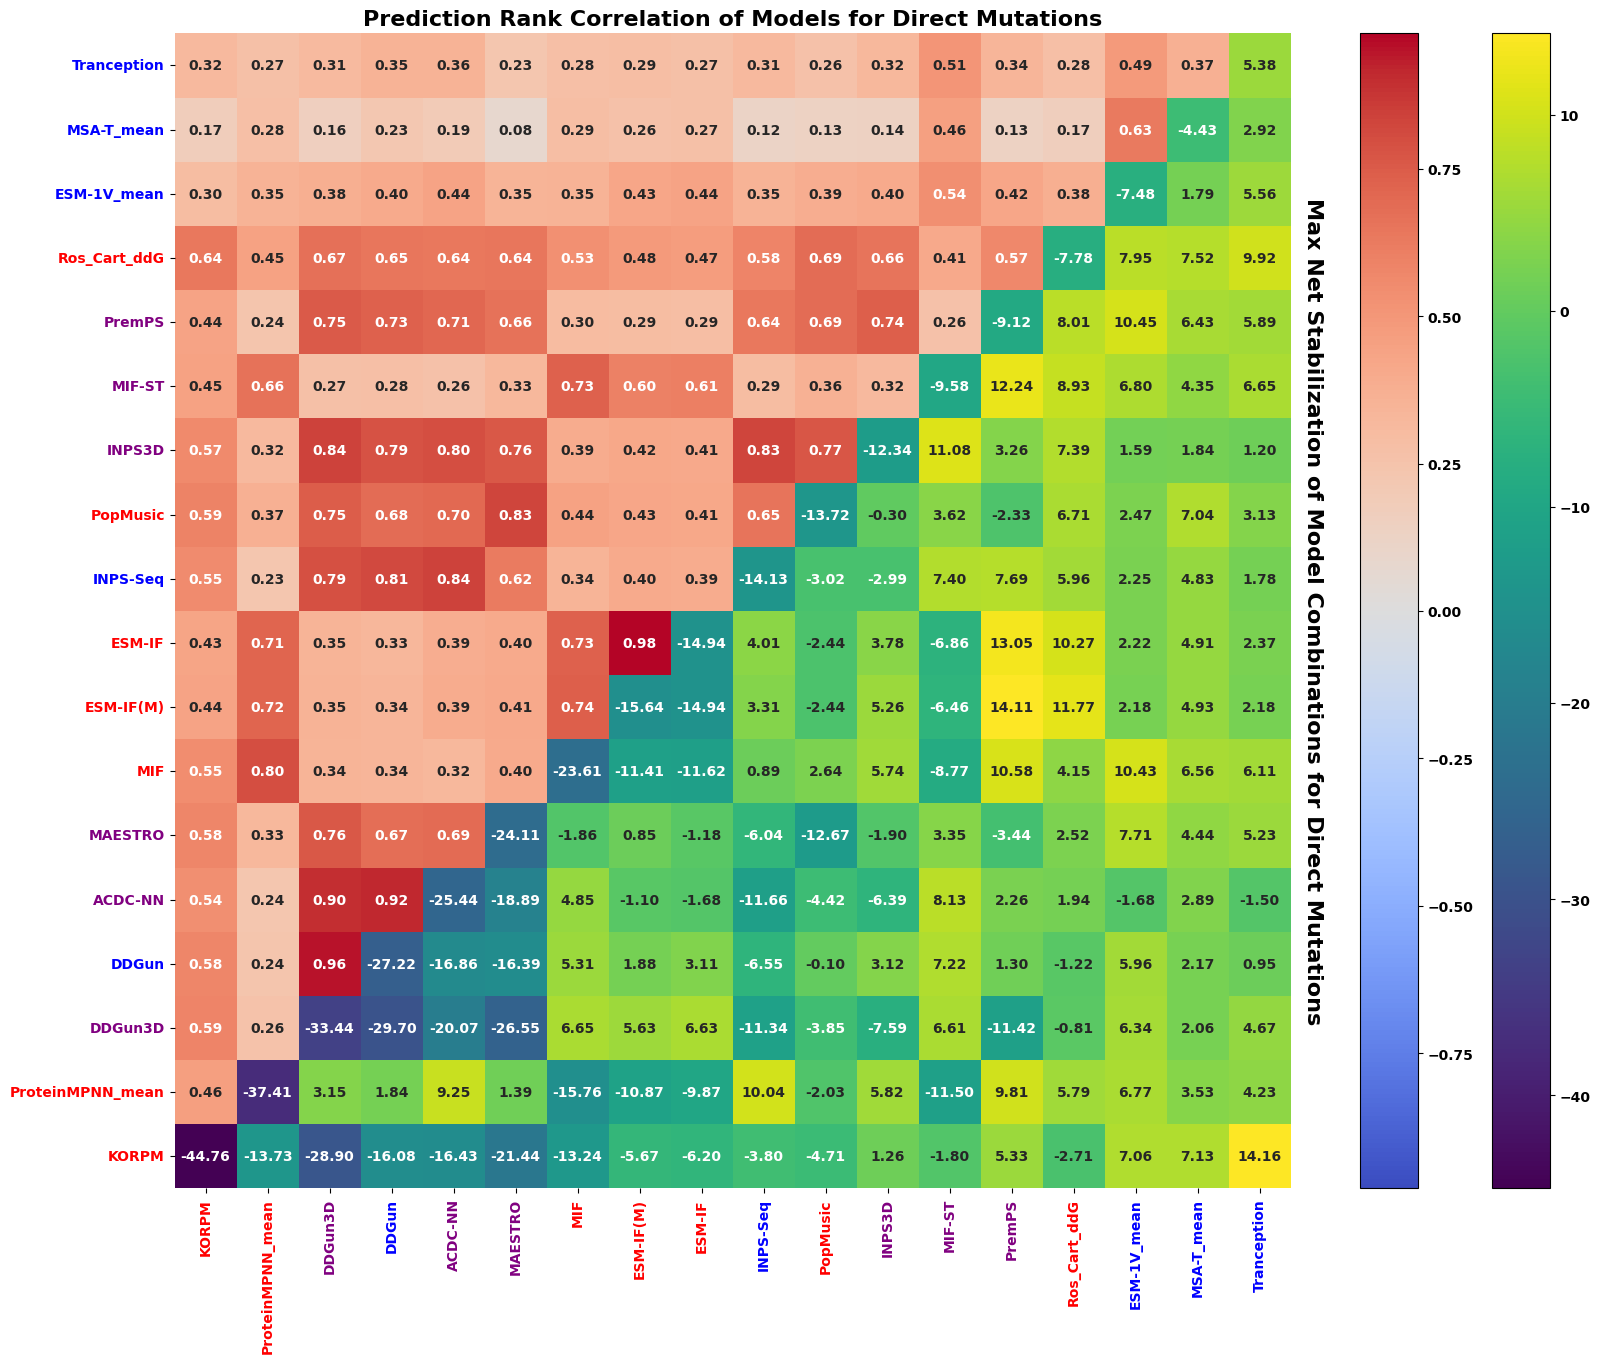

{'PopMusic', 'tranception_red', 'cartesian_ddg', 'ACDC-NN', 'esmif_monomer_full', 'esm1v_mean', 'DDGun', 'mifst', 'mif', 'korpm', 'esmif_multimer_full', 'INPS3D', 'MAESTRO', 'INPS-Seq', 'msa_transformer_mean', 'mpnn_mean', 'PremPS'}


model1  weight1                model2  weight2  \
rank                                                                 
1          tranception_red      1.0                 korpm      0.5   
2                   PremPS      1.0    esmif_monomer_full      1.0   
3                   PremPS      1.0   esmif_multimer_full      1.0   
4                   PremPS      1.0                 mifst      1.0   
5       esmif_monomer_full      1.0         cartesian_ddg      0.5   
6                    mifst      1.0                INPS3D      0.5   
7                   PremPS      1.0                   mif      1.0   
8               esm1v_mean      1.0                PremPS      0.5   
9                      mif      1.0            esm1v_mean      0.5   
10     esmif_multimer_full      1.0         cartesian_ddg      0.5   
11                INPS-Seq      1.0             mpnn_mean      1.0   
12           cartesian_ddg      1.0       tranception_red      1.0   
13                  PremPS      1.0             mpnn_mean      1.0   
14                 ACDC-NN      1.0             mpnn_mean      1.0   
15                   mifst      1.0         cartesian_ddg      0.5   
16                 ACDC-NN      1.0                 mifst      1.0   
17           cartesian_ddg      1.0                PremPS      0.5   
18              esm1v_mean      1.0         cartesian_ddg      0.5   
19              esm1v_mean      1.0               MAESTRO      0.5   
20                INPS-Seq      1.0                PremPS      1.0   
21           cartesian_ddg      1.0  msa_transformer_mean      0.2   
22                   mifst      1.0              INPS-Seq      0.5   
23           cartesian_ddg      1.0                INPS3D      0.5   
24                   mifst      1.0                 DDGun      0.5   
25                   korpm      1.0  msa_transformer_mean      1.0   
26              esm1v_mean      1.0                 korpm      1.0   
27    msa_transformer_mean      1.0              PopMusic      0.5   
28              esm1v_mean      1.0                 mifst      1.0   
29              esm1v_mean      1.0             mpnn_mean      0.5   
30                PopMusic      1.0         cartesian_ddg      1.0   

      net_stabilization      corr  
rank                               
1                14.164  0.320151  
2                14.106  0.293552  
3                13.046  0.288005  
4                12.242  0.264966  
5                11.774  0.484843  
6                11.080  0.315239  
7                10.575  0.302040  
8                10.446  0.423532  
9                10.429  0.352413  
10               10.274  0.474205  
11               10.036  0.234578  
12                9.924  0.281226  
13                9.812  0.239634  
14                9.252  0.235266  
15                8.929  0.406438  
16                8.127  0.262504  
17                8.007  0.569589  
18                7.953  0.380562  
19                7.712  0.350895  
20                7.694  0.638838  
21                7.523  0.166008  
22                7.399  0.293851  
23                7.395  0.655554  
24                7.221  0.280716  
25                7.130  0.173202  
26                7.056  0.297954  
27                7.040  0.131418  
28                6.802  0.540793  
29                6.766  0.354779  
30                6.711  0.686340

In [136]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 #'SOL_ACC': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'dir'
statistic = 'net_stabilization'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = model_combinations_heatmap(d2, db_ens, statistic, direction, upper, threshold=None)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

103    0.560359
Name: weighted_spearman, dtype: float64
103   -0.068779
Name: bias, dtype: float64


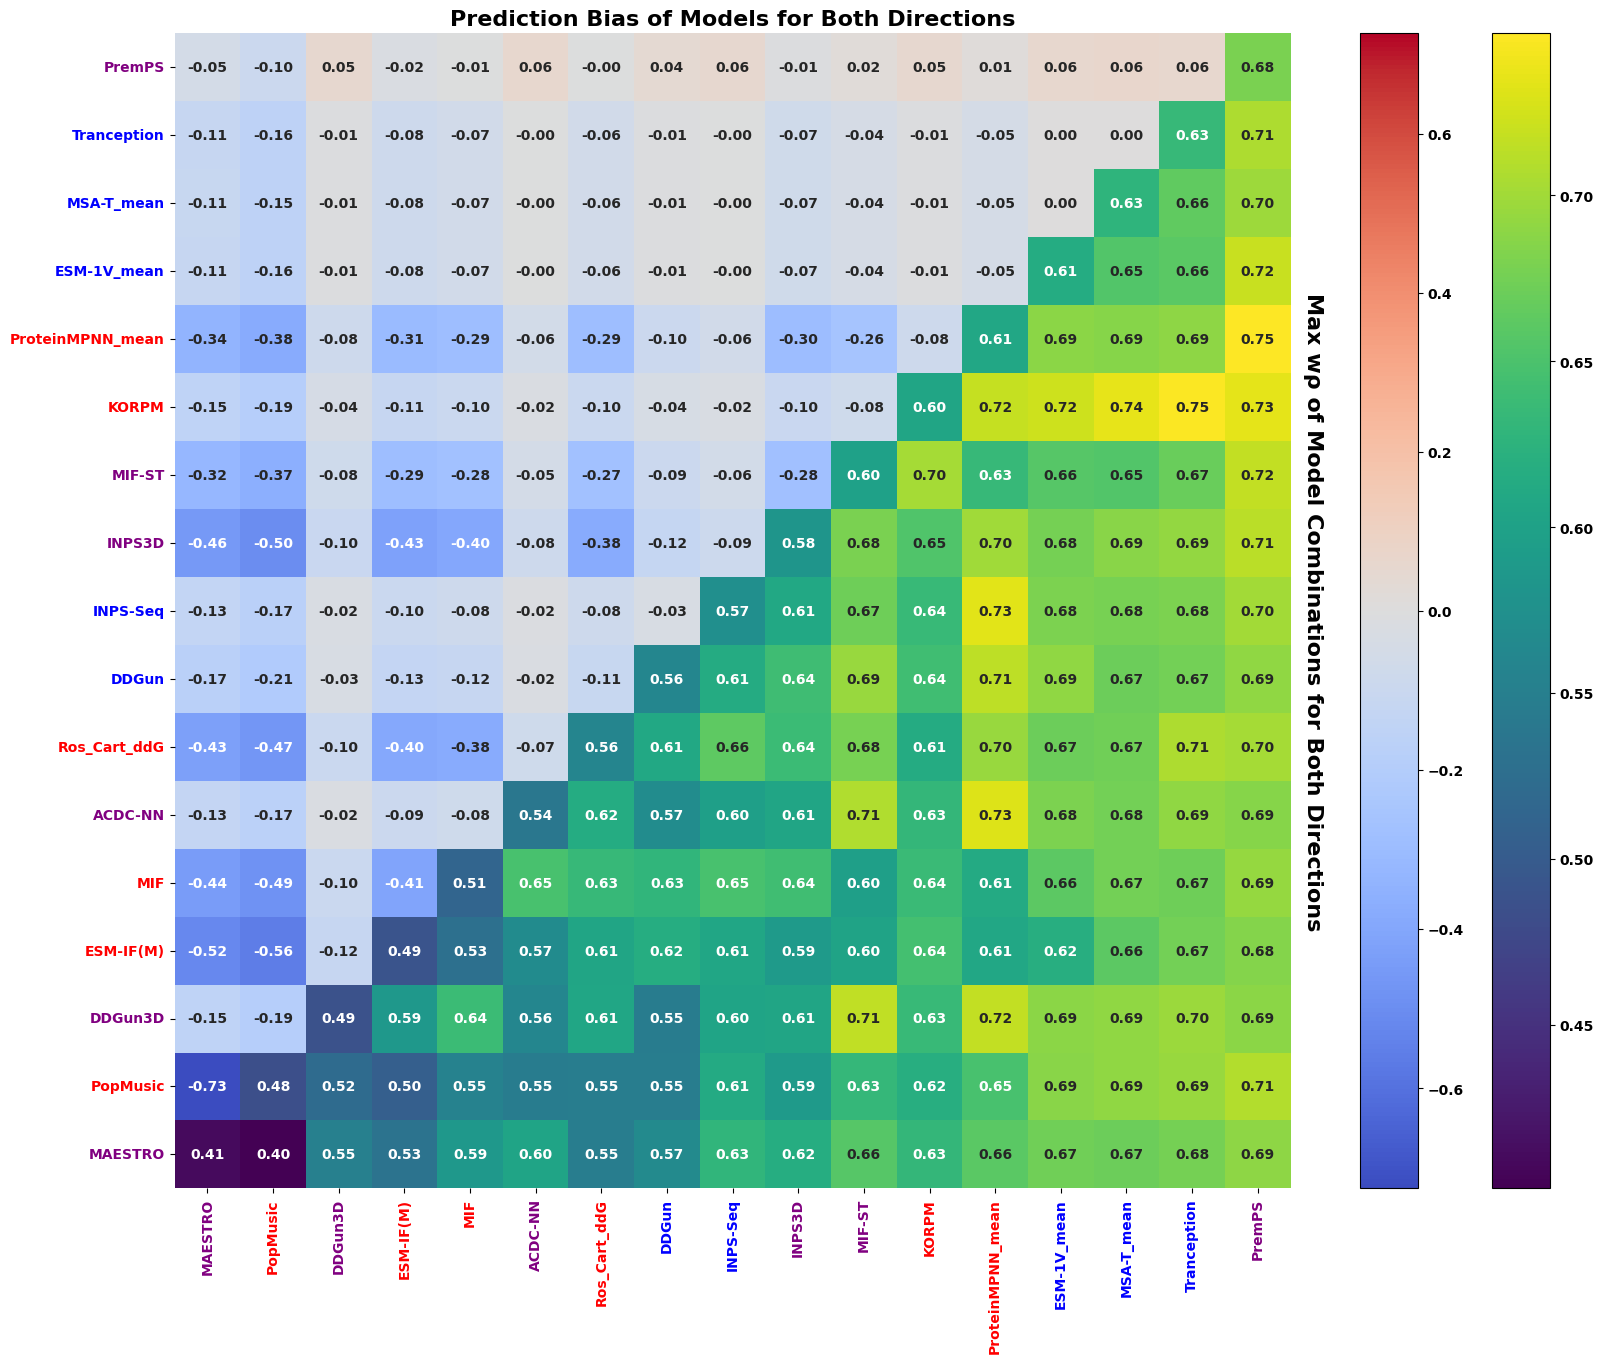

{'PopMusic', 'tranception_red', 'cartesian_ddg', 'ACDC-NN', 'DDGun', 'esm1v_mean', 'mifst', 'korpm', 'INPS3D', 'DDGun3D', 'mif', 'INPS-Seq', 'msa_transformer_mean', 'mpnn_mean', 'PremPS'}


model1  weight1                model2  weight2  \
rank                                                            
1              PremPS      1.0             mpnn_mean      1.0   
2     tranception_red      1.0                 korpm      0.5   
3               korpm      1.0  msa_transformer_mean      0.5   
4              PremPS      1.0                 korpm      1.0   
5            INPS-Seq      1.0             mpnn_mean      1.0   
6             ACDC-NN      1.0             mpnn_mean      1.0   
7          esm1v_mean      1.0                 korpm      1.0   
8              PremPS      1.0            esm1v_mean      1.0   
9               korpm      1.0             mpnn_mean      0.5   
10            DDGun3D      1.0             mpnn_mean      1.0   
11             PremPS      1.0                 mifst      1.0   
12            DDGun3D      1.0                 mifst      0.5   
13              DDGun      1.0             mpnn_mean      1.0   
14             PremPS      1.0                INPS3D      0.5   
15             PremPS      1.0              PopMusic      0.2   
16            ACDC-NN      1.0                 mifst      0.5   
17    tranception_red      1.0         cartesian_ddg      0.5   
18             PremPS      1.0       tranception_red      1.0   
19             PremPS      1.0         cartesian_ddg      1.0   
20              korpm      1.0                 mifst      1.0   
21             PremPS      1.0              INPS-Seq      0.5   
22             INPS3D      1.0             mpnn_mean      1.0   
23             PremPS      1.0  msa_transformer_mean      0.2   
24    tranception_red      1.0               DDGun3D      0.2   
25      cartesian_ddg      1.0             mpnn_mean      1.0   
26    tranception_red      1.0              PopMusic      0.2   
27              DDGun      1.0                 mifst      0.5   
28             PremPS      1.0                   mif      1.0   
29             INPS3D      1.0       tranception_red      1.0   
30              DDGun      1.0            esm1v_mean      1.0   

      weighted_spearman      corr  
rank                               
1              0.748832  0.607990  
2              0.746632  0.574449  
3              0.735930  0.511250  
4              0.734227  0.645873  
5              0.733583  0.592158  
6              0.729955  0.574202  
7              0.721820  0.569713  
8              0.719600  0.793368  
9              0.718412  0.578372  
10             0.717517  0.499714  
11             0.716987  0.653144  
12             0.714844  0.516232  
13             0.714370  0.558285  
14             0.712172  0.757647  
15             0.708636  0.534252  
16             0.707496  0.595616  
17             0.706212  0.576191  
18             0.705468  0.777396  
19             0.702569  0.657053  
20             0.702118  0.555394  
21             0.700079  0.850946  
22             0.698520  0.581779  
23             0.698127  0.744502  
24             0.696169  0.624111  
25             0.695075  0.641102  
26             0.694607  0.426681  
27             0.694508  0.589432  
28             0.693910  0.500871  
29             0.693040  0.685817  
30             0.691467  0.738425

In [87]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 #'SOL_ACC': 'red',
                 #'delta_kdh': 'blue',
                 #'delta_vol': 'blue',
                 #'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'weighted_spearman'
upper = 'bias'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = model_combinations_heatmap(d2, db_ens, statistic, direction, upper, threshold=None)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

106    0.560359
Name: weighted_spearman, dtype: float64


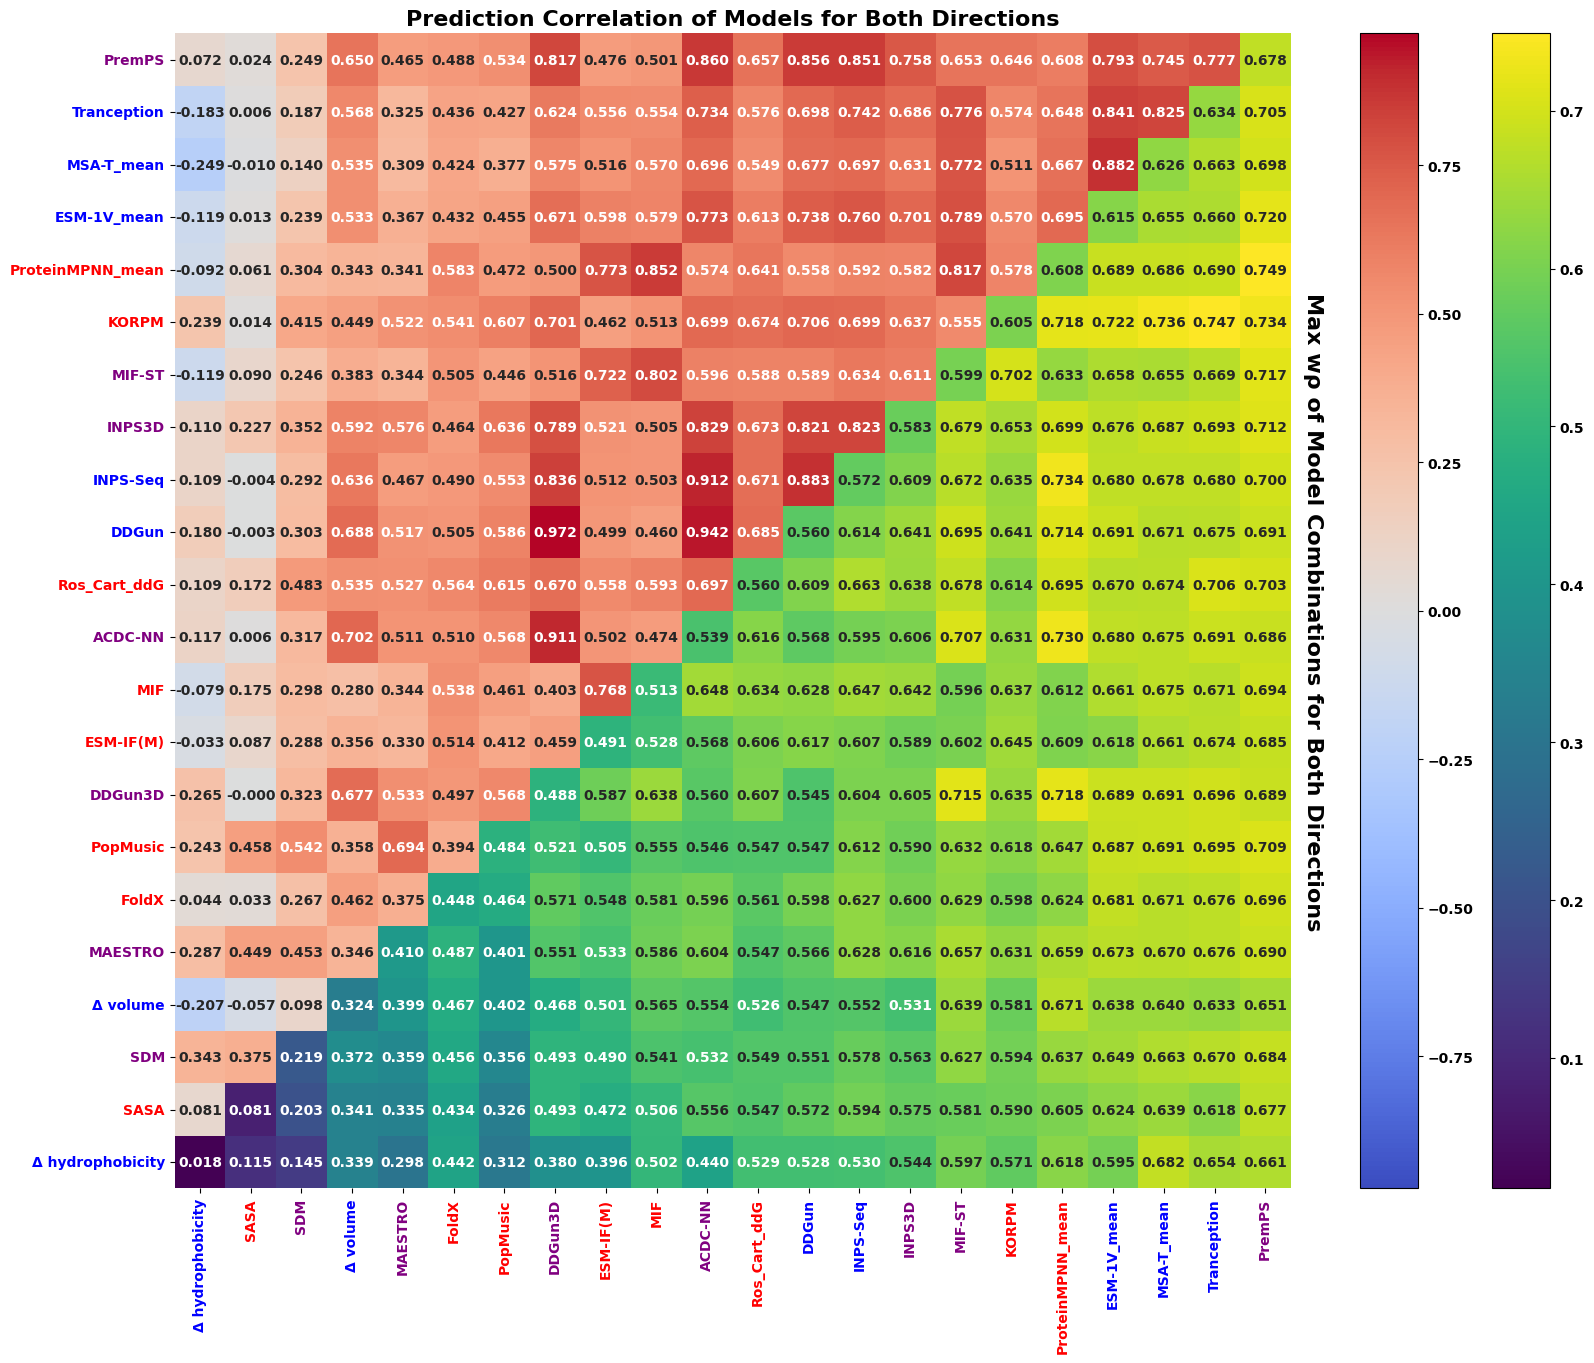

{'ACDC-NN', 'msa_transformer_mean', 'mif', 'INPS-Seq', 'PremPS', 'esm1v_mean', 'FoldX', 'cartesian_ddg', 'DDGun3D', 'tranception_red', 'mifst', 'korpm', 'mpnn_mean', 'INPS3D', 'PopMusic', 'DDGun'}


model1  weight1                model2  weight2  \
rank                                                            
1              PremPS      1.0             mpnn_mean      1.0   
2     tranception_red      1.0                 korpm      0.5   
3               korpm      1.0  msa_transformer_mean      0.5   
4              PremPS      1.0                 korpm      1.0   
5            INPS-Seq      1.0             mpnn_mean      1.0   
6             ACDC-NN      1.0             mpnn_mean      1.0   
7          esm1v_mean      1.0                 korpm      1.0   
8              PremPS      1.0            esm1v_mean      1.0   
9               korpm      1.0             mpnn_mean      0.5   
10            DDGun3D      1.0             mpnn_mean      1.0   
11             PremPS      1.0                 mifst      1.0   
12            DDGun3D      1.0                 mifst      0.5   
13              DDGun      1.0             mpnn_mean      1.0   
14             PremPS      1.0                INPS3D      0.5   
15             PremPS      1.0              PopMusic      0.2   
16            ACDC-NN      1.0                 mifst      0.5   
17    tranception_red      1.0         cartesian_ddg      0.5   
18             PremPS      1.0       tranception_red      1.0   
19             PremPS      1.0         cartesian_ddg      1.0   
20              korpm      1.0                 mifst      1.0   
21             PremPS      1.0              INPS-Seq      0.5   
22             INPS3D      1.0             mpnn_mean      1.0   
23             PremPS      1.0  msa_transformer_mean      0.2   
24    tranception_red      1.0               DDGun3D      0.2   
25             PremPS      1.0                 FoldX      0.5   
26      cartesian_ddg      1.0             mpnn_mean      1.0   
27    tranception_red      1.0              PopMusic      0.2   
28              DDGun      1.0                 mifst      0.5   
29             PremPS      1.0                   mif      1.0   
30             INPS3D      1.0       tranception_red      1.0   

      weighted_spearman      corr  
rank                               
1              0.748832  0.607990  
2              0.746632  0.574449  
3              0.735930  0.511250  
4              0.734227  0.645873  
5              0.733583  0.592158  
6              0.729955  0.574202  
7              0.721820  0.569713  
8              0.719600  0.793368  
9              0.718412  0.578372  
10             0.717517  0.499714  
11             0.716987  0.653144  
12             0.714844  0.516232  
13             0.714370  0.558285  
14             0.712172  0.757647  
15             0.708636  0.534252  
16             0.707496  0.595616  
17             0.706212  0.576191  
18             0.705468  0.777396  
19             0.702569  0.657053  
20             0.702118  0.555394  
21             0.700079  0.850946  
22             0.698520  0.581779  
23             0.698127  0.744502  
24             0.696169  0.624111  
25             0.695626  0.487964  
26             0.695075  0.641102  
27             0.694607  0.426681  
28             0.694508  0.589432  
29             0.693910  0.500871  
30             0.693040  0.685817

In [39]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'FoldX',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 'SDM': 'purple',
                 'SOL_ACC': 'red',
                 'delta_kdh': 'blue',
                 'delta_vol': 'blue',
                 'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'weighted_spearman'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = model_combinations_heatmap(d2, db_ens, statistic, direction, upper)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

112    0.850601
Name: mean_ndcg, dtype: float64


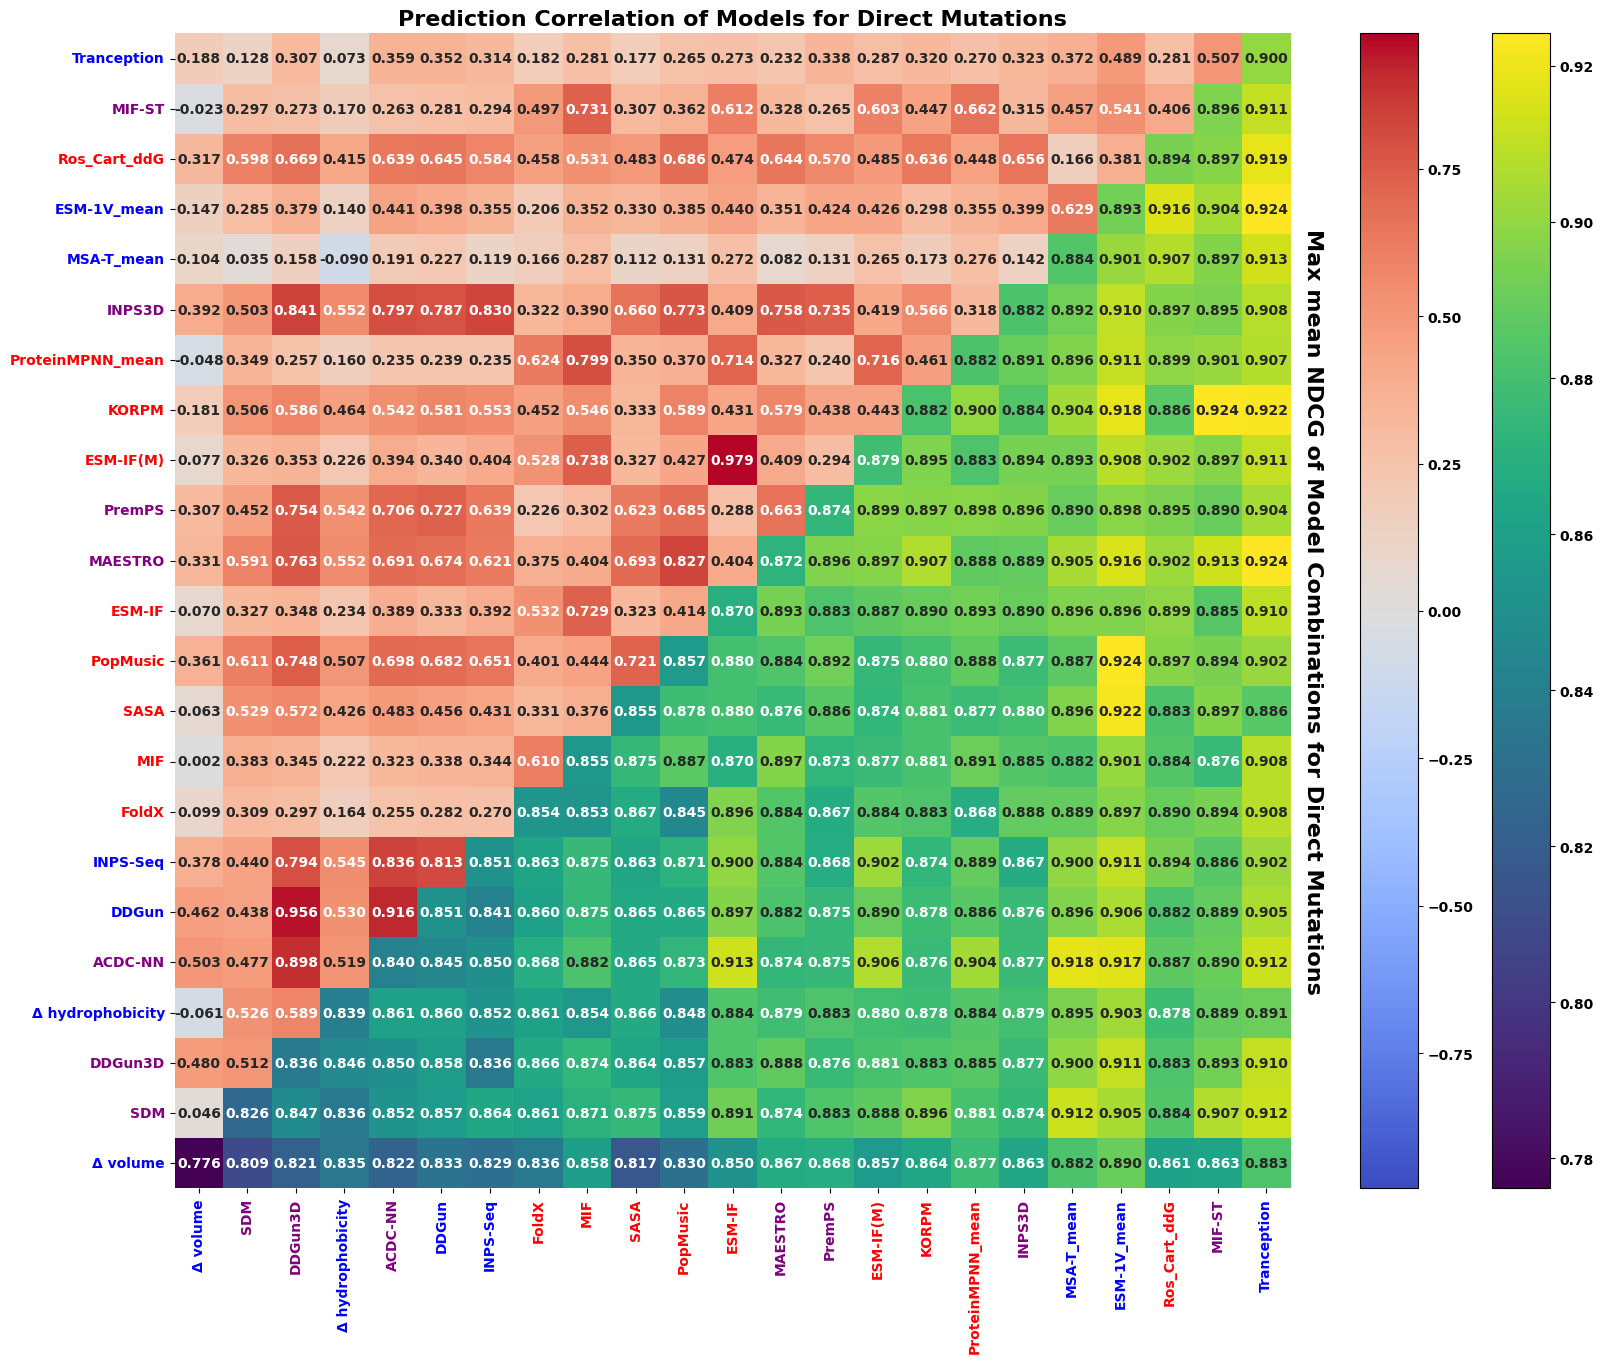

{'SOL_ACC', 'korpm', 'PopMusic', 'mif', 'INPS-Seq', 'FoldX', 'tranception_red', 'INPS3D', 'esmif_multimer_full', 'ACDC-NN', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'esmif_monomer_full', 'MAESTRO', 'cartesian_ddg', 'DDGun3D', 'mifst', 'SDM'}


model1  weight1                model2  weight2  mean_ndcg  \
rank                                                                           
1              esm1v_mean      1.0              PopMusic      0.2   0.924180   
2                   korpm      1.0                 mifst      0.5   0.924060   
3              esm1v_mean      1.0       tranception_red      0.2   0.923674   
4         tranception_red      1.0               MAESTRO      0.5   0.923666   
5         tranception_red      1.0                 korpm      0.2   0.922458   
6              esm1v_mean      1.0               SOL_ACC      0.2   0.922038   
7         tranception_red      1.0         cartesian_ddg      0.2   0.918531   
8              esm1v_mean      1.0                 korpm      1.0   0.918494   
9                 ACDC-NN      1.0  msa_transformer_mean      0.5   0.918101   
10                ACDC-NN      1.0            esm1v_mean      1.0   0.916773   
11          cartesian_ddg      1.0            esm1v_mean      1.0   0.916261   
12                MAESTRO      1.0            esm1v_mean      1.0   0.915935   
13        tranception_red      1.0  msa_transformer_mean      0.2   0.913493   
14                MAESTRO      1.0                 mifst      0.5   0.912716   
15    esmif_multimer_full      1.0               ACDC-NN      0.5   0.912680   
16        tranception_red      1.0               ACDC-NN      0.2   0.912320   
17                    SDM      1.0       tranception_red      1.0   0.912114   
18                    SDM      1.0  msa_transformer_mean      1.0   0.912037   
19             esm1v_mean      1.0               DDGun3D      0.5   0.910721   
20             esm1v_mean      1.0             mpnn_mean      0.2   0.910705   
21        tranception_red      1.0    esmif_monomer_full      0.2   0.910657   
22             esm1v_mean      1.0              INPS-Seq      0.2   0.910556   
23                  mifst      1.0       tranception_red      1.0   0.910533   
24        tranception_red      1.0               DDGun3D      0.2   0.910309   
25             esm1v_mean      1.0                INPS3D      0.5   0.909976   
26        tranception_red      1.0   esmif_multimer_full      0.2   0.909616   
27        tranception_red      1.0                   mif      0.2   0.908137   
28        tranception_red      1.0                 FoldX      0.5   0.908081   
29             esm1v_mean      1.0    esmif_monomer_full      0.5   0.908071   
30        tranception_red      1.0                INPS3D      0.5   0.907648   

          corr  
rank            
1     0.385235  
2     0.446616  
3     0.488910  
4     0.231986  
5     0.320151  
6     0.330405  
7     0.281226  
8     0.297954  
9     0.191434  
10    0.441381  
11    0.380562  
12    0.350895  
13    0.372254  
14    0.327985  
15    0.389352  
16    0.359221  
17    0.127519  
18    0.035479  
19    0.379248  
20    0.354779  
21    0.286835  
22    0.354999  
23    0.506879  
24    0.306703  
25    0.398627  
26    0.272690  
27    0.280740  
28    0.181955  
29    0.426336  
30    0.323412

In [150]:
#hybrid = ['mifst', 'PremPS', 'ACDC-NN', 'DDGun3D', 'INPS3D', 'SAAFEC-Seq', 'SDM', 'DUET', 'Dynamut', 'MAESTRO', 'I-Mutant3.0']
#evolutionary = ['INPS-Seq', 'tranception', 'msa_transformer', 'ACDC-NN-Seq', 'DDGun', 'I-Mutant3.0-Seq', 'esm1v', 'SAAFEC-Seq']
#structural = ['cartesian_ddg', 'esmif', 'mpnn', 'mif', 'monomer_ddg', 'FoldX', 'ThermoNet', 'mCSM', 'MuPro', 'PopMusic' 'SOL_ACC', KORPMD]

{'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'FoldX',
'tranception_red', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'}


custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 'SDM': 'purple',
                 'SOL_ACC': 'red',
                 'delta_kdh': 'blue',
                 'delta_vol': 'blue',
                 'abs_ASA': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 #'esmif_monomer': 'red',
                 'esmif_monomer_full': 'red',
                 'esmif_multimer_full': 'red',
                 #'esmif_monomer_full': 'red', 
                 'korpm': 'red',
                 #'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'red',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_30_00': 'red',
                 'mpnn_mean': 'red',
                 #'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'mean_nd'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('$' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('$')[0])>=80]
d2['ausrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('$')[0])>=90]
d2['ausrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = model_combinations_heatmap(d2, db_ens, statistic, direction, upper)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out.to_csv('../../zeroshot suppl/supp_table_ndcg.csv')
out

In [67]:
d1

n  \
direction model_type   model                                 class          
combined  evolutionary ACDC-NN + ACDC-NN-Seq * 0.2                  922.0   
                       ACDC-NN + ACDC-NN-Seq * 0.5                  922.0   
                       ACDC-NN + ACDC-NN-Seq * 1                    922.0   
                       ACDC-NN + DDGun * 0.2                        868.0   
                       ACDC-NN + DDGun * 0.5                        868.0   
...                                                                   ...   
inv       structural   tranception_red + mpnn_30_noise * 0.5          0.0   
                       tranception_red + mpnn_30_noise * 1            0.0   
                       tranception_red + mpnn_mean * 0.2            460.0   
                       tranception_red + mpnn_mean * 0.5            460.0   
                       tranception_red + mpnn_mean * 1              460.0   

                                                                       tp  \
direction model_type   model                                 class          
combined  evolutionary ACDC-NN + ACDC-NN-Seq * 0.2                  363.0   
                       ACDC-NN + ACDC-NN-Seq * 0.5                  363.0   
                       ACDC-NN + ACDC-NN-Seq * 1                    361.0   
                       ACDC-NN + DDGun * 0.2                        348.0   
                       ACDC-NN + DDGun * 0.5                        353.0   
...                                                                   ...   
inv       structural   tranception_red + mpnn_30_noise * 0.5          NaN   
                       tranception_red + mpnn_30_noise * 1            NaN   
                       tranception_red + mpnn_mean * 0.2            369.0   
                       tranception_red + mpnn_mean * 0.5            367.0   
                       tranception_red + mpnn_mean * 1              358.0   

                                                                      fp  \
direction model_type   model                                 class         
combined  evolutionary ACDC-NN + ACDC-NN-Seq * 0.2                  95.0   
                       ACDC-NN + ACDC-NN-Seq * 0.5                  96.0   
                       ACDC-NN + ACDC-NN-Seq * 1                    96.0   
                       ACDC-NN + DDGun * 0.2                        84.0   
                       ACDC-NN + DDGun * 0.5                        80.0   
...                                                                  ...   
inv       structural   tranception_red + mpnn_30_noise * 0.5         NaN   
                       tranception_red + mpnn_30_noise * 1           NaN   
                       tranception_red + mpnn_mean * 0.2            57.0   
                       tranception_red + mpnn_mean * 0.5            53.0   
                       tranception_red + mpnn_mean * 1              46.0   

                                                                       tn  \
direction model_type   model                                 class          
combined  evolutionary ACDC-NN + ACDC-NN-Seq * 0.2                  368.0   
                       ACDC-NN + ACDC-NN-Seq * 0.5                  367.0   
                       ACDC-NN + ACDC-NN-Seq * 1                    367.0   
                       ACDC-NN + DDGun * 0.2                        352.0   
                       ACDC-NN + DDGun * 0.5                        356.0   
...                                                                   ...   
inv       structural   tranception_red + mpnn_30_noise * 0.5          NaN   
                       tranception_red + mpnn_30_noise * 1            NaN   
                       tranception_red + mpnn_mean * 0.2             18.0   
                       tranception_red + mpnn_mean * 0.5             22.0   
                       tranception_red + mpnn_mean * 1               29.0   

                                                                      fn  \
d

In [140]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['direction', 'model_type', 'model'])
rand

class      n     tp     fp     tn     fn  \
direction model_type model                                              
combined  NaN        random    NaN  922.0  236.0  248.0  215.0  223.0   
dir       NaN        random    NaN  461.0   40.0  208.0  180.0   33.0   
inv       NaN        random    NaN  461.0  196.0   40.0   35.0  190.0   

                             sensitivity  specificity  precision  \
direction model_type model                                         
combined  NaN        random     0.514161     0.464363   0.487603   
dir       NaN        random     0.547945     0.463918   0.161290   
inv       NaN        random     0.507772     0.466667   0.830508   

                             pred_positives_ratio  ...  2.12x_recovery  \
direction model_type model                         ...                   
combined  NaN        random              1.054466  ...        0.997821   
dir       NaN        random              3.397260  ...        0.465753   
inv       NaN        random              0.611399  ...        1.000000   

                             2.25x_recovery  2.38x_recovery  2.52x_recovery  \
direction model_type model                                                    
combined  NaN        random        0.997821        0.997821        0.997821   
dir       NaN        random        0.479452        0.493151        0.493151   
inv       NaN        random        1.000000        1.000000        1.000000   

                             2.67x_recovery  2.83x_recovery  3.0x_recovery  \
direction model_type model                                                   
combined  NaN        random        1.000000        1.000000       1.000000   
dir       NaN        random        0.534247        0.534247       0.575342   
inv       NaN        random        1.000000        1.000000       1.000000   

                                aumrc  antisymmetry      bias  
direction model_type model                                     
combined  NaN        random  0.331935      0.149184  0.008156  
dir       NaN        random  0.147005           NaN       NaN  
inv       NaN        random  0.459941           NaN       NaN  

[3 rows x 196 columns]

In [141]:
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['direction', 'model_type', 'model'])

In [142]:
dr.loc[('dir', 'evolutionary', 'esm1v_mean'), :].head(30)

class                          NaN
n                       461.000000
tp                       23.000000
fp                       25.000000
tn                      363.000000
fn                       50.000000
sensitivity               0.315068
specificity               0.935567
precision                 0.479167
pred_positives_ratio      0.657534
accuracy                  0.837310
f1_score                  0.380165
MCC                       0.299588
auroc                     0.718737
auprc                     0.389893
n_stable                 73.000000
ndcg                      0.957162
mean_ndcg                 0.892827
weighted_ndcg             0.904401
spearman                  0.428947
mean_spearman             0.358851
weighted_spearman         0.354731
mean_auprc                0.564168
weighted_auprc            0.527023
0$                        0.158351
1$                        0.154964
2$                        0.155340
3$                        0.154412
4$                  

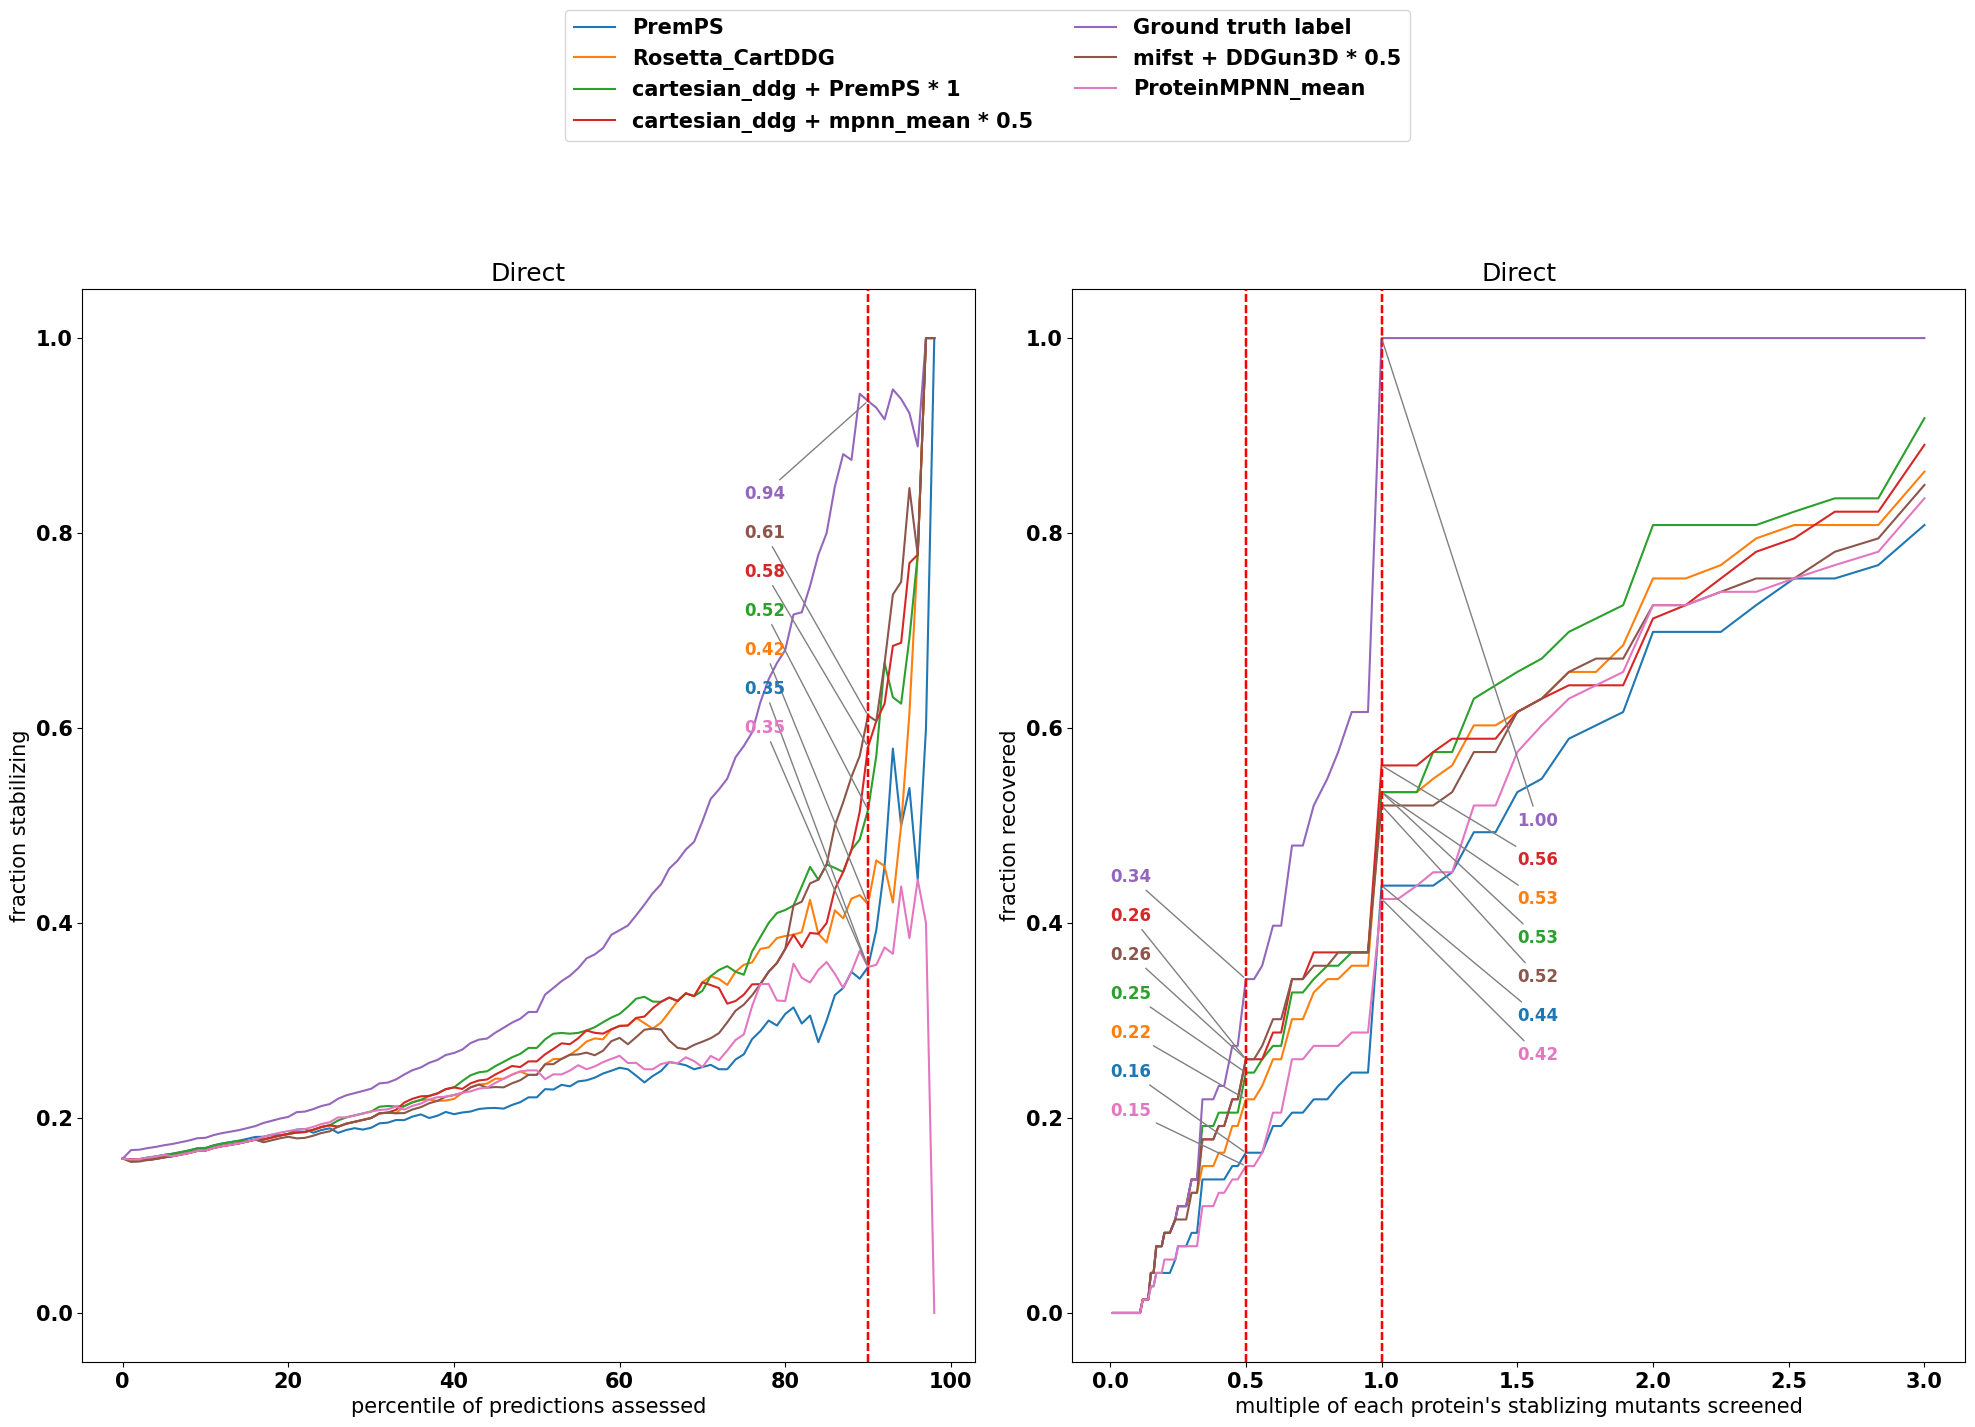

In [149]:
recovery_curves(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'cartesian_ddg + PremPS * 1', 'mifst + DDGun3D * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'ddG'], #'esm1v_mean', 'PremPS', 'korpm', 'ddG', 'random', 'DDGun3D', 'INPS3D'
    percentile_labels=[90], x_recovery_labels=[0.5, 1], text_offset=(0.5, 0.1), spacing=0.04, directions=['dir'])

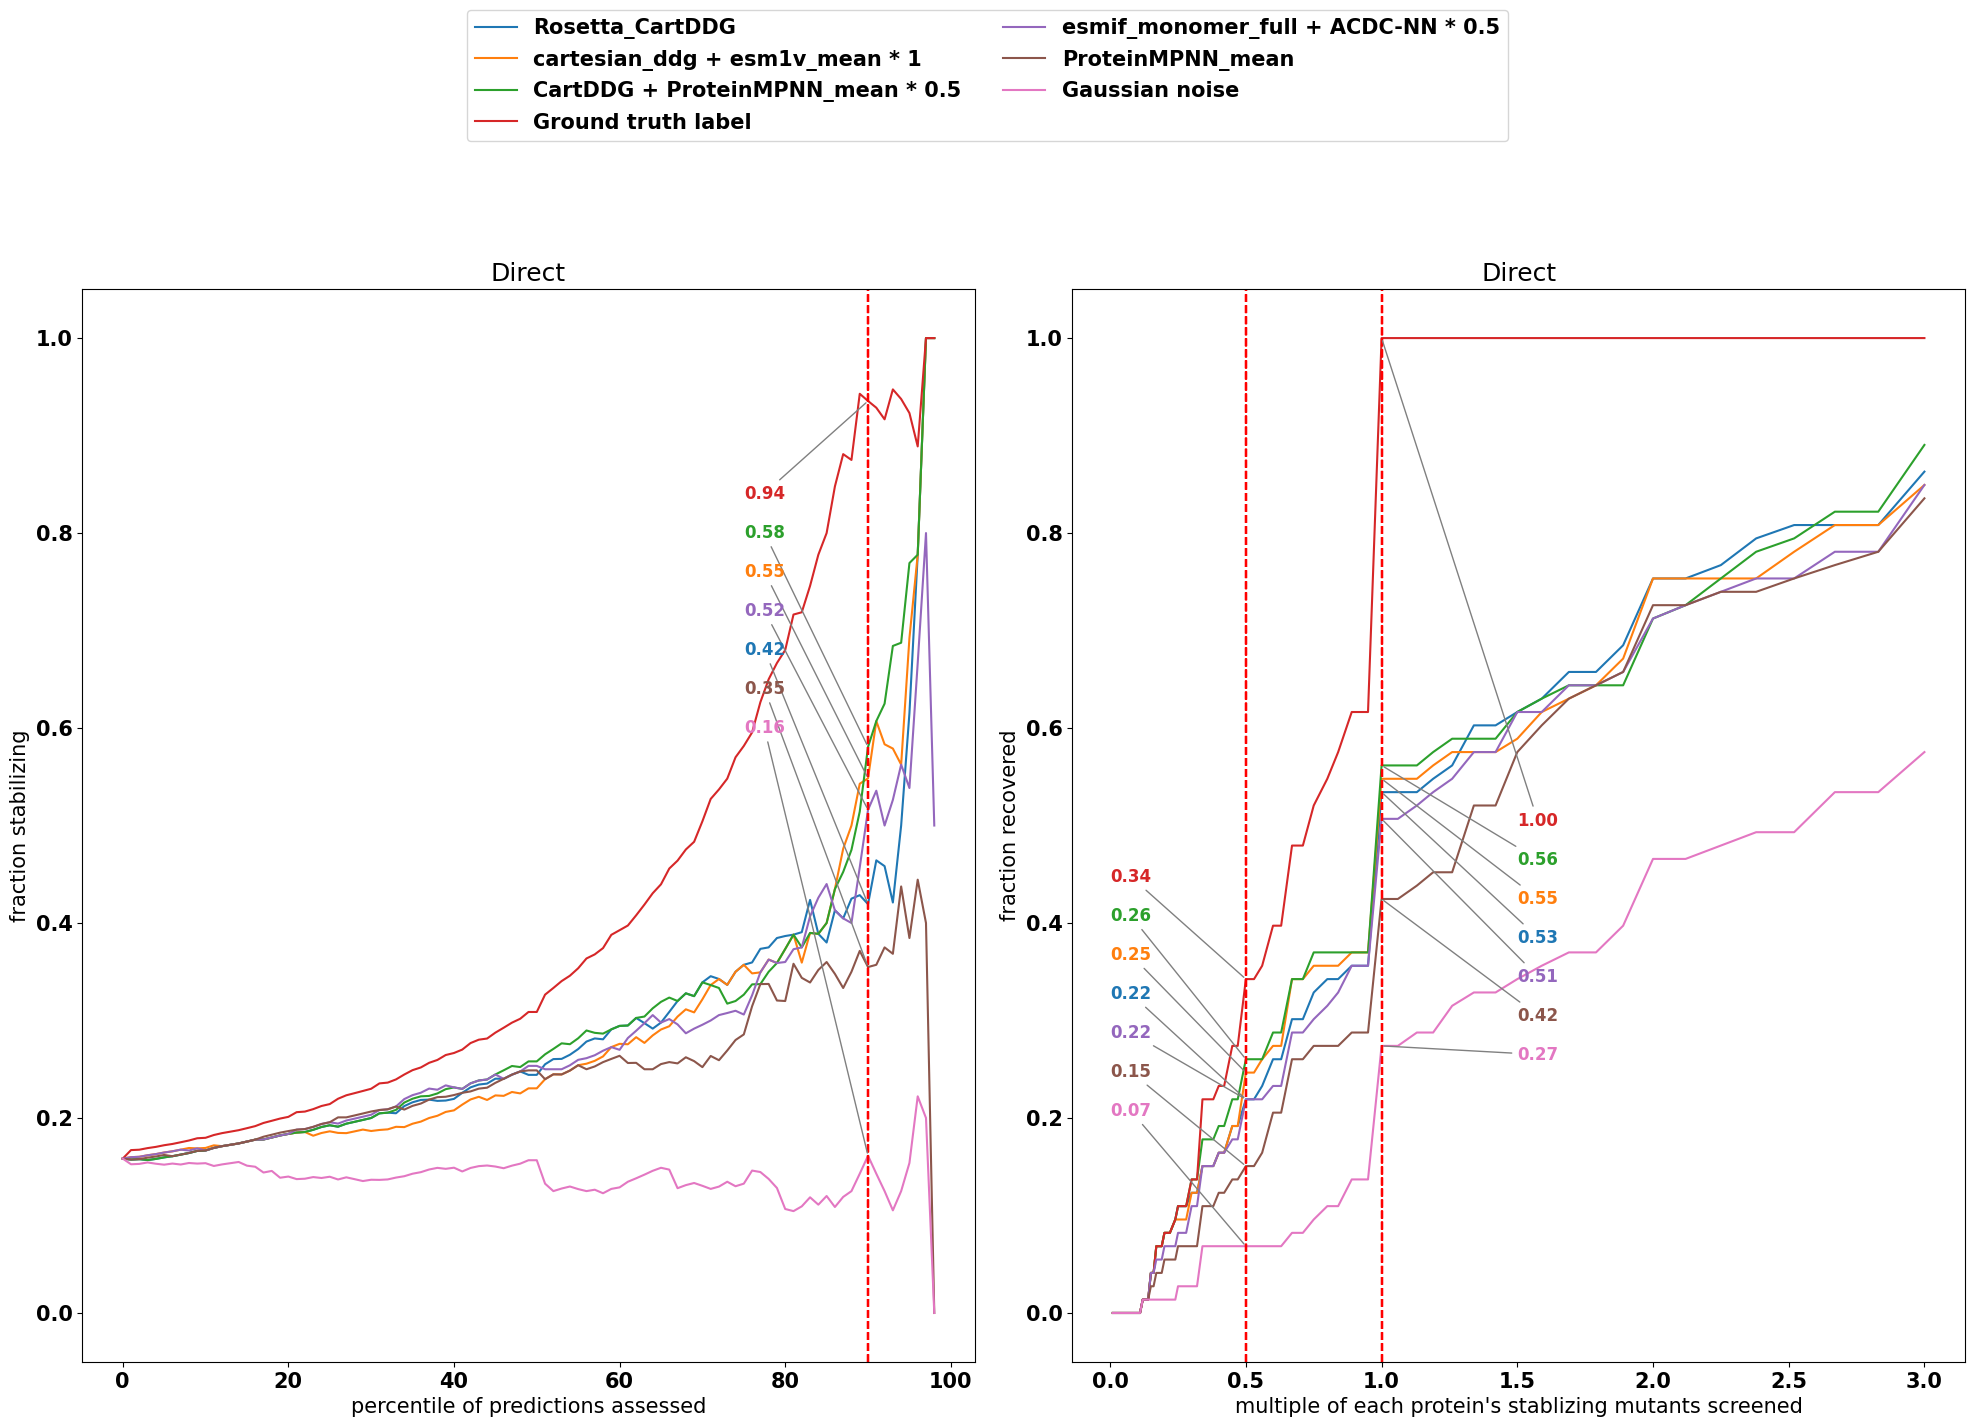

In [155]:
recovery_curves(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'cartesian_ddg + esm1v_mean * 1', 'esmif_monomer_full + ACDC-NN * 0.5', 'mpnn_mean', 'cartesian_ddg', 'ddG', 'random'], #'esm1v_mean', 'PremPS', 'korpm', 'ddG', 'random', 'DDGun3D', 'INPS3D'
    percentile_labels=[90], x_recovery_labels=[0.5, 1], text_offset=(0.5, 0.1), spacing=0.04, directions=['dir'])

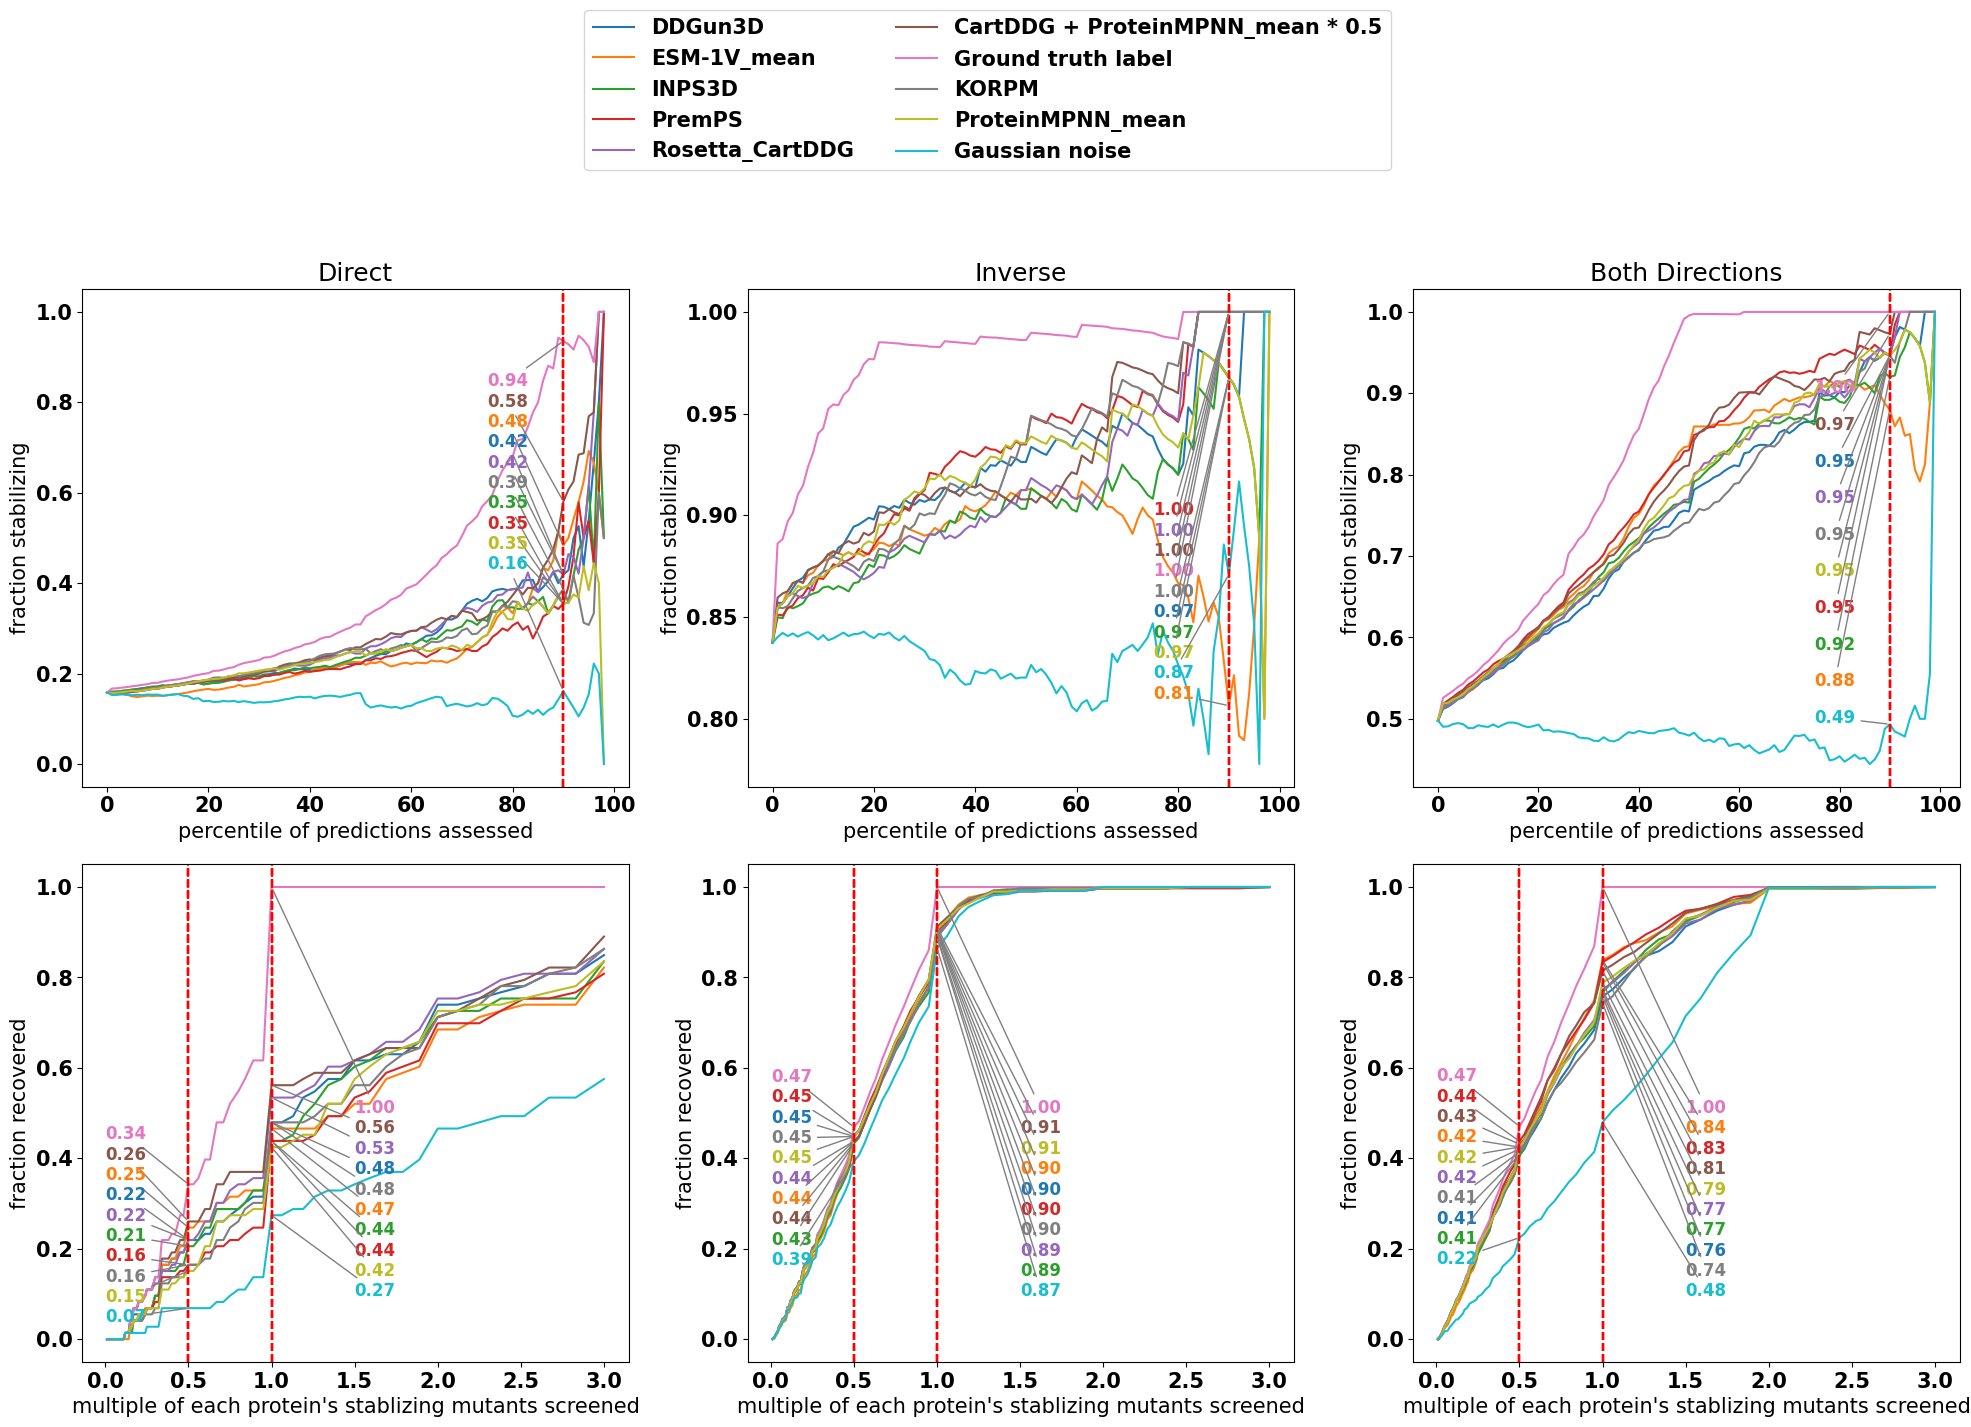

In [118]:
recovery_curves(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'INPS3D', 'DDGun3D', 'esm1v_mean', 'cartesian_ddg', 'korpm', 'ddG', 'random'], #'esm1v_mean', 'PremPS', 'korpm', 'ddG', 'random', 'DDGun3D', 'INPS3D'
    percentile_labels=[90], x_recovery_labels=[0.5, 1], text_offset=(0.5, 0.1), spacing=0.045, directions=['dir', 'inv'])

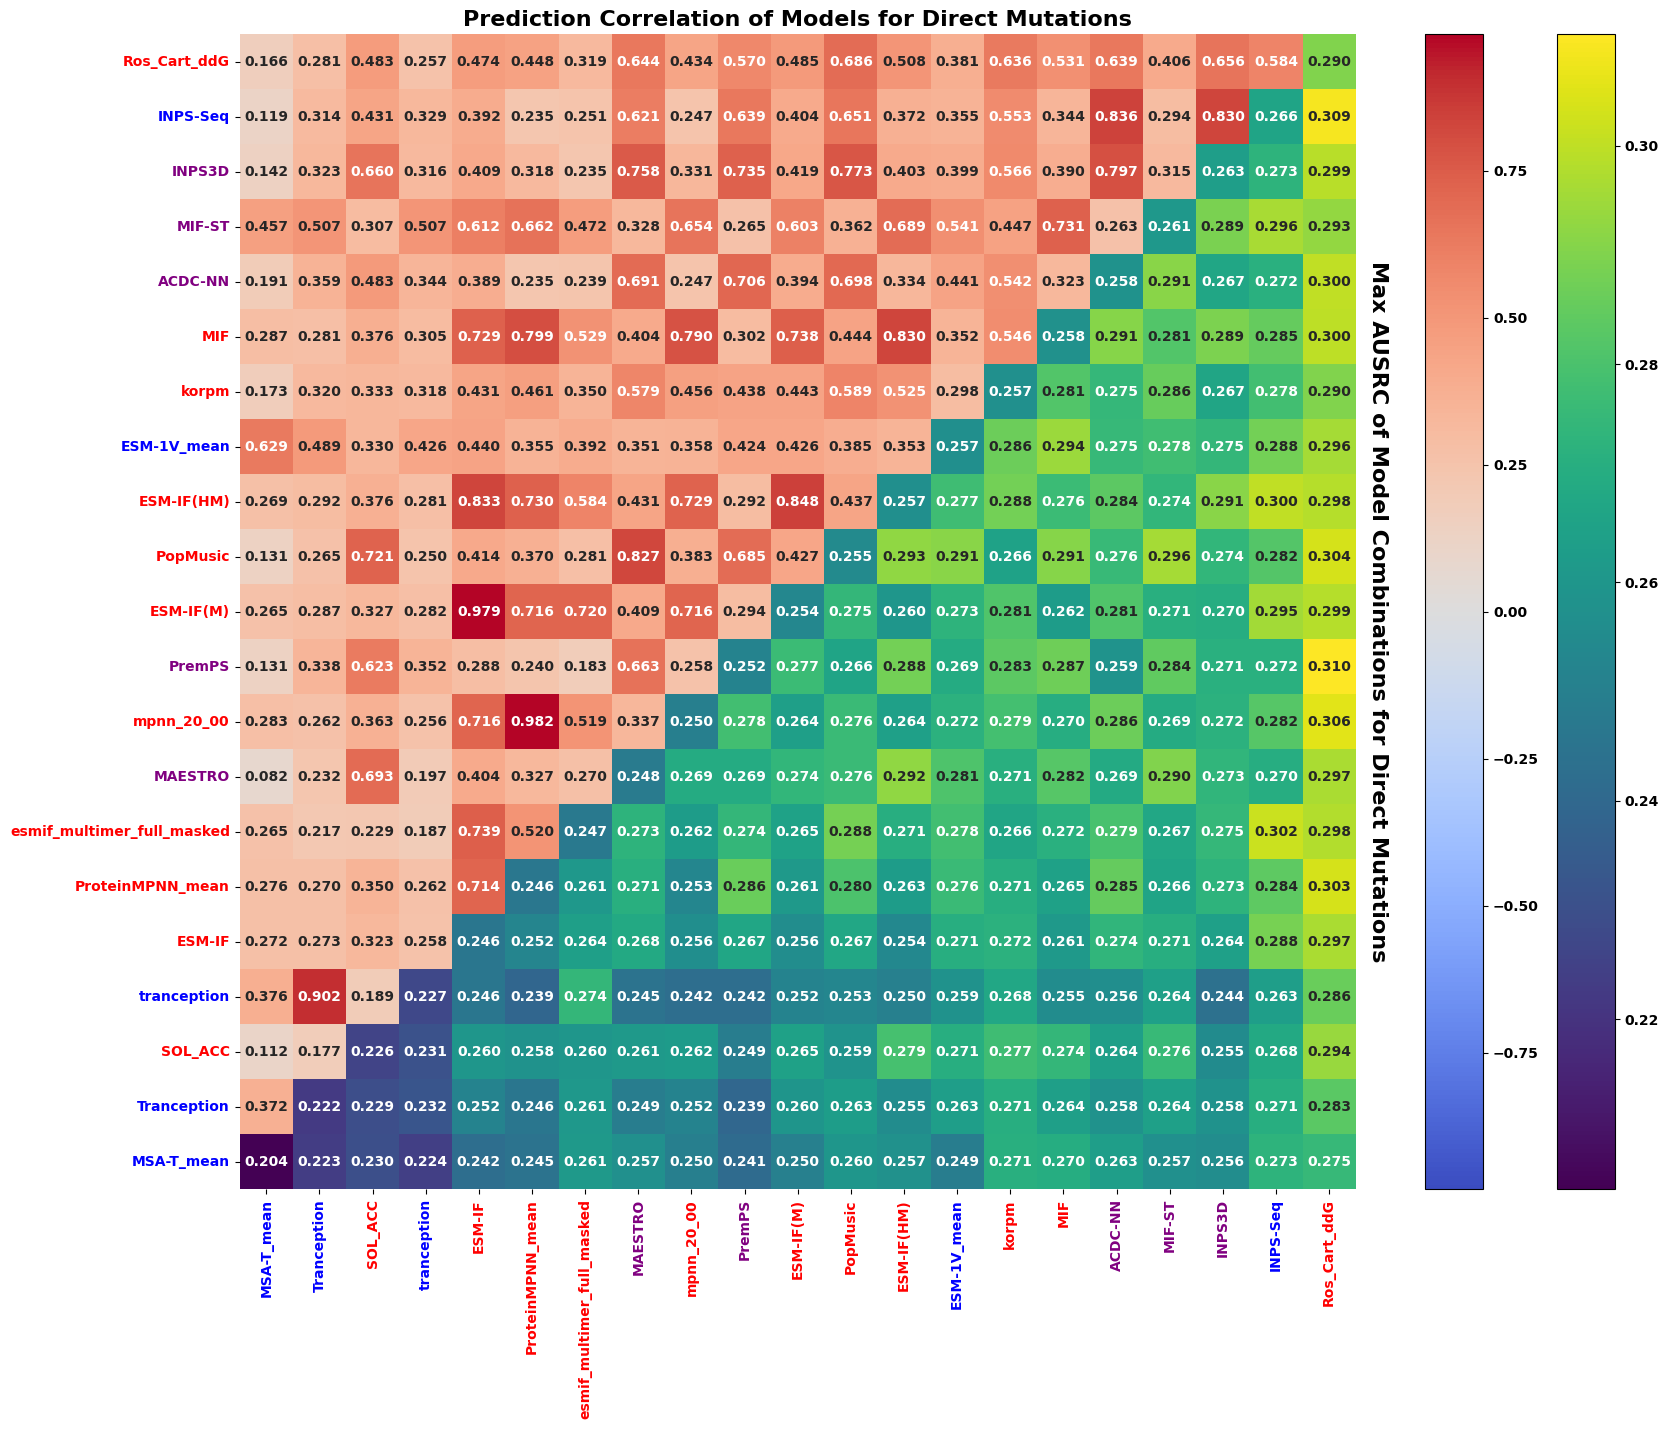

{'esm1v_mean', 'esmif_monomer', 'INPS3D', 'mifst', 'cartesian_ddg', 'ACDC-NN', 'esmif_multimer_full_masked', 'mpnn_mean', 'esmif_monomer_full', 'SOL_ACC', 'esmif_multimer_full', 'PopMusic', 'MAESTRO', 'PremPS', 'mif', 'mpnn_20_00', 'INPS-Seq'}


model1  weight1                      model2  weight2  \
rank                                                                     
1                 PremPS      1.0               cartesian_ddg      1.0   
2          cartesian_ddg      1.0                    INPS-Seq      0.5   
3          cartesian_ddg      1.0                  mpnn_20_00      0.5   
4          cartesian_ddg      1.0                    PopMusic      0.5   
5          cartesian_ddg      1.0                   mpnn_mean      0.5   
6               INPS-Seq      1.0  esmif_multimer_full_masked      0.5   
7               INPS-Seq      1.0               esmif_monomer      1.0   
8          cartesian_ddg      1.0                     ACDC-NN      0.5   
9          cartesian_ddg      1.0                         mif      0.2   
10         cartesian_ddg      1.0                      INPS3D      0.5   
11         cartesian_ddg      1.0          esmif_monomer_full      0.5   
12         cartesian_ddg      1.0               esmif_monomer      0.2   
13         cartesian_ddg      1.0  esmif_multimer_full_masked      0.5   
14         cartesian_ddg      1.0                     MAESTRO      0.5   
15         cartesian_ddg      1.0         esmif_multimer_full      0.5   
16              INPS-Seq      1.0                       mifst      0.5   
17         cartesian_ddg      1.0                  esm1v_mean      0.2   
18              PopMusic      1.0                       mifst      1.0   
19    esmif_monomer_full      1.0                    INPS-Seq      0.5   
20                   mif      1.0                  esm1v_mean      0.5   
21         cartesian_ddg      1.0                     SOL_ACC      0.2   
22         cartesian_ddg      1.0                       mifst      0.2   
23              PopMusic      1.0               esmif_monomer      1.0   
24         esmif_monomer      1.0                     MAESTRO      0.5   
25         esmif_monomer      1.0                      INPS3D      0.5   
26              PopMusic      1.0                  esm1v_mean      1.0   
27               ACDC-NN      1.0                       mifst      1.0   
28               ACDC-NN      1.0                         mif      1.0   
29              PopMusic      1.0                         mif      1.0   
30         cartesian_ddg      1.0               cartesian_ddg      0.0   

         ausrc      corr  
rank                      
1     0.310211  0.569589  
2     0.308807  0.583659  
3     0.305529  0.433732  
4     0.303533  0.686340  
5     0.303288  0.447594  
6     0.301620  0.250837  
7     0.300278  0.372338  
8     0.300221  0.639492  
9     0.299806  0.531008  
10    0.298807  0.655554  
11    0.298550  0.484843  
12    0.298226  0.508268  
13    0.298206  0.318781  
14    0.296810  0.643816  
15    0.296712  0.474205  
16    0.296242  0.293851  
17    0.296098  0.380562  
18    0.295978  0.362126  
19    0.295346  0.404000  
20    0.294287  0.352413  
21    0.294035  0.482826  
22    0.292935  0.406438  
23    0.292686  0.436719  
24    0.292468  0.431204  
25    0.291480  0.403168  
26    0.291407  0.385235  
27    0.291284  0.262504  
28    0.291197  0.322828  
29    0.290842  0.444223  
30    0.290207  1.000000

In [120]:
'INPS-Seq', 'PremPS', 'mif', 'esm1v_mean', 'esmif_monomer_full', 'KORPMD', 'mpnn_mean', 'msa_transformer_mean', 'tranception_red', 
'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'esmif_monomer', 'CartddgD', 'SDM', 'tranception', 'esmif_multimer_full', 'ACDC-NN', 'cartesian_ddg'

custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 #'DDGun': 'blue',
                 #'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 'SOL_ACC': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 'tranception': 'blue',
                 'esmif_monomer': 'red',
                 'esmif_multimer_full': 'red',
                 'esmif_monomer_full': 'red',
                 'korpm': 'red',
                 'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'blue',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_20_00': 'red',
                 'mpnn_mean': 'red',
                 'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'dir'
statistic = 'ausrc'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = model_combinations_heatmap(d2, db_preds, statistic, direction, upper)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out

205    0.573686
Name: weighted_MAP, dtype: float64


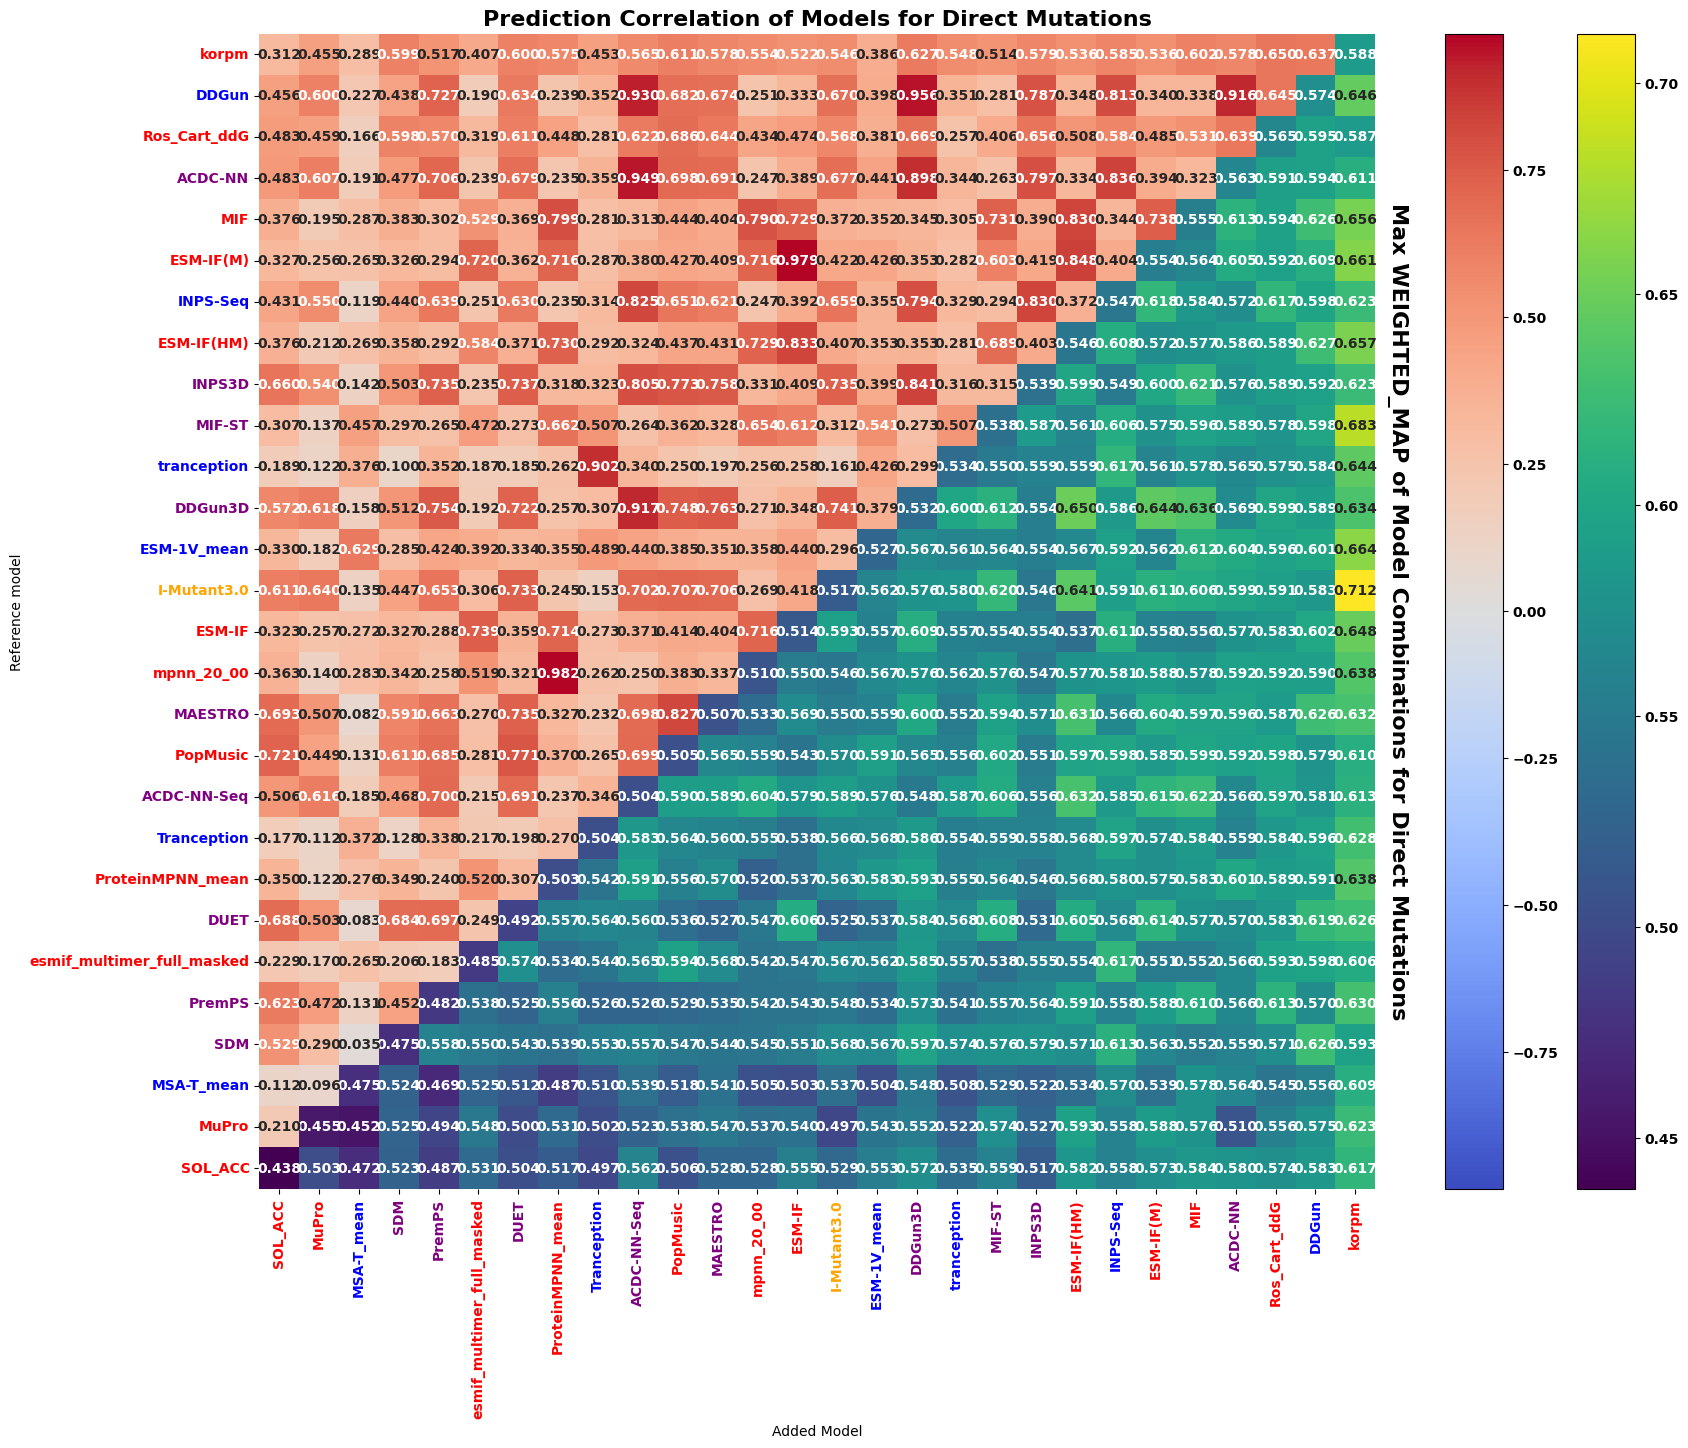

{'DUET', 'INPS3D', 'INPS-Seq', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 'mpnn_mean', 'tranception_red', 'MuPro', 'MAESTRO', 'mifst', 'korpm', 'esmif_monomer', 'SDM', 'tranception', 'mpnn_20_00', 'esmif_multimer_full', 'ACDC-NN-Seq', 'I-Mutant3.0'}


model1  weight1              model2  weight2  weighted_MAP  \
rank                                                                            
1             I-Mutant3.0      1.0               korpm      1.0      0.711631   
2                   mifst      1.0               korpm      0.5      0.683369   
3                   korpm      1.0          esm1v_mean      0.5      0.663932   
4      esmif_monomer_full      1.0               korpm      0.2      0.661061   
5           esmif_monomer      1.0               korpm      0.5      0.657137   
6                     mif      1.0               korpm      0.5      0.655511   
7                 DDGun3D      1.0       esmif_monomer      1.0      0.650229   
8     esmif_multimer_full      1.0               korpm      0.5      0.647829   
9                   korpm      1.0               DDGun      0.5      0.646169   
10                DDGun3D      1.0  esmif_monomer_full      1.0      0.644253   
11                  korpm      1.0         tranception      0.5      0.643504   
12          esmif_monomer      1.0         I-Mutant3.0      0.5      0.641394   
13              mpnn_mean      1.0               korpm      0.5      0.638475   
14                  korpm      1.0          mpnn_20_00      0.5      0.637663   
15                DDGun3D      1.0                 mif      1.0      0.635953   
16                DDGun3D      1.0               korpm      1.0      0.634271   
17                  korpm      1.0             MAESTRO      0.5      0.631859   
18          esmif_monomer      1.0         ACDC-NN-Seq      0.5      0.631769   
19          esmif_monomer      1.0             MAESTRO      0.5      0.631039   
20                  korpm      1.0              PremPS      0.5      0.630324   
21                  korpm      1.0     tranception_red      0.5      0.628471   
22          esmif_monomer      1.0               DDGun      0.5      0.627158   
23                  DDGun      1.0             MAESTRO      1.0      0.626426   
24                  DDGun      1.0                 mif      1.0      0.626337   
25                   DUET      1.0               korpm      0.5      0.625853   
26                  DDGun      1.0                 SDM      0.5      0.625655   
27                  korpm      1.0               MuPro      0.2      0.623201   
28                  korpm      1.0              INPS3D      0.5      0.623163   
29                  korpm      1.0            INPS-Seq      0.5      0.623102   
30            ACDC-NN-Seq      1.0                 mif      1.0      0.622321   

          corr  
rank            
1     0.545568  
2     0.514283  
3     0.385538  
4     0.535658  
5     0.535547  
6     0.601796  
7     0.352891  
8     0.521857  
9     0.636906  
10    0.353248  
11    0.548177  
12    0.406586  
13    0.575240  
14    0.554142  
15    0.344654  
16    0.626606  
17    0.578167  
18    0.324104  
19    0.431204  
20    0.516524  
21    0.452665  
22    0.348253  
23    0.673964  
24    0.337738  
25    0.599844  
26    0.438455  
27    0.455495  
28    0.578642  
29    0.585189  
30    0.312970

In [84]:
{'DUET', 'INPS3D', 'INPS-Seq', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer_full', 'esm1v_mean', 
'mpnn_mean', 'tranception_red', 'MuPro', 'MAESTRO', 'mifst', 'korpm', 'esmif_monomer', 'SDM', 'tranception', 'mpnn_20_00', 
'esmif_multimer_full', 'ACDC-NN-Seq', 'I-Mutant3.0'}


custom_colors = {'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 'SDM': 'purple',
                 'SOL_ACC': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 'tranception': 'blue',
                 'esmif_monomer': 'red',
                 'esmif_multimer_full': 'red',
                 'esmif_monomer_full': 'red',
                 'korpm': 'red',
                 'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'blue',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_20_00': 'red',
                 'mpnn_mean': 'red',
                 'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'dir'
statistic = 'weighted_MAP'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = model_combinations_heatmap(d2, db_preds, statistic, direction, upper)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out

94   NaN
Name: weighted_spearman, dtype: float64
DDGun DDGun e
DDGun SOL_ACC e
SOL_ACC SOL_ACC e
korpm korpm e


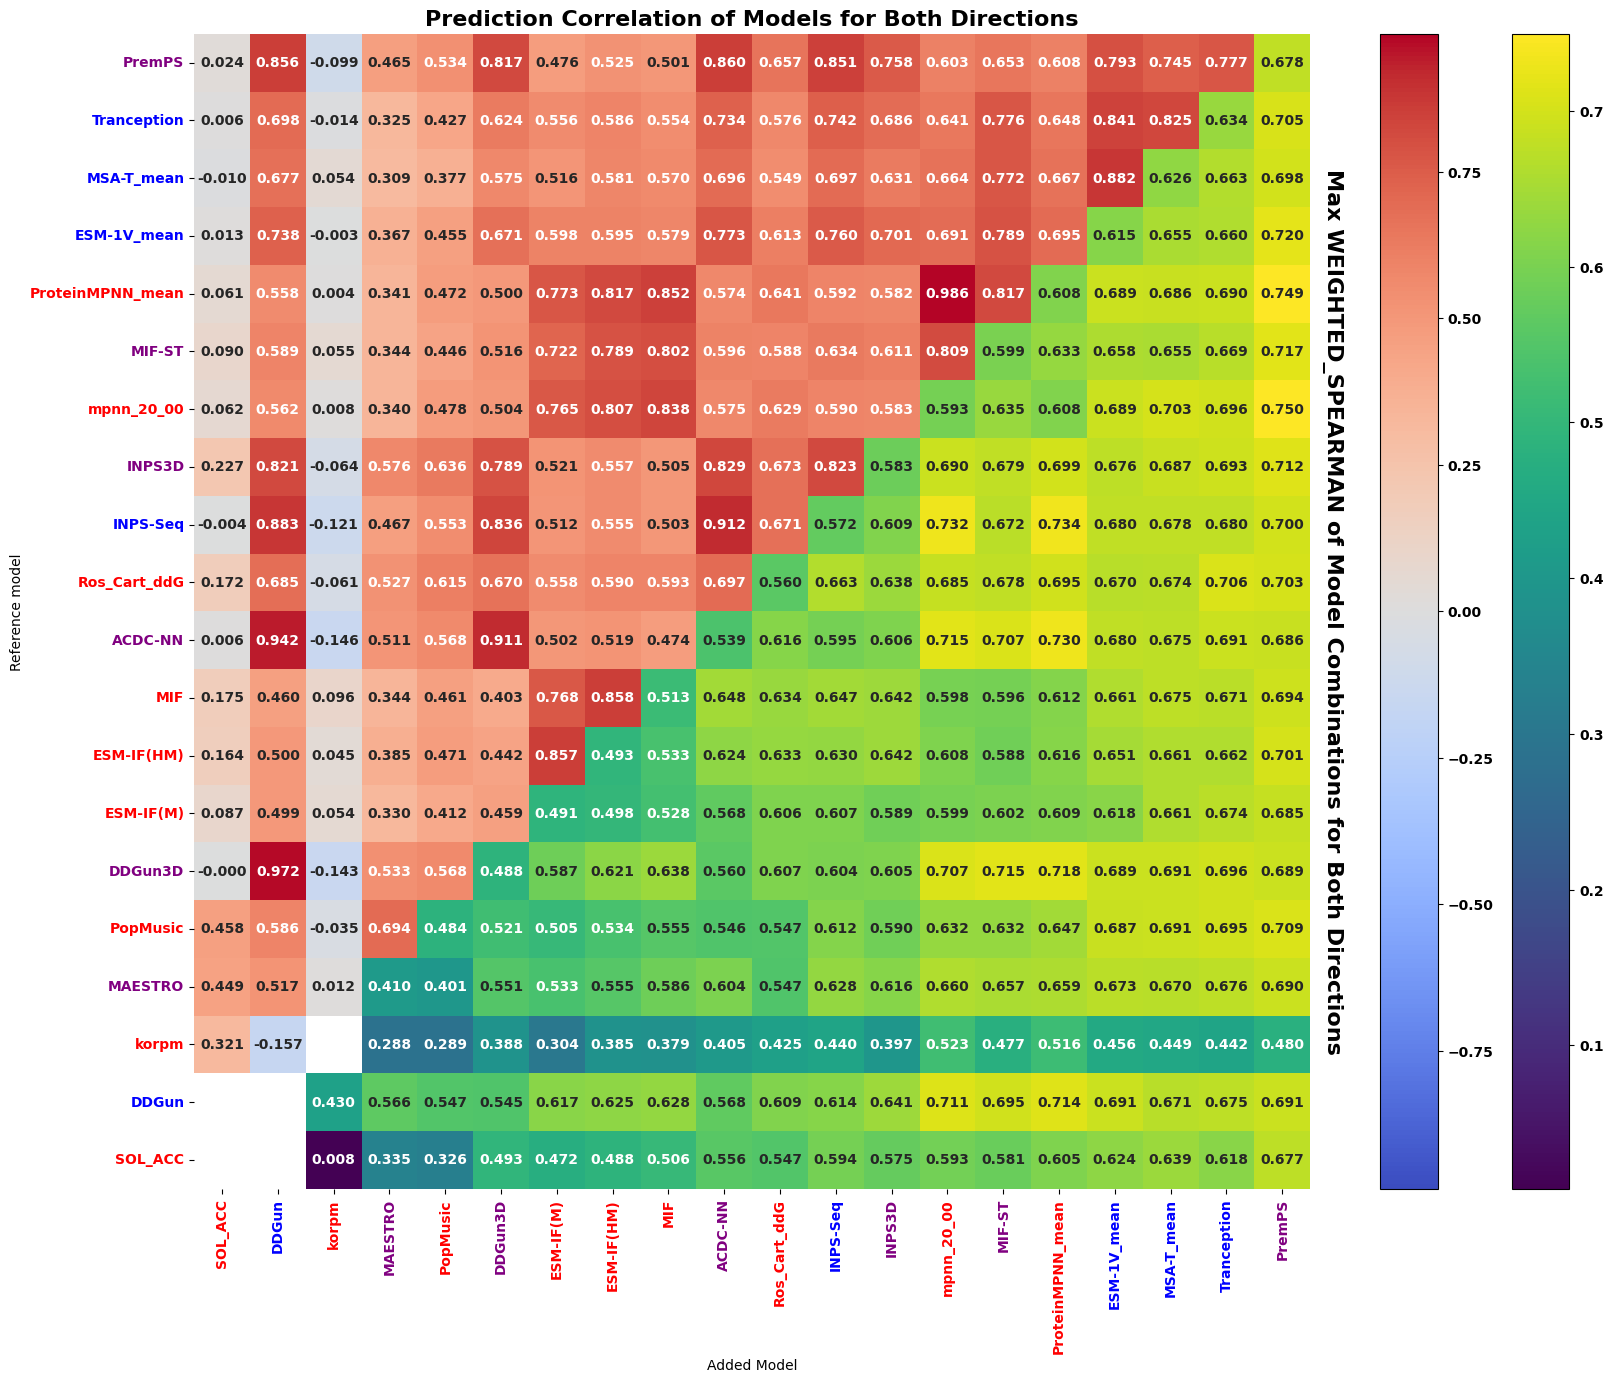

{'mifst', 'mif', 'ACDC-NN', 'DDGun3D', 'INPS-Seq', 'INPS3D', 'cartesian_ddg', 'mpnn_mean', 'esm1v_mean', 'esmif_monomer', 'msa_transformer_mean', 'tranception_red', 'DDGun', 'PopMusic', 'mpnn_20_00', 'PremPS'}


model1  weight1                model2  weight2  \
rank                                                            
1              PremPS      1.0            mpnn_20_00      1.0   
2              PremPS      1.0             mpnn_mean      1.0   
3            INPS-Seq      1.0             mpnn_mean      1.0   
4            INPS-Seq      1.0            mpnn_20_00      1.0   
5             ACDC-NN      1.0             mpnn_mean      1.0   
6              PremPS      1.0            esm1v_mean      1.0   
7             DDGun3D      1.0             mpnn_mean      1.0   
8              PremPS      1.0                 mifst      1.0   
9             ACDC-NN      1.0            mpnn_20_00      1.0   
10            DDGun3D      1.0                 mifst      0.5   
11              DDGun      1.0             mpnn_mean      1.0   
12             PremPS      1.0                INPS3D      0.5   
13              DDGun      1.0            mpnn_20_00      1.0   
14             PremPS      1.0              PopMusic      0.2   
15            ACDC-NN      1.0                 mifst      0.5   
16            DDGun3D      1.0            mpnn_20_00      1.0   
17    tranception_red      1.0         cartesian_ddg      0.5   
18             PremPS      1.0       tranception_red      1.0   
19         mpnn_20_00      1.0  msa_transformer_mean      1.0   
20             PremPS      1.0         cartesian_ddg      1.0   
21             PremPS      1.0         esmif_monomer      1.0   
22             PremPS      1.0              INPS-Seq      0.5   
23             INPS3D      1.0             mpnn_mean      1.0   
24             PremPS      1.0  msa_transformer_mean      0.2   
25         mpnn_20_00      1.0       tranception_red      1.0   
26    tranception_red      1.0               DDGun3D      0.2   
27      cartesian_ddg      1.0             mpnn_mean      1.0   
28    tranception_red      1.0              PopMusic      0.2   
29              DDGun      1.0                 mifst      0.5   
30             PremPS      1.0                   mif      1.0   

      weighted_spearman      corr  
rank                               
1              0.749527  0.602636  
2              0.748832  0.607990  
3              0.733583  0.592158  
4              0.731743  0.589786  
5              0.729955  0.574202  
6              0.719600  0.793368  
7              0.717517  0.499714  
8              0.716987  0.653144  
9              0.715325  0.574726  
10             0.714844  0.516232  
11             0.714370  0.558285  
12             0.712172  0.757647  
13             0.710676  0.562303  
14             0.708636  0.534252  
15             0.707496  0.595616  
16             0.706798  0.503960  
17             0.706212  0.576191  
18             0.705468  0.777396  
19             0.702825  0.664261  
20             0.702569  0.657053  
21             0.701121  0.524625  
22             0.700079  0.850946  
23             0.698520  0.581779  
24             0.698127  0.744502  
25             0.696458  0.640544  
26             0.696169  0.624111  
27             0.695075  0.641102  
28             0.694607  0.426681  
29             0.694508  0.589432  
30             0.693910  0.500871

In [85]:
custom_colors = {#'ACDC-NN-Seq': 'blue', 
                 'ACDC-NN': 'purple',
                 'DDGun': 'blue',
                 'DDGun3D': 'purple',
                 #'DUET': 'purple',
                 #'Dynamut': 'orange',
                 #'FoldX': 'red',
                 #'I-Mutant3.0': 'orange',
                 #'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'blue',
                 'INPS3D': 'purple',
                 'MAESTRO': 'purple',
                 #'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'purple',
                 #'SAAFEC-Seq': 'orange',
                 #'SDM': 'purple',
                 'SOL_ACC': 'red',
                 #'ThermoNet': 'red',
                 #'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 #'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 'msa_transformer_mean': 'blue',
                 'tranception_red': 'blue',
                 #'tranception': 'blue',
                 'esmif_monomer': 'red',
                 'esmif_multimer_full': 'red',
                 'esmif_monomer_full': 'red',
                 'korpm': 'red',
                 'esmif_multimer_full_masked': 'red',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'blue',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 #'mpnn_20_00': 'red',
                 'mpnn_mean': 'red',
                 'mpnn_20_00': 'red',
                 'mif': 'red',
                 'mifst': 'purple',
                 #'KORPMD': 'red',
                 #'EvoD': 'blue',
                 #'Dyna2D': 'purple',
                 #'CartddgD': 'red',
                 }

direction = 'combined'
statistic = 'weighted_spearman'
upper = 'corr'

d2 = d1.copy(deep=True)

x_cols = [c for c in d2.columns if ('x_recovery' in c)]
onex_cols = [c for c in x_cols if float(c.split('x_')[0])<=1]
d2['aumrc <=1x'] = d2[onex_cols].mean(axis=1)

p_cols = [c for c in d2.columns if ('%' in c)]

eightyp_cols = [c for c in p_cols if float(c.split('%')[0])>=80]
d2['auqrc >=80%'] = d2[eightyp_cols].mean(axis=1)

ninetyp_cols = [c for c in p_cols if float(c.split('%')[0])>=90]
d2['auqrc >=90%'] = d2[ninetyp_cols].mean(axis=1)

stat_df = model_combinations_heatmap(d2, db_preds, statistic, direction, upper)
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()
#df1 = stat_df.loc[~stat_df['model1'].str.contains('ddg') & ~stat_df['model2'].str.contains('ddg')].head(20)
#out = pd.concat([stat_df.loc[stat_df['model1'].str.contains('cartesian_ddg_dir') & stat_df['model2'].str.contains('cartesian_ddg_dir')], df1]).sort_index()
#out.index += 1
#out
stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
out

In [330]:
custom_colors = {'ACDC-NN-Seq': 'green', 
                 'ACDC-NN': 'orange',
                 'DDGun': 'green',
                 'DDGun3D': 'orange',
                 'DUET': 'orange',
                 'Dynamut': 'orange',
                 'FoldX': 'red',
                 'I-Mutant3.0': 'orange',
                 'I-Mutant3.0-Seq': 'green',
                 'INPS-Seq': 'green',
                 'INPS3D': 'orange',
                 'MAESTRO': 'orange',
                 'MuPro': 'red',
                 'PopMusic': 'red',
                 'PremPS': 'green',
                 'SAAFEC-Seq': 'orange',
                 'SDM': 'orange',
                 'SOL_ACC': 'red',
                 'ThermoNet': 'red',
                 'mCSM': 'red',
                 'cartesian_ddg': 'red',
                 'monomer_ddg': 'red',
                 'esm1v_mean': 'blue',
                 #'msa_transformer_mean': 'blue',
                 #'tranception_red': 'blue',
                 'esmif_monomer': 'blue',
                 'esmif_multimer': 'blue',
                 'esmif_monomer_masked': 'blue',
                 #'mpnn_10_00': 'blue',
                 #'mpnn_20_00': 'blue',
                 #'mpnn_20_02': 'blue',
                 #'mpnn_30_00': 'blue',
                 #'mpnn_30_03': 'blue',
                 'mpnn_20_00': 'blue',
                 'mpnn_mean': 'blue',
                 'mif': 'blue',
                 'mifst': 'blue'}

def custom_barplot(data, x, y, hue, width, ax, use_color=None, legend_labels=None, legend_colors=None):

    if legend_labels is not None and legend_colors is not None:
        lut = dict(zip(legend_labels, legend_colors))

    unique_x = data[x].unique()
    data = data.copy(deep=True)#.sort_values(width)
    if legend_labels is not None:
        unique_hue = legend_labels
        #unique_width = data.groupby([hue, width]).first().reset_index(level=1).loc[unique_hue][width]#.index.get_level_values(1)
    else:
        unique_hue = data[hue].unique()
    unique_width = data.groupby(hue)[width].max()

    #print(unique_width, unique_hue)
    #assert len(unique_hue) == len(unique_width)

    if use_color == None:
        colors = legend_colors
    else:
        colors = [use_color]

    max_width = sum(unique_width)

    bar_centers = np.zeros((len(unique_x), len(unique_hue)))
    for i in range(len(unique_x)):
        bar_centers[i, :] = i

    w_sum = 0
    for j, w in enumerate(unique_width):
        w_sum += w
        bar_centers[:, j] += (-max_width / 2 + w_sum -w/2) / (max_width * 1.1)

    for j, (width_value, hue_value, color) in enumerate(zip(unique_width, unique_hue, colors)):
        y_max = -1
        for i, x_value in enumerate(unique_x):
            filtered_data = data[(data[x] == x_value) & (data[hue] == hue_value)] #(data[width] == width_value) & 
            y_value = filtered_data[y].mean()
            y_max = max(y_max, y_value)
            bar_width = filtered_data[width].mean() / (max_width * 1.1)

            if legend_labels is not None and legend_colors is not None:
                color = lut[hue_value]
            ax.bar(bar_centers[i, j], y_value, color=color, width=bar_width, alpha=1 if not use_color else 0.4)
        ax.axhline(y=y_max, color=color, linestyle='dashed')

    ax.set_xticks(np.arange(len(unique_x)))
    ax.set_xticklabels(unique_x)
    ax.set_xlabel(x)
    ax.set_ylabel(y)

    if legend_labels is not None and legend_colors is not None:
        legend_elements = [Patch(facecolor=lut[hue_value], label=f'{hue_value}: {int(width_value)}') for hue_value, width_value in zip(unique_hue, unique_width)]
    else:
        legend_elements = [Patch(facecolor=color, label=f'{hue_value}: {int(width_value)}') for hue_value, width_value, color in zip(unique_hue, unique_width, colors)]
    #ax.legend(handles=legend_elements, title=hue)
    return legend_elements

def compare_performance(db_complete,
                        threshold_1 = 1.5, 
                        threshold_2 = None, 
                        split_col = 'hbonds', 
                        split_col_2 = None, 
                        direction = 'dir',
                        statistic = 'MCC'):

    font = {'size'   : 10}
    matplotlib.rc('font', **font)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,20), sharex=True)
    fig.patch.set_facecolor('white')
    sns.set_palette('tab10')

    dbc = db_complete.copy(deep=True)

    # Ungrouped performance (doesn't change)
    c0 = classifications(dbc, stats=[statistic] + ['n'])
    c00 = c0.reset_index()

    if split_col != 'direction_split':
        c00 = c00.loc[c00['direction']==direction]
    else:
        c00 = c00.loc[c00['direction']=='combined']
    c00 = c00.sort_values(statistic, ascending=False)
    c00 = c00.set_index('model')

    # get only the models we want to include specified by custom colors
    new_index = []
    for i in c00.index:
        for color in list(custom_colors.keys()):
            if color in i:
                new_index.append(i)
                break
    c00 = c00.loc[new_index]

    # Unnormalized split performance
    c = classifications(dbc, split_col=split_col if split_col != 'direction_split' else None, split_col_2=split_col_2, 
                        split_val=threshold_1, split_val_2=threshold_2, stats=[statistic] + ['n'])
    c1 = c.reset_index()

    if split_col != 'direction_split':
        c1 = c1.loc[c1['direction']==direction]
    else:
        remap = {'dir': 1, 'inv': 0}
        c1['tmp_dir'] = c1['direction'].map(remap)
        c1[split_col] = np.nan
        c1.loc[c1['tmp_dir'] > 0.5, split_col] = 'direction_split > 0.5'
        c1.loc[c1['tmp_dir'] <= 0.5, split_col] = 'direction_split <= 0.5'
        c1['model'] = c1['model'].str[:-4]
        c1 = c1.dropna(subset=split_col)
        
    c1 = c1.set_index('model').loc[new_index].reset_index()
    
    # case 2 split cols
    if split_col_2 is not None:
        dbc[f'{split_col} > {threshold_1} & {split_col_2} > {threshold_2}'] = (dbc[split_col] > threshold_1) & (dbc[split_col_2] > threshold_2)
        dbc[f'{split_col} <= {threshold_1} & {split_col_2} > {threshold_2}'] = (dbc[split_col] <= threshold_1) & (dbc[split_col_2] > threshold_2)
        dbc[f'{split_col} > {threshold_1} & {split_col_2} <= {threshold_2}'] = (dbc[split_col] > threshold_1) & (dbc[split_col_2] <= threshold_2)
        dbc[f'{split_col} <= {threshold_1} & {split_col_2} <= {threshold_2}'] = (dbc[split_col] <= threshold_1) & (dbc[split_col_2] <= threshold_2)
        vvs = [f'{split_col} > {threshold_1} & {split_col_2} > {threshold_2}', 
                 f'{split_col} <= {threshold_1} & {split_col_2} > {threshold_2}',
                 f'{split_col} > {threshold_1} & {split_col_2} <= {threshold_2}',
                 f'{split_col} <= {threshold_1} & {split_col_2} <= {threshold_2}']

    # case 1 split col, 2 thresholds
    elif threshold_2 is not None:
        dbc[f'{split_col} > {threshold_1}'] = dbc[split_col] > threshold_1
        dbc[f'{split_col} > {threshold_1}'] = dbc[split_col] > threshold_1
        dbc[f'{threshold_1} >= {split_col} > {threshold_2}'] = (dbc[split_col] <= threshold_1) & (dbc[split_col] > threshold_2)
        dbc[f'{split_col} <= {threshold_2}'] = dbc[split_col] <= threshold_2
        vvs = [f'{split_col} > {threshold_1}', f'{threshold_1} >= {split_col} > {threshold_2}', f'{split_col} <= {threshold_2}']

    # case 1 split col, 1 threshold
    elif threshold_2 is None and split_col != 'direction_split':
        dbc[f'{split_col} > {threshold_1}'] = dbc[split_col] > threshold_1
        dbc[f'{split_col} <= {threshold_1}'] = dbc[split_col] <= threshold_1
        vvs = [f'{split_col} > {threshold_1}', f'{split_col} <= {threshold_1}']

    if direction == 'combined':
        dbc_stack = stack_frames(dbc).reset_index().set_index('uid')
        #dbc_stack.index = dbc_stack.index.str[:-4]
        dbc = dbc_stack.join(dbc.drop([c for c in dbc.columns if '_dir' in c or '_inv' in c], axis=1))

    if split_col == 'direction_split':
        dbc = dbc.reset_index()
        tmp_split_col = 'direction'

        remap = {'dir': 1, 'inv': 0}
        dbc[split_col] = dbc['direction'].map(remap)
        dbc[f'{split_col} > {threshold_1}'] = dbc[split_col] > threshold_1
        dbc[f'{split_col} <= {threshold_1}'] = dbc[split_col] <= threshold_1
        vvs = [f'{split_col} > {threshold_1}', f'{split_col} <= {threshold_1}']
        
    dbc = dbc.melt(id_vars=dbc.columns.drop(vvs), value_vars=vvs)
    dbc = dbc.loc[dbc['value']].rename({'variable':'split'}, axis=1)
    vvs2 = new_index

    dbc = dbc.melt(id_vars=['split'], value_vars=vvs2)
    std = dbc.groupby('variable')['value'].transform('std')
    dbc['value'] /= std
    c01 = pd.DataFrame()
    for key in new_index:
        subset = dbc.loc[dbc['variable']==key]
        c01 = pd.concat([c01, subset])

    categories = new_index

    # Class-wise predicted distribution
    ax = sns.violinplot(data=c01,x='variable',y='value',hue=f'split',ax=ax2, split=True if threshold_2 is None else False, bw=0.2, cut=0)

    max_values = c01.groupby('variable')['value'].idxmax()

    # Loop over each max value
    for idx in max_values:
        # Get the row from the DataFrame
        row = c01.loc[idx]
        # Get the x-coordinate for the annotation
        x_coord = ax.get_xticks()[row['variable'] == c01['variable'].unique()]
        ax.text(x_coord, row['value'], -round(float(c00.at[row['variable'], 'antisymmetry']), 2), ha='center', va='bottom')
        ax.text(x_coord, row['value'], -round(float(c00.at[row['variable'], 'bias']), 2), ha='center', va='top') 

    legend = ax.legend_
    labels = [t.get_text() for t in legend.texts]
    colors = [c.get_facecolor() for c in legend.legendHandles]

    ax2.set_title('Class-wise predicted distribution')
    ax2.set_ylabel('Stability / log-likelihood')
    #ax2.set_xticks([])
    ax2.set_xlabel('')
    ax2.grid()
    ax2.axhline(y=0, color='r', linestyle='dashed')
    
    legend_elements = custom_barplot(data=c1.drop_duplicates(), x='model', y=statistic, hue='class' if split_col != 'direction_split' else split_col, 
        width='n', ax=ax1, legend_colors=colors, legend_labels=labels)
    _ = custom_barplot(data=c00.drop_duplicates().reset_index(), 
                   x='model', y=statistic, hue='class', width='n', ax=ax1, use_color='yellow')
    ax1.set_title(statistic) #'Delta vs. split mean'
    ax1.grid()
    ax1.set_xlabel('')
    if split_col == 'direction_split':
        ax2.legend(handles=legend_elements, labels=['direct', 'inverse'])
    else:
       ax2.legend(handles=legend_elements) 
    ax2.set_xticks(ax2.get_xticks(), categories, rotation=45, ha='right')

    for ax in list([ax2, ax1]):
        for tick_label in ax.get_xticklabels():
            for key, val in custom_colors.items():
                if key in tick_label.get_text():
                    tick_label.set_color(custom_colors[key])
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    print(c1.groupby('class')['n'].max())
    plt.show()
    return c1

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/58 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

class
    461.0
Name: n, dtype: float64


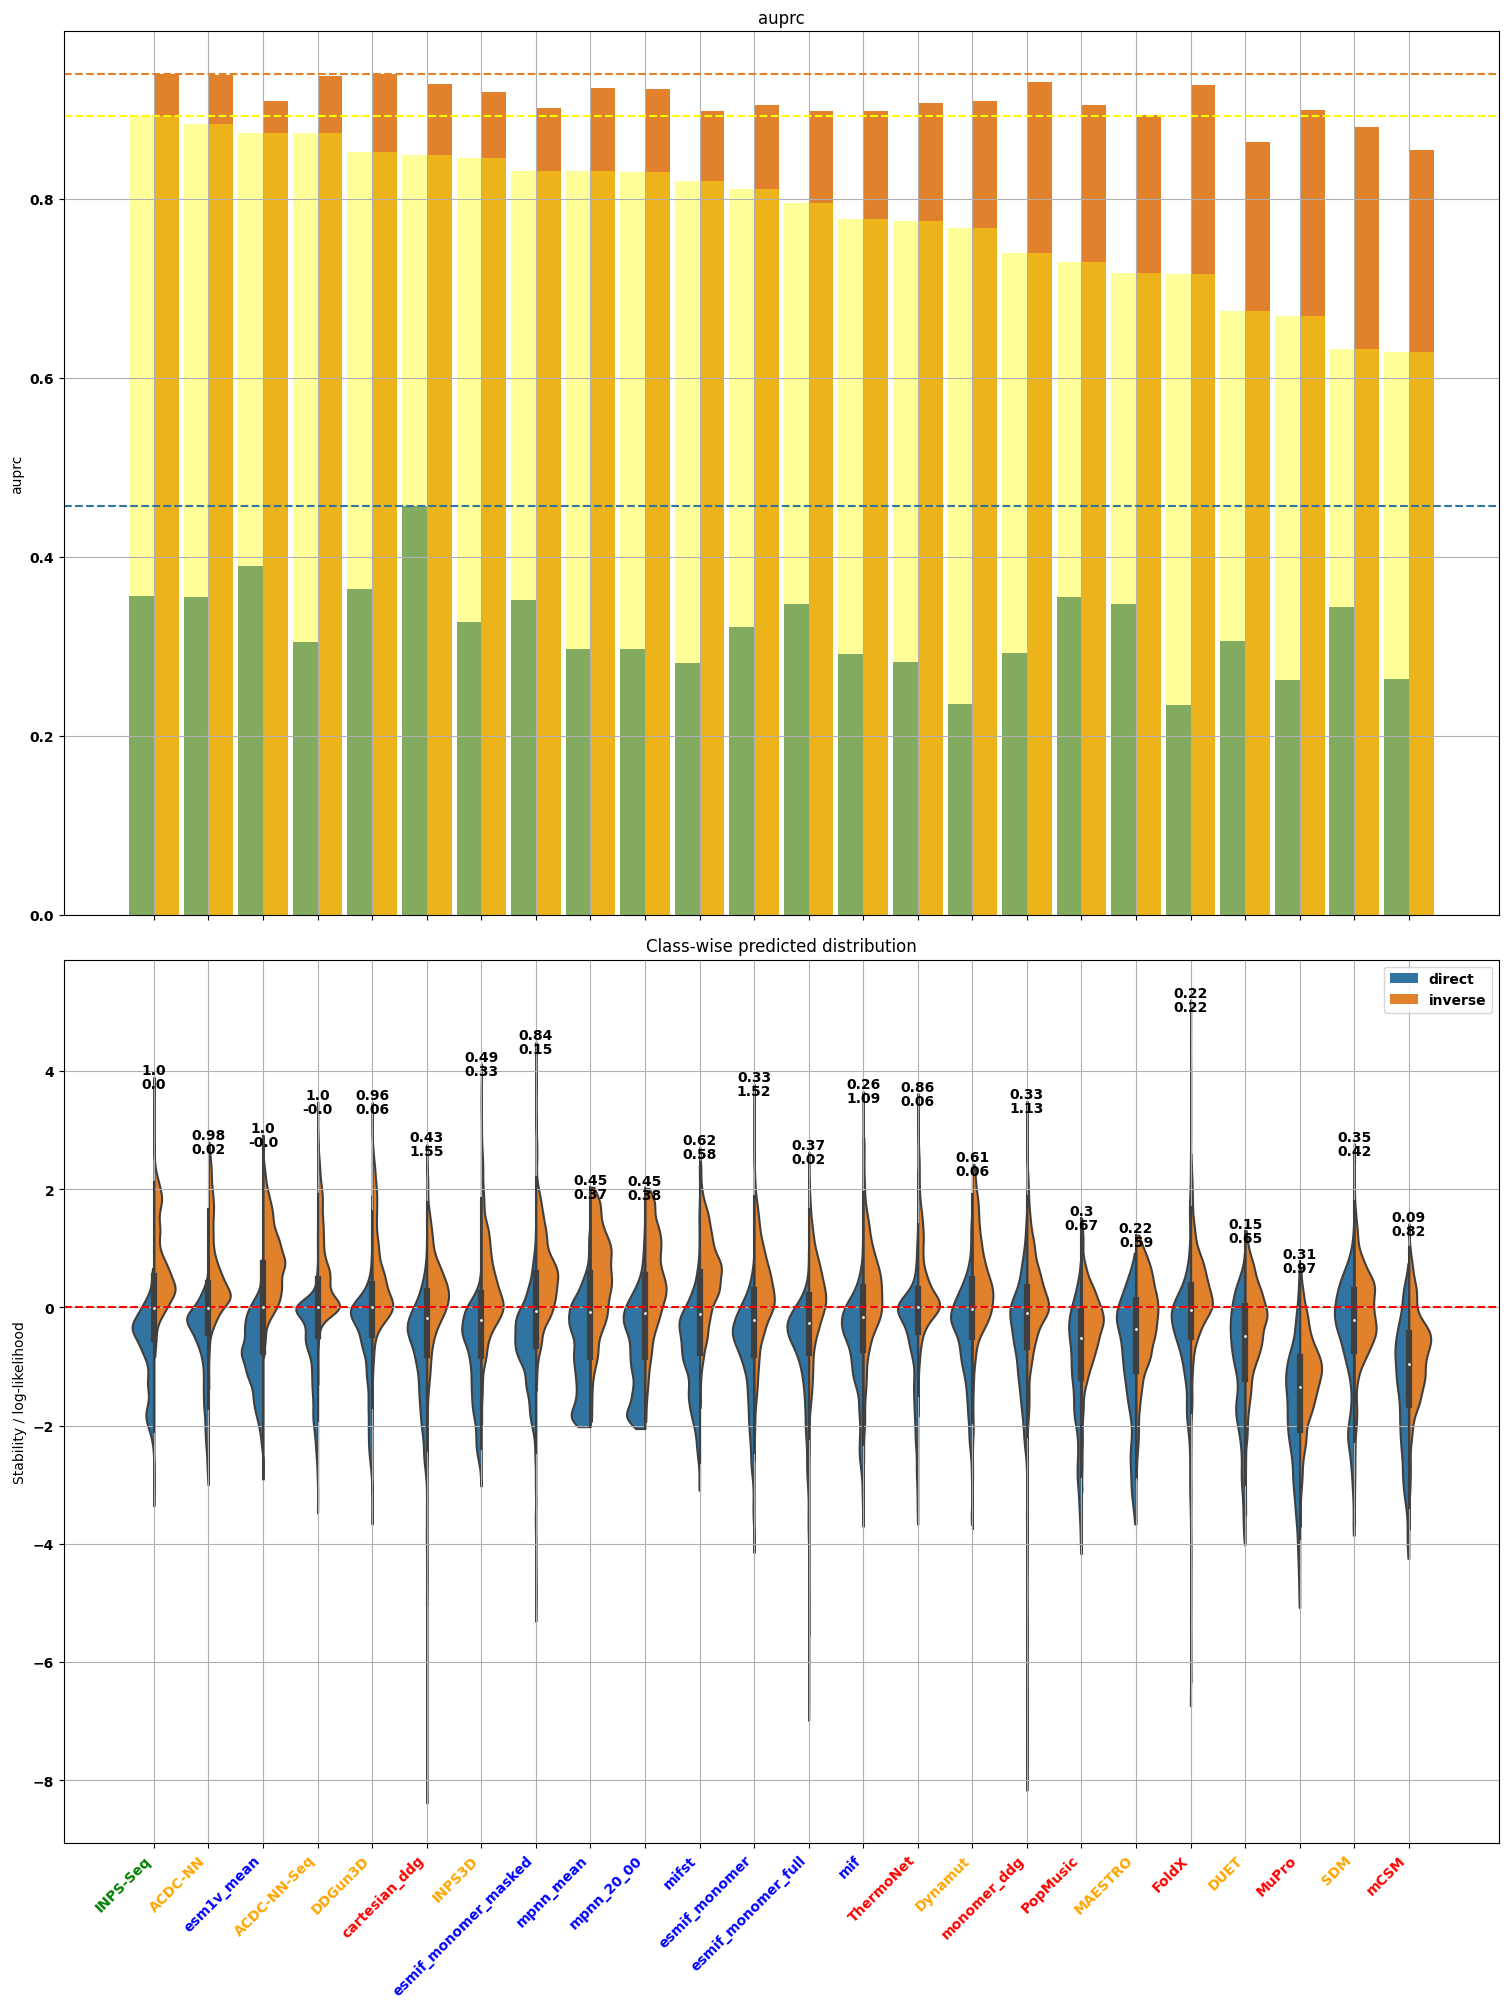

In [331]:
db_nona = db_complete.dropna(subset=[col for col in db_complete.columns if any(substring+'_dir' in col for substring in custom_colors.keys())], how='any')
#db_nona = db_complete

#columns_to_check = [col for col in db_complete.columns if any(substring in col for substring in custom_colors.keys())]
#filtered_columns = db_complete[columns_to_check].dropna(how='any', axis=1)
#db_nona = pd.concat([db_complete.drop(columns=columns_to_check), filtered_columns], axis=1)

d = compare_performance(db_nona.drop('code', axis=1),
                        threshold_1 = 0.5, 
                        threshold_2 = None, 
                        split_col = 'direction_split', 
                        split_col_2 = None, 
                        direction = 'combined',
                        statistic = 'auprc')

In [21]:
d

direction    model_type class      n    tp     fp  \
model                                                                        
INPS-Seq_dir                   dir  evolutionary        669.0  55.0   62.0   
cartesian_ddg_dir              dir    structural        667.0  60.0   65.0   
esm1v_mean_dir                 dir  evolutionary        669.0  48.0   40.0   
ACDC-NN_dir                    dir        hybrid        669.0  57.0   74.0   
DDGun3D_dir                    dir  evolutionary        667.0  70.0   92.0   
esmif_multimer_full_dir        dir    structural        669.0  35.0   43.0   
ACDC-NN-Seq_dir                dir  evolutionary        669.0  51.0   61.0   
INPS3D_dir                     dir        hybrid        667.0  35.0   41.0   
esmif_monomer_masked_dir       dir    structural        669.0  58.0   68.0   
PopMusic_dir                   dir    structural        666.0  38.0   40.0   
esmif_monomer_full_dir         dir    structural        669.0  34.0   46.0   
Dynamut_dir                    dir        hybrid        669.0  81.0  136.0   
MAESTRO_dir                    dir        hybrid        669.0  68.0   79.0   
esmif_multimer_dir             dir    structural        669.0  43.0   47.0   
SDM_dir                        dir        hybrid        669.0  89.0  153.0   
ThermoNet_dir                  dir    structural        669.0  85.0  150.0   
PremPS_dir                     dir        hybrid        666.0  38.0   50.0   
esmif_monomer_dir              dir    structural        669.0  42.0   52.0   
mpnn_20_00_dir                 dir    structural        669.0  48.0   77.0   
mpnn_20_001_dir                dir    structural        669.0  50.0   78.0   
I-Mutant3.0-Seq_dir            dir  evolutionary        669.0  35.0   38.0   
monomer_ddg_dir                dir    structural        666.0  88.0  130.0   
mpnn_mean_dir                  dir    structural        669.0  46.0   86.0   
mif_dir                        dir    structural        669.0  51.0   82.0   
mCSM_dir                       dir    structural        669.0  25.0   41.0   
mifst_dir                      dir    structural        669.0  36.0   51.0   
I-Mutant3.0_dir                dir        hybrid        667.0  18.0   28.0   
SAAFEC-Seq_dir                 dir  evolutionary        667.0  18.0   28.0   
MuPro_dir                      dir    structural        669.0   7.0   15.0   
FoldX_dir                      dir    structural        667.0  69.0  131.0   

                             tn     fn     auprc  antisymmetry  bias  
model                                                                 
INPS-Seq_dir              439.0  113.0  0.463680           NaN   NaN  
cartesian_ddg_dir         434.0  108.0  0.449111           NaN   NaN  
esm1v_mean_dir            461.0  120.0  0.445522           NaN   NaN  
ACDC-NN_dir               427.0  111.0  0.441578           NaN   NaN  
DDGun3D_dir               407.0   98.0  0.427659           NaN   NaN  
esmif_multimer_full_dir   458.0  133.0  0.423573           NaN   NaN  
ACDC-NN-Seq_dir           440.0  117.0  0.409840           NaN   NaN  
INPS3D_dir                458.0  133.0  0.406732           NaN   NaN  
esmif_monomer_masked_dir  433.0  110.0  0.405416           NaN   NaN  
PopMusic_dir              460.0  128.0  0.404495           NaN   NaN  
esmif_monomer_full_dir    455.0  134.0  0.404287           NaN   NaN  
Dynamut_dir               365.0   87.0  0.400870           NaN   NaN  
MAESTRO_dir               422.0  100.0  0.398148           NaN   NaN  
esmif_multimer_dir        454.0  125.0  0.395699           NaN   NaN  
SDM_dir                   348.0   79.0  0.392313           NaN   NaN  
ThermoNet_dir             351.0   83.0  0.386784           NaN   NaN  
PremPS_dir                448.0  130.0  0.374572           NaN   NaN  
esmif_monomer_dir         449.0  126.0  0.373335           NaN   NaN  
mpnn_20_00_dir            424.0  120.0  0.367153           NaN   NaN  
mpnn_20_001_dir           423.0  118.

In [10]:
db_complete

ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  ACDC-NN_inv  \
uid                                                                     
1A0F_11A          0.041723        -0.041723     0.225406    -0.319539   
1A7V_104H        -0.495499         0.495499    -0.333256     0.308649   
1A7V_13H          0.000000         0.000000    -0.155792     0.154150   
1A7V_20H         -0.002231         0.002231    -0.171187     0.144576   
1A7V_31H         -0.013802         0.013802    -0.160372     0.160372   
...                    ...              ...          ...          ...   
5JXB_25P          0.000536        -0.000536     0.134216    -0.134216   
5OAQ_199H        -1.387815         1.387815    -1.356237     1.590481   
5VP3_128G        -0.701056         0.701056    -0.510884     0.537406   
5VP3_183T        -1.375923         1.375923    -0.657788     0.658870   
5VP3_39K         -0.406377         0.406377    -0.501640     0.528053   

           DDGun3D_dir  DDGun3D_inv  DDGun_dir  DDGun_inv  DUET_dir  DUET_inv  \
uid                                                                             
1A0F_11A           0.5         -0.5        0.0        0.0    -0.466    -2.095   
1A7V_104H         -0.1          0.1       -0.5        0.5    -0.467     0.566   
1A7V_13H           0.3         -0.3        0.6       -0.7    -0.819     0.533   
1A7V_20H           0.3         -0.3        0.7       -0.7    -0.866     0.687   
1A7V_31H           0.1         -0.1        0.7       -0.7    -0.099     0.687   
...                ...          ...        ...        ...       ...       ...   
5JXB_25P          -0.2          0.0       -0.4        0.1     0.362     0.060   
5OAQ_199H         -2.4          2.4       -2.7        2.6    -1.531     0.662   
5VP3_128G         -0.8          0.8       -0.9        0.8    -1.163    -1.231   
5VP3_183T         -1.2          1.3       -1.3        1.2    -2.097    -0.135   
5VP3_39K          -1.0          1.0       -1.2        1.3    -0.803    -0.274   

           ...  from_proline  from_glycine  helix   bend   turn   coil  \
uid        ...                                                           
1A0F_11A   ...         False         False  False  False   True  False   
1A7V_104H  ...         False         False   True  False  False  False   
1A7V_13H   ...         False         False   True  False  False  False   
1A7V_20H   ...         False         False   True  False  False  False   
1A7V_31H   ...         False         False  False  False  False   True   
...        ...           ...           ...    ...    ...    ...    ...   
5JXB_25P   ...         False         False  False   True  False  False   
5OAQ_199H  ...         False         False  False  False  False  False   
5VP3_128G  ...         False         False   True  False  False  False   
5VP3_183T  ...         False         False   True  False  False  False   
5VP3_39K   ...         False         False   True  False  False  False   

           strand  xray_else_NMR  active_site          neff  
uid                                                          
1A0F_11A    False           True        False  11312.451628  
1A7V_104H   False           True        False   3970.041972  
1A7V_13H    False           True        False   3970.041972  
1A7V_20H    False           True        False   3970.041972  
1A7V_31H    False           True        False   3970.041972  
...           ...            ...          ...           ...  
5JXB_25P    False           True        False    112.986182  
5OAQ_199H    True           True        False    197.028468  
5VP3_128G   False           True        False   2051.798630  
5VP3_183T   False           True        False   2051.798630  
5VP3_39K    False           True        False   2051.798630  

[669 rows x 113 columns]

Average prediction for stabilized protein: -5.272661443210841
Average experimental value for predicted stabilized: 0.06032558139534879


n_expt_stable                          166.000000
P(pred_stable|stable) - sensitivity      0.132530
P(pred_stable|unstable) - FPR            0.042596
n_pred_stable                           43.000000
P(stable|pred_stable) - PPV              0.534884
P(stable|pred_unstable) - FOR            0.235390
dtype: float64

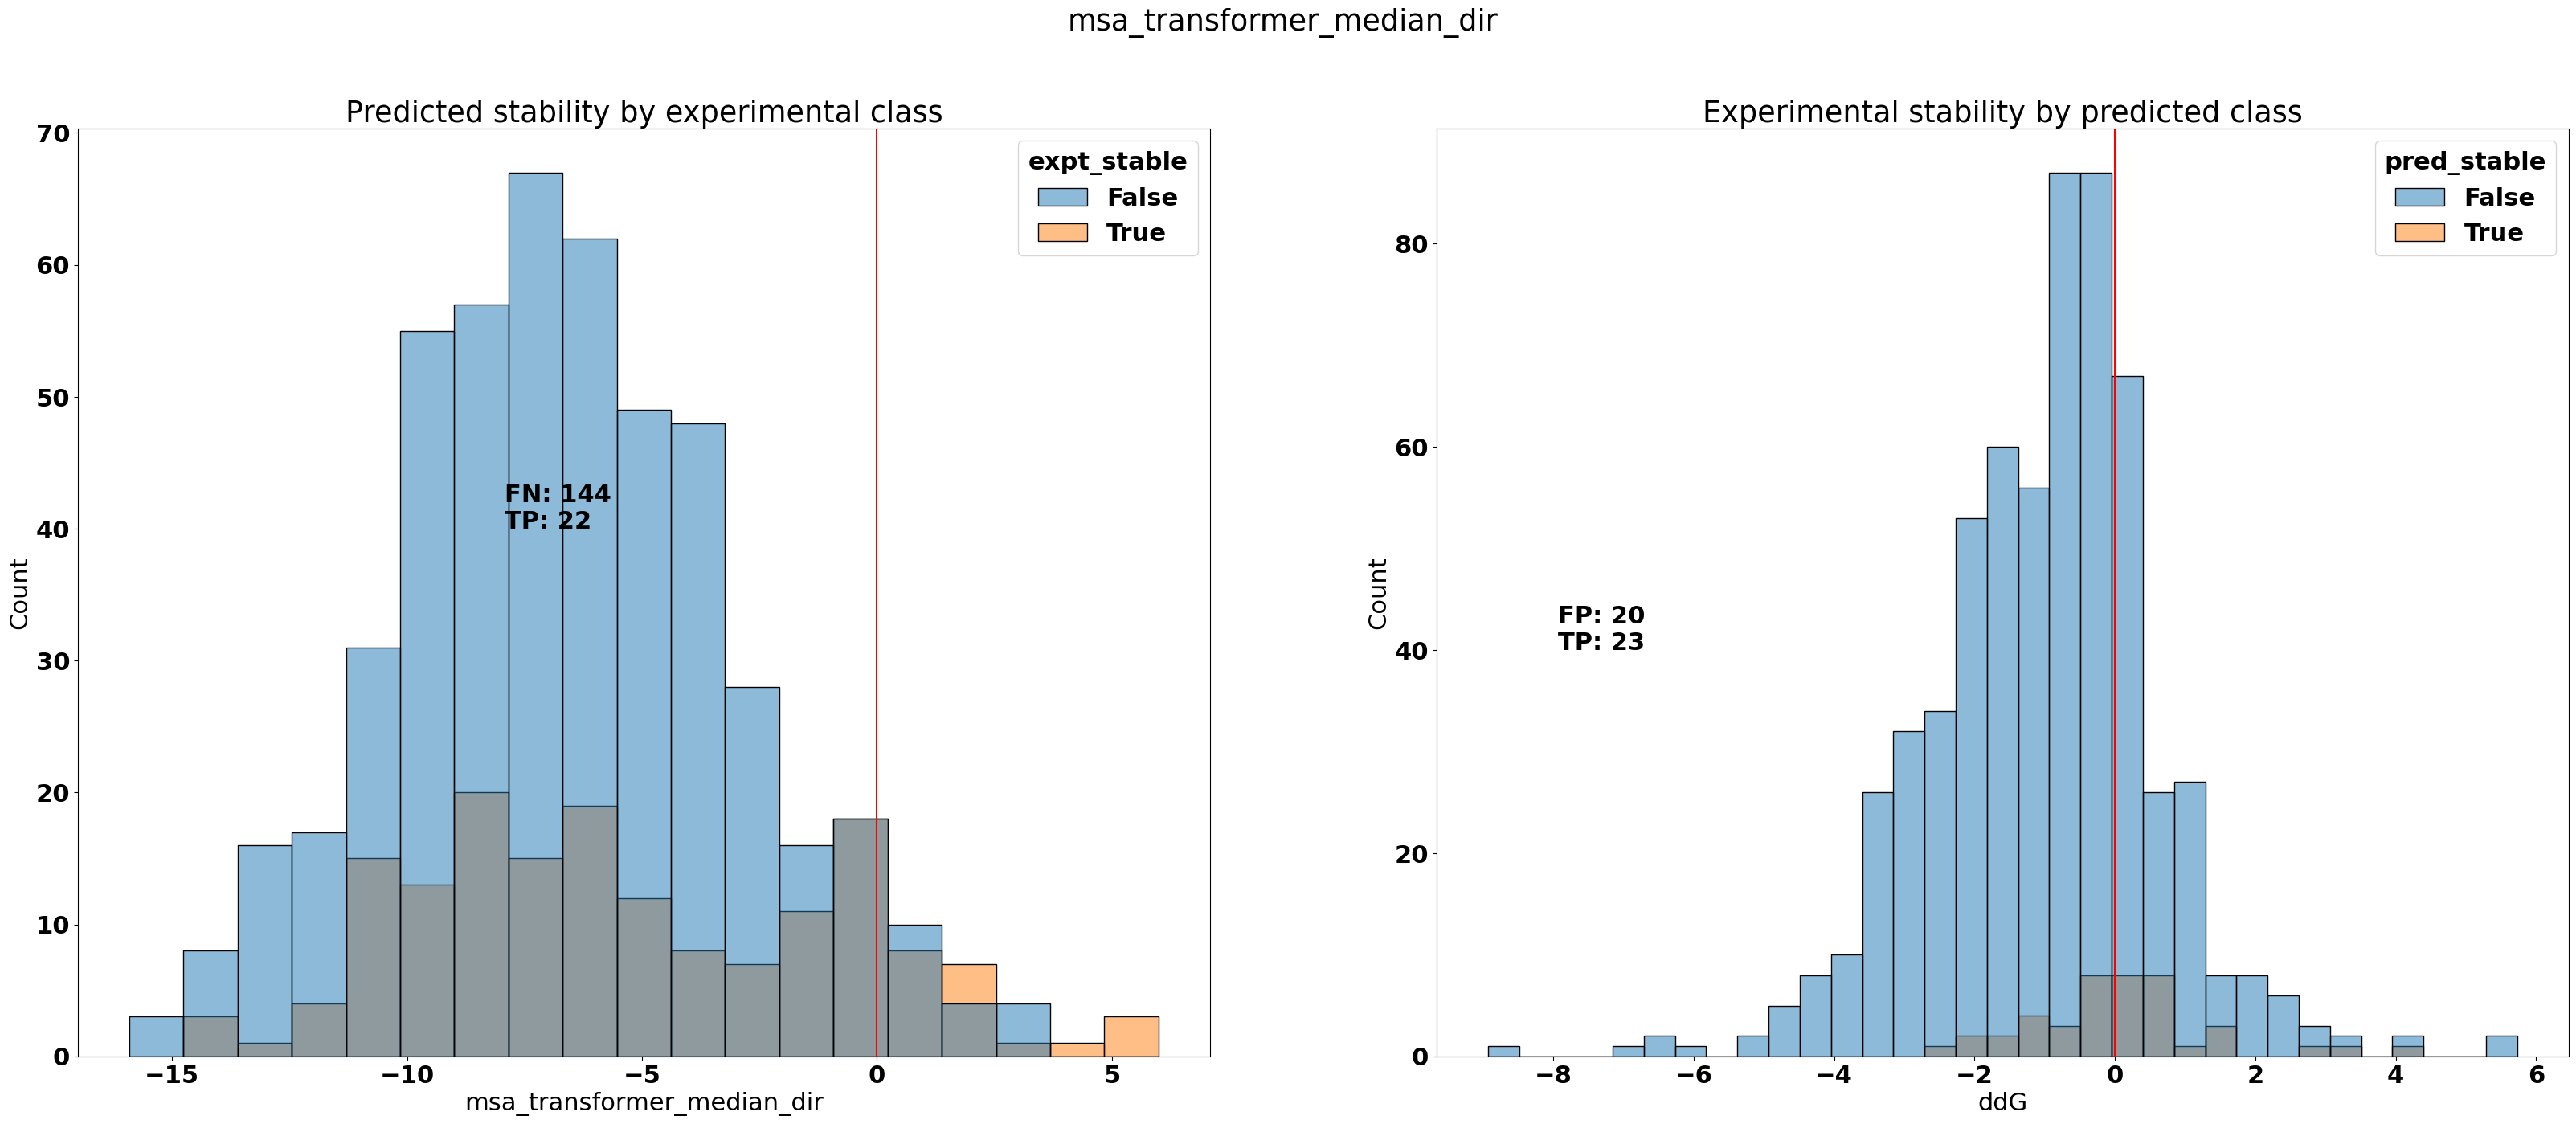

In [138]:
def compare_stable_dists(db_complete, score_name, score_name_2=None, full=False, decision_threshold_ddg=0, decision_threshold_score=0):
    dbf = db_complete.copy(deep=True)

    if full:
        if '_dir' in score_name or '_inv' in score_name:
            score_name = score_name[:-4]
        if score_name_2 is not None and ('_dir' in score_name_2 or '_inv' in score_name_2):
            score_name_2 = score_name_2[:-4]
        dbf = stack_frames(dbf)

    dbf = dbf.loc[:, [score_name, 'ddG']]
    min_score = dbf[score_name].min() + 1
    min_ddg = dbf['ddG'].min() + 1

    df_out = pd.Series(index = ['n_expt_stable', 'P(pred_stable|stable) - sensitivity', 'P(pred_stable|unstable) - FPR',\
                                 'n_pred_stable', 'P(stable|pred_stable) - PPV', 'P(stable|pred_unstable) - FOR'], dtype=float)
    fig, axs = plt.subplots(1, 2, figsize=(40, 15))
    fig.suptitle(score_name)

    # separate all of the data based on whether or not it is (on median) stabilizing in experiment
    stable = dbf.loc[dbf['ddG'] > decision_threshold_ddg, :].dropna().copy()
    stable['expt_stable'] = True
    unstable = dbf.loc[dbf['ddG'] <= decision_threshold_ddg, :].dropna().copy()
    unstable['expt_stable'] = False
    to_plot = pd.concat([stable, unstable])

    # calculate statistics about predictions conditioned on ground truth
    df_out['n_expt_stable'] = len(stable)
    df_out['P(pred_stable|stable) - sensitivity'] = len(stable.loc[stable[score_name] >= decision_threshold_score]) / len(stable)
    df_out['P(pred_stable|unstable) - FPR'] = len(unstable.loc[unstable[score_name] >= decision_threshold_score]) / len(unstable)

    # plot the first histogram that shows predicted stability separated by ground truth class
    sns.histplot(ax=axs[0], data=to_plot, x=score_name, hue='expt_stable')
    left = len(stable.loc[stable[score_name] <= decision_threshold_score])
    right = len(stable.loc[stable[score_name] > decision_threshold_score])
    axs[0].annotate(f'FN: {left}\nTP: {right}', xy=(min_ddg,40))
    axs[0].axvline(x = decision_threshold_score, color = 'r', label = 'axvline - full height')
    axs[0].set_title(f'Predicted stability by experimental class')

    avg = stable[score_name].mean()
    print('Average prediction for stabilized protein:', avg)

    predicted_stable = dbf.loc[dbf[score_name] > decision_threshold_score, :].dropna().copy()
    predicted_stable['pred_stable'] = True
    predicted_unstable = dbf.loc[dbf[score_name] <= decision_threshold_score, :].dropna().copy()
    predicted_unstable['pred_stable'] = False
    to_plot = pd.concat([predicted_stable, predicted_unstable])

    df_out['n_pred_stable'] = len(predicted_stable)
    df_out['P(stable|pred_stable) - PPV'] = len(predicted_stable.loc[predicted_stable['ddG'] >= decision_threshold_ddg]) / len(predicted_stable)
    df_out['P(stable|pred_unstable) - FOR'] = len(predicted_unstable.loc[predicted_unstable['ddG'] >= decision_threshold_ddg]) / len(predicted_unstable)
    
    left = len(predicted_stable.loc[predicted_stable['ddG'] < decision_threshold_ddg])
    right = len(predicted_stable.loc[predicted_stable['ddG'] >= decision_threshold_ddg])
    sns.histplot(ax=axs[1], data=to_plot, x='ddG', hue='pred_stable')
    axs[1].annotate(f'FP: {left}\nTP: {right}', xy=(min_ddg,40))
    axs[1].axvline(x = decision_threshold_ddg, color = 'r', label = 'axvline - full height')
    axs[1].set_title(f'Experimental stability by predicted class')

    avg = predicted_stable['ddG'].mean()
    print('Average experimental value for predicted stabilized:', avg)

    return df_out

score_1 = 'msa_transformer_median_dir' 
db_complete = db_preds.join(ddgs, how='left')
compare_stable_dists(db_complete, score_1, decision_threshold_score=0)

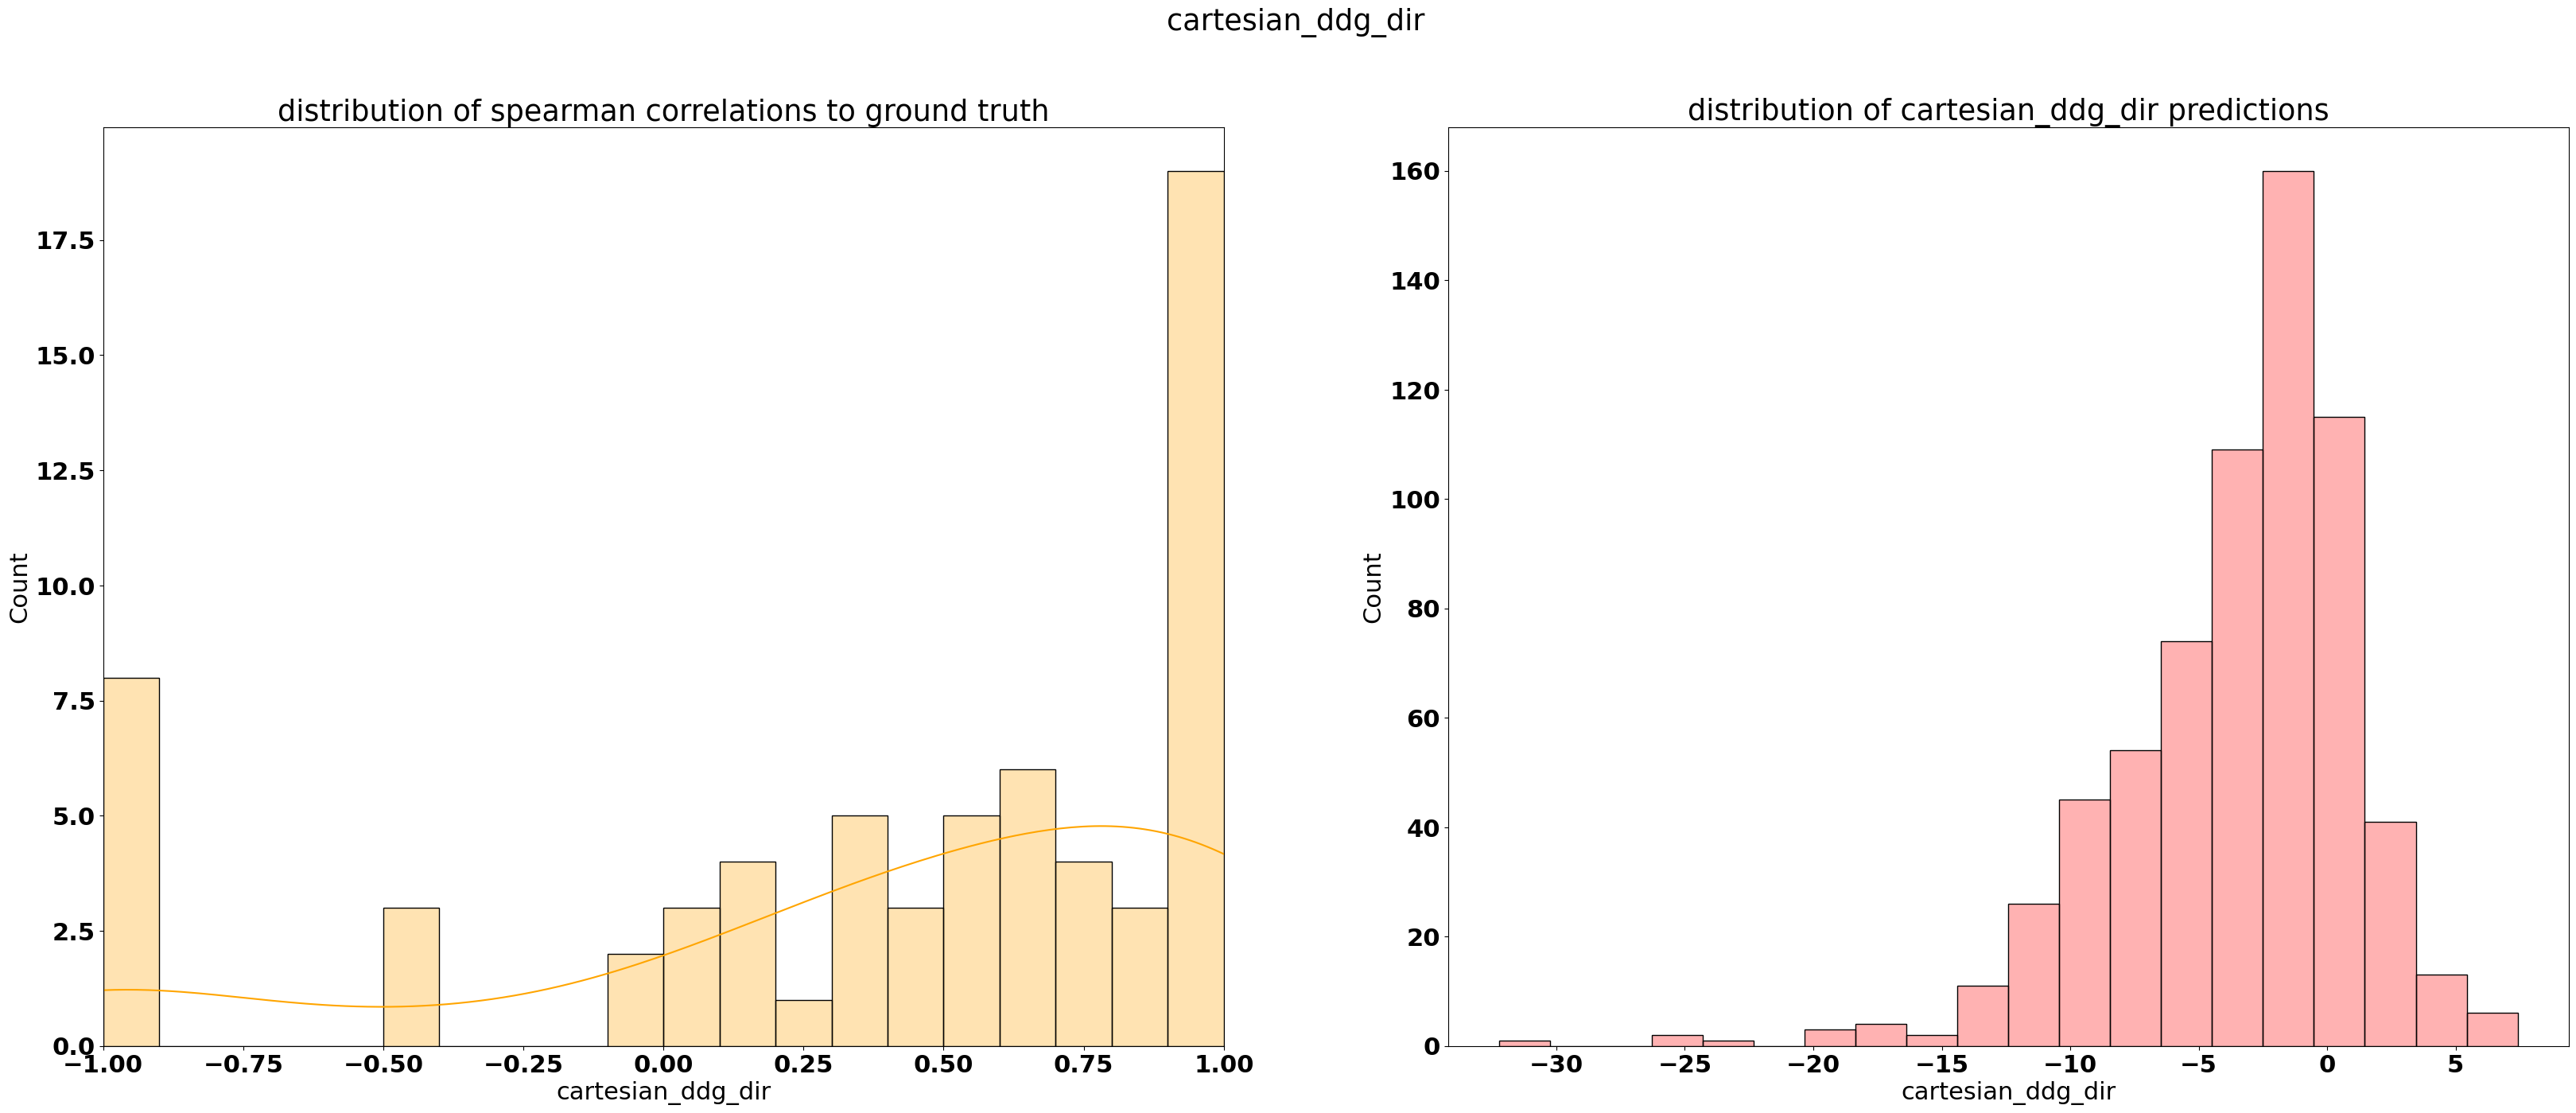

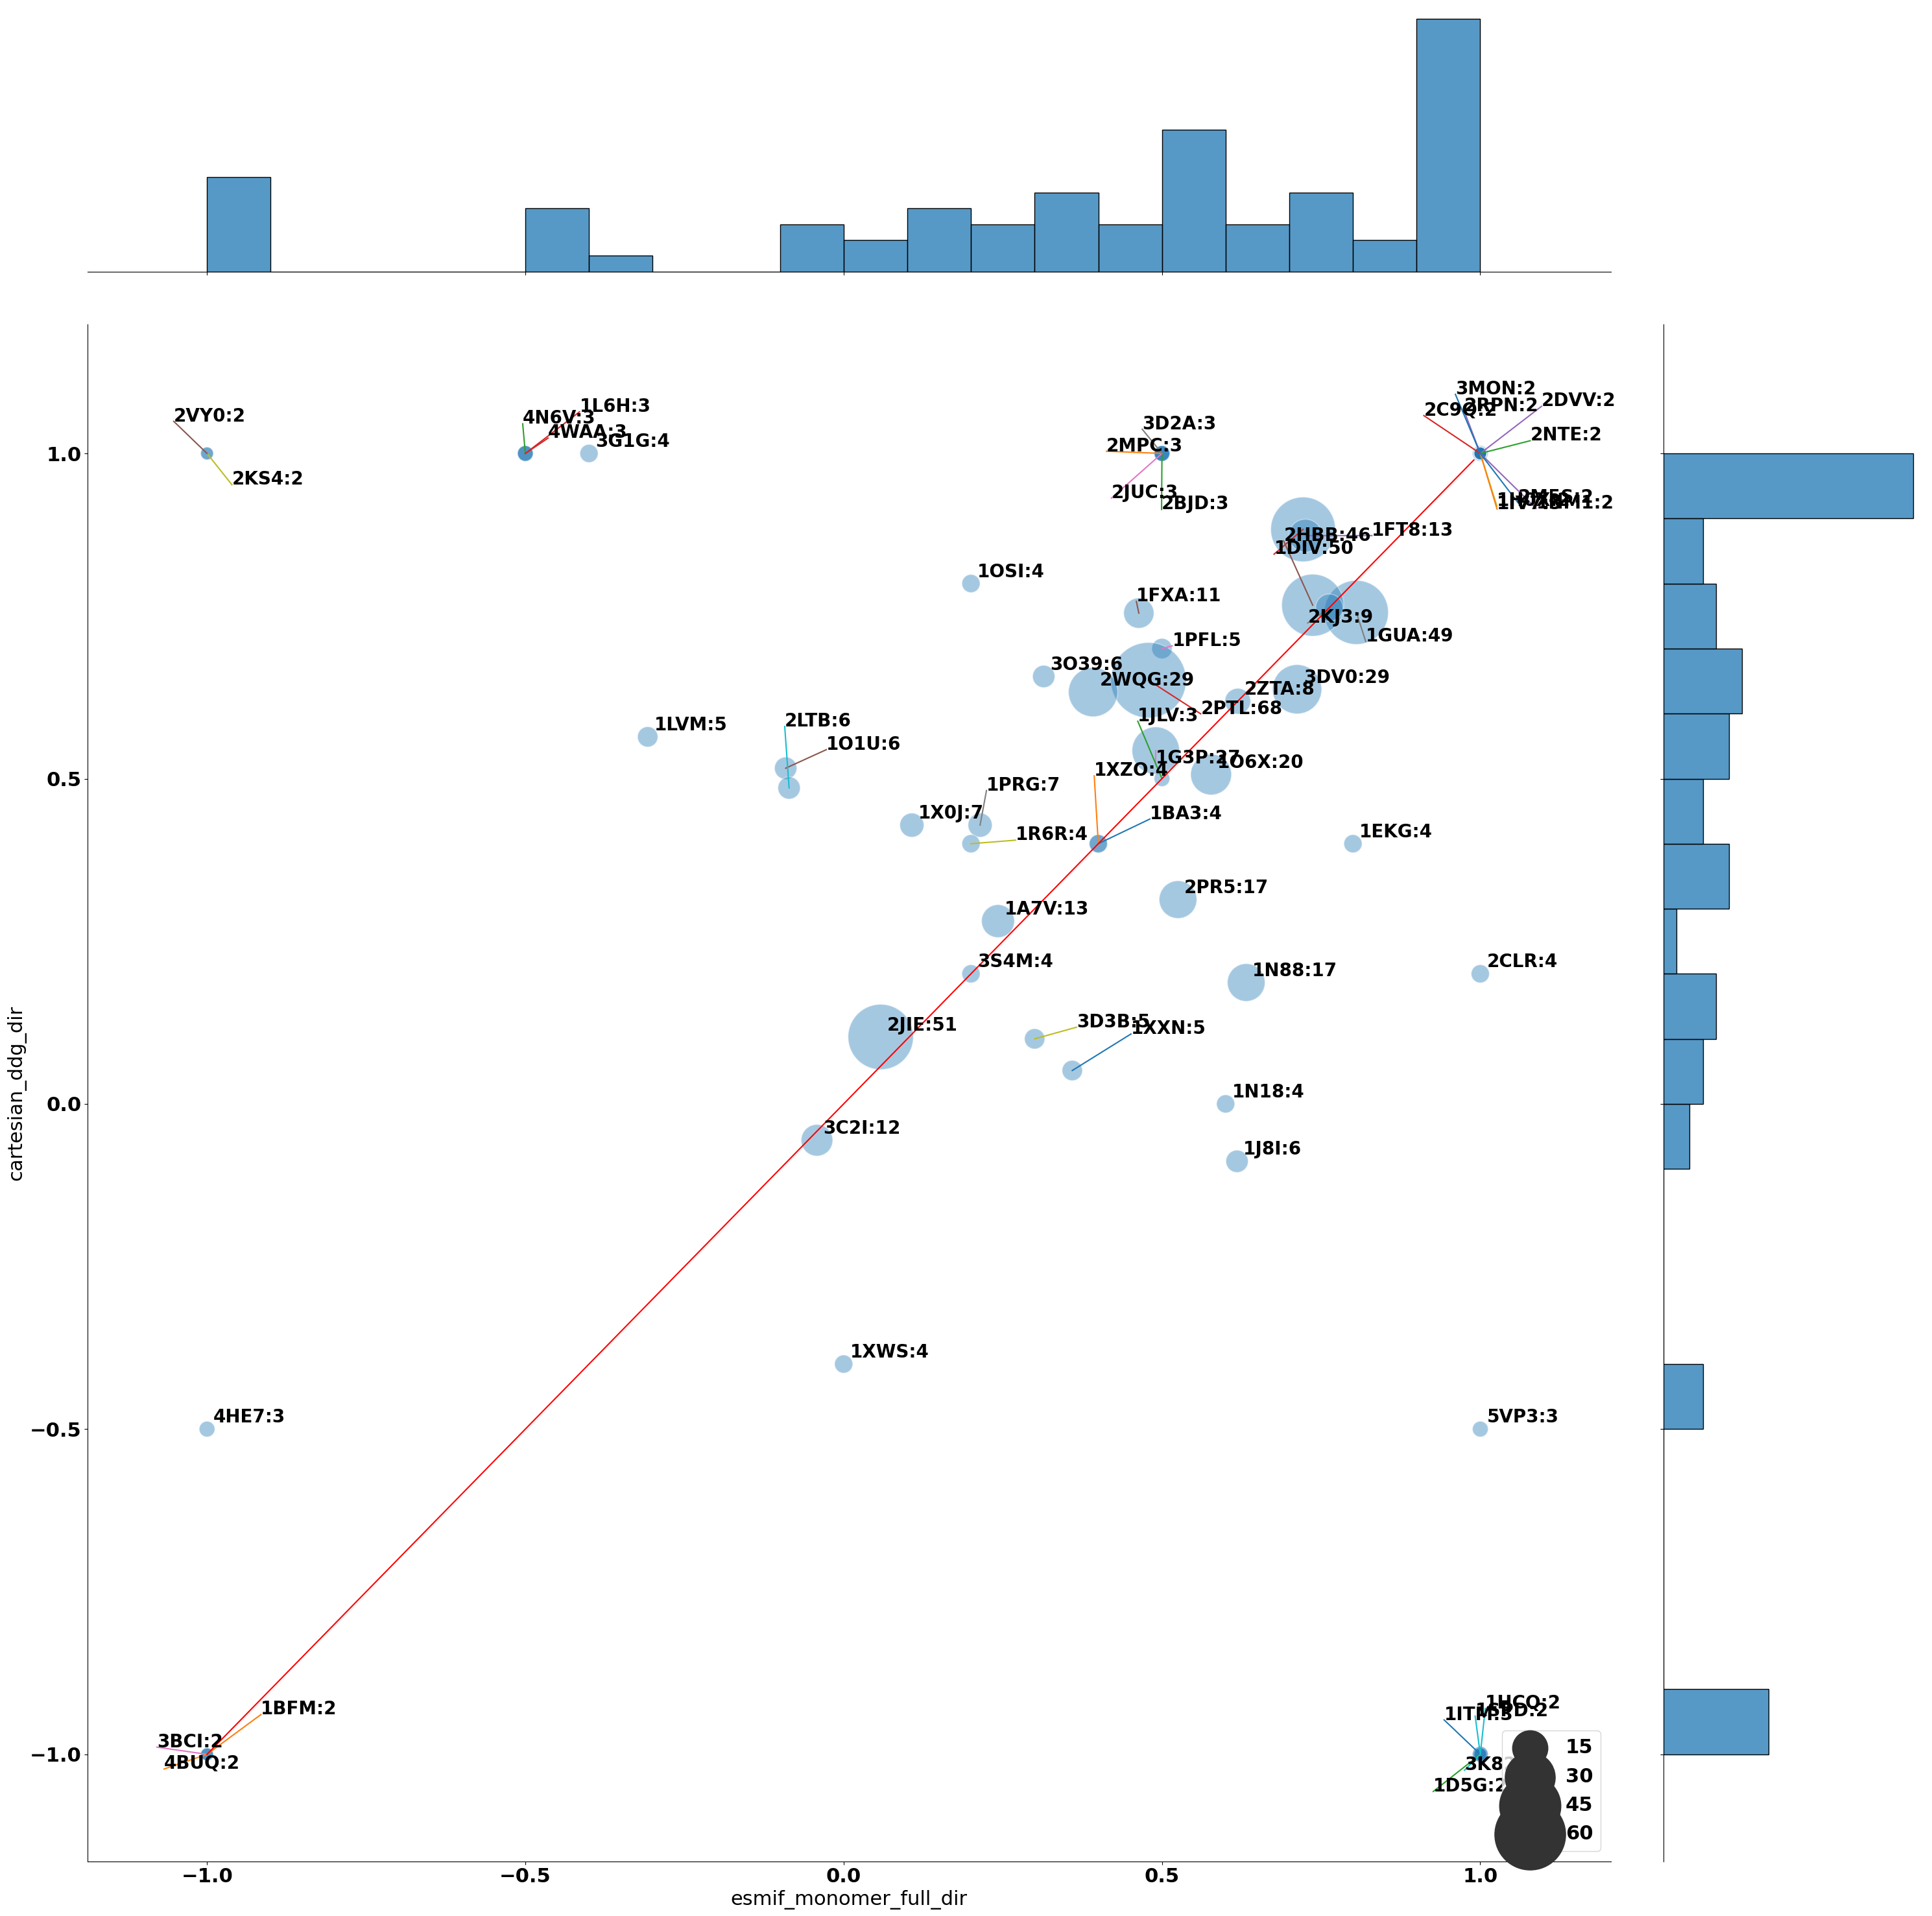

cartesian_ddg_dir  esmif_monomer_full_dir
n_total                    667.000000              667.000000
ungrouped_spearman           0.448400                0.367084
n_proteins                  66.000000               66.000000
avg_spearman                 0.393318                0.367105
weighted_spearman            0.450896                0.405830

In [141]:
score_1 = 'cartesian_ddg_dir'
score_2 = 'esmif_monomer_full_dir'
db_complete = db_preds.join(ddgs, how='left')
correlations(db_complete, score_1, score_name_2=score_2, min_obs=2, corr='spearman', plot=True, out=True, full=False)

In [108]:
#min_obs=2
#corrs = [correlations(dfm, col, min_obs=min_obs, corr='spearman', out=True, plot=False, group=True) for col in models + all_cols] #runtime=True
#d1 = pd.concat(corrs, axis=1)



n  \
direction model_type   model                                  class          
dir       evolutionary ACDC-NN-Seq_dir                               669.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           669.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           669.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             669.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           667.0   
...                                                                    ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        663.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        663.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        663.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        663.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        663.0   

                                                                       tp  \
direction model_type   model                                  class         
dir       evolutionary ACDC-NN-Seq_dir                               51.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           61.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           59.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             59.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           71.0   
...                                                                   ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        48.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        44.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        47.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        48.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        49.0   

                                                                       fp  \
direction model_type   model                                  class         
dir       evolutionary ACDC-NN-Seq_dir                               61.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           77.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           77.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             76.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           93.0   
...                                                                   ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        87.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        87.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        88.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        88.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        92.0   

                                                                        tn  \
direction model_type   model                                  class          
dir       evolutionary ACDC-NN-Seq_dir                               440.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.2           424.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 0.6           424.0   
                       ACDC-NN-Seq_dir + ACDC-NN_dir * 1             425.0   
                       ACDC-NN-Seq_dir + DDGun3D_dir * 0.2           406.0   
...                                                                    ...   
          structural   tranception_dir + mpnn_30_00_dir * 0.6        408.0   
                       tranception_dir + mpnn_30_02_dir * 0.2        408.0   
                       tranception_dir + mpnn_30_02_dir * 0.6        407.0   
                       tranception_dir + mpnn_30_03_dir * 0.2        407.0   
                       tranception_dir + mpnn_30_03_dir * 0.6        403.0   

                                       

index  n_total_ddG  \
1               DDGun_dir + esmif_monomer_dir * 0.6        642.0   
3              DDGun_dir + esmif_multimer_dir * 0.6        642.0   
25            DDGun3D_dir + esmif_monomer_dir * 0.6        667.0   
31               INPS3D_dir + esmif_monomer_dir * 1        667.0   
44        I-Mutant3.0_dir + esmif_monomer_dir * 0.6        667.0   
48           DDGun3D_dir + esmif_multimer_dir * 0.6        667.0   
57             INPS3D_dir + esmif_monomer_dir * 0.6        667.0   
65            PremPS_dir + esmif_multimer_dir * 0.2        666.0   
72             PremPS_dir + esmif_monomer_dir * 0.2        666.0   
86       esmif_monomer_dir + esm1v_median_dir * 0.2        669.0   
90           PopMusic_dir + esmif_monomer_dir * 0.6        666.0   
94                DDGun_dir + esmif_monomer_dir * 1        642.0   
97        esmif_monomer_dir + I-Mutant3.0_dir * 0.6        667.0   
98           INPS-Seq_dir + esmif_monomer_dir * 0.6        669.0   
102            INPS-Seq_dir + esmif_monomer_dir * 1        669.0   
105            esmif_monomer_dir + INPS3D_dir * 0.6        667.0   
106           ThermoNet_dir + esmif_monomer_dir * 1        669.0   
107           SOL_ACC_dir + esmif_monomer_dir * 0.2        666.0   
112          PopMusic_dir + esmif_monomer_dir * 0.2        666.0   
113      I-Mutant3.0_dir + esmif_multimer_dir * 0.6        667.0   
124       ACDC-NN-Seq_dir + esmif_monomer_dir * 0.6        669.0   
129           Dynamut_dir + esmif_monomer_dir * 0.6        669.0   
132             INPS3D_dir + esmif_multimer_dir * 1        667.0   
133             PopMusic_dir + mpnn_30_02_dir * 0.6        666.0   
134         ACDC-NN-Seq_dir + esmif_monomer_dir * 1        669.0   
137            MuPro_dir + esmif_multimer_dir * 0.6        669.0   
138              DDGun_dir + esmif_multimer_dir * 1        642.0   
139          esmif_monomer_dir + INPS-Seq_dir * 0.6        669.0   
143           INPS3D_dir + esmif_multimer_dir * 0.6        667.0   
144                  PopMusic_dir + mifst_dir * 0.2        666.0   
145            esmif_monomer_dir + PremPS_dir * 0.6        666.0   
149           MAESTRO_dir + esmif_monomer_dir * 0.6        669.0   
150      esmif_multimer_dir + I-Mutant3.0_dir * 0.6        667.0   
153          Dynamut_dir + esmif_multimer_dir * 0.6        669.0   
156              MuPro_dir + esmif_multimer_dir * 1        669.0   
158             SOL_ACC_dir + esmif_monomer_dir * 1        666.0   
159         INPS-Seq_dir + esmif_multimer_dir * 0.6        669.0   
160           esmif_monomer_dir + DDGun3D_dir * 0.6        667.0   
161           ACDC-NN_dir + esmif_monomer_dir * 0.2        669.0   
162          SOL_ACC_dir + esmif_multimer_dir * 0.2        666.0   
163         esmif_monomer_dir + ThermoNet_dir * 0.6        669.0   
167         PopMusic_dir + esmif_multimer_dir * 0.6        666.0   
169              PremPS_dir + monomer_ddg_dir * 0.2        605.0   
171      ACDC-NN-Seq_dir + esmif_multimer_dir * 0.6        669.0   
172           SOL_ACC_dir + esmif_monomer_dir * 0.6        666.0   
173  esmif_monomer_full_dir + tranception_dir * 0.6        663.0   
174            PremPS_dir + esmif_monomer_dir * 0.6        666.0   
175             INPS-Seq_dir + mpnn_30_02_dir * 0.6        669.0   
177               esmif_monomer_dir + SDM_dir * 0.6        669.0   
178           PremPS_dir + esmif_multimer_dir * 0.6        666.0   

     ungrouped_spearman_ddG  n_proteins_ddG  avg_spearman_ddG  \
1                  0.435928            65.0          0.473069   
3                  0.439269            65.0          0.469439   
25                 0.436368            66.0          0.419131   
31                 0.378720            66.0          0.447979   
44                 0.367666            66.0          0.433344   
48                 0.439964            66.0          0.430142   
57                 0.408902            66.0          0.421152   
65                 0.461127            66.0          0.40

In [18]:
db_complete = db_preds.join(ddgs, how='left')
#print(db_complete.columns.drop('code'))
dfs = pd.concat([correlations(db_complete, s1, min_obs=2, corr='spearman', plot=False, out=False) for s1 in db_complete.columns.drop(['code', 'ddG'])], axis=1)
#dfs = pd.concat([dfs, correlations(db_complete, 'cartesian_ddg', score_name_2='mpnn', min_obs=2, corr='spearman', plot=False, out=False).drop('mpnn', axis=1)], axis=1)
df_feats = db_feats[['code', 'multimer']].groupby('code').first()
df_out = df_feats.join(dfs, how='inner')
df_out.to_csv('~/OneDrive/s669_correlations.csv')
df_out

df_out#.loc[('1DIV', 50)].tail(40)

#dfs.sort_values('weighted_spearman', ascending=False)

multimer  ACDC-NN-Seq_dir  ACDC-NN-Seq_inv  ACDC-NN_dir  \
code obs                                                            
1A7V 13          1        -0.032943         0.032943     0.192838   
1BA3 4           1         0.400000        -0.400000     0.400000   
1DIV 50          2         0.795365        -0.795365     0.786515   
1EKG 4           1        -0.200000         0.200000     0.400000   
1FT8 13          1         0.703297        -0.703297     0.785714   
1FXA 11          1         0.467910        -0.467910     0.381818   
1G3P 27          1        -0.051186         0.051186     0.016494   
1GUA 49          2         0.720816        -0.720816     0.705612   
1ITM 3           1        -0.500000         0.500000    -0.500000   
1IV7 3           1         1.000000        -1.000000     1.000000   
1J8I 6           1        -0.559065         0.559065    -0.500216   
1JLV 3           2        -0.500000         0.500000     0.500000   
1L6H 3           1         1.000000        -1.000000     1.000000   
1LVM 5           3         0.153897        -0.153897     0.666886   
1N18 4           2        -0.400000         0.400000     0.400000   
1N88 17          1         0.397791        -0.397791     0.602825   
1O1U 6           1        -0.273230         0.273230    -0.273230   
1O6X 20          1         0.320542        -0.320542     0.297216   
1OSI 4           2         0.400000        -0.400000     0.400000   
1PFL 5           1         0.600000        -0.600000     0.800000   
1PRG 7           2        -0.126131         0.126131    -0.571429   
1R6R 4           2         0.000000         0.000000    -0.400000   
1X0J 7           2         0.071429        -0.071429    -0.107143   
1XWS 4           1         0.105409        -0.105409    -0.200000   
1XXN 5           1         0.820783        -0.820783     0.666886   
1XZO 4           1         0.316228        -0.316228     0.200000   
2BJD 3           1         0.500000        -0.500000     0.500000   
2CLR 4           3         0.800000        -0.800000     0.800000   
2HBB 46          1         0.722599        -0.722599     0.742260   
2JIE 51          1         0.209315        -0.209315     0.095566   
2JUC 3           1         0.500000        -0.500000     0.500000   
2KJ3 9           3         0.610257        -0.610257     0.695015   
2LTB 6           1         0.771429        -0.771429     0.714286   
2MPC 3           1         0.500000        -0.500000     0.500000   
2PR5 17          2        -0.028290         0.028290    -0.161963   
2PTL 68          1         0.609867        -0.609867     0.632391   
2WQG 29          1         0.181583        -0.181583     0.212089   
2ZTA 8           2         0.595238        -0.595238     0.523810   
3C2I 12          3         0.377622        -0.377622     0.321678   
3D2A 3           1        -0.866025         0.866025    -1.000000   
3D3B 5           2        -0.102598         0.102598    -0.200000   
3DV0 31          5         0.413257        -0.413257     0.432482   
3G1G 4           2         0.800000        -0.800000    -0.800000   
3O39 6           2         0.371429        -0.371429     0.428571   
3S4M 4           1        -0.600000         0.600000     0.000000   
4HE7 3           1        -1.000000         1.000000    -0.500000   
4N6V 3           1         0.500000        -0.500000     0.500000   
4WAA 3           2        -1.000000         1.000000    -0.500000   
5VP3 3           1         0.500000        -0.500000     0.500000   
3K82 3           1              NaN              NaN     1.000000   
3DV0 29          5              NaN              NaN          NaN   
1DIV 47          2              NaN              NaN          NaN   
2JIE 47          1              NaN              NaN          NaN   
1N88 12          1              NaN              NaN          NaN   
1OSI 3           2              NaN              NaN          NaN   
1FT8 12          1              NaN              NaN          NaN   

       

In [ ]:
'mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'
model1 = 'mif_dir'
model2 = 'esmif_multimer_dir'
model3 = 'esm1v_median_dir'
weight = 1
weight2 = 0.5
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'] = (db_preds[model1] - db_preds[model1].mean()) / db_preds[model1].std()
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'] += (db_preds[model2] - db_preds[model2].mean()) / db_preds[model2].std() * weight
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'] += (db_preds[model3] - db_preds[model3].mean()) / db_preds[model3].std() * weight2

db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'] = (db_preds['mif_inv'] - db_preds['mif_inv'].mean()) / db_preds['mif_inv'].std()
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'] += (db_preds['esmif_monomer_masked_inv'] - db_preds['esmif_monomer_masked_inv'].mean()) / db_preds['esmif_monomer_masked_inv'].std() * weight
db_preds['mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'] += (db_preds['esm1v_median_inv'] - db_preds['esm1v_median_inv'].mean()) / db_preds['esm1v_median_inv'].std() * weight2

db_preds
c1 = 'mif + esmif_multimer * 1 + esm1v_median * 0.5_dir'
c2 = 'mif + esmif_multimer * 1 + esm1v_median * 0.5_inv'

db_tmp = db_preds.copy()
#db_tmp['code'] = db_tmp.reset_index(level=1).index.str[:4]
#db_tmp = db_tmp.loc[db_tmp['code']=='2HBB']
sns.scatterplot(data=db_tmp, x=c1, y=c2, legend=False)

print('antisymmetry (should be close to -1)', antisymmetry(db_preds[c1], db_preds[c2]))
print('bias (should be close to 0)', bias(db_preds[c1], db_preds[c2]))

In [ ]:
db_stack = db_complete.drop('code', axis=1).reset_index(level=1, drop=True).copy(deep=True)
db_stack['ddG_dir'] = db_stack['ddG']
db_stack['ddG_inv'] = -db_stack['ddG']
#db_stack['uid_dir'] = db_stack['uid'] + '_dir'
#db_stack['uid_inv'] = db_stack['uid'] + '_inv'
db_stack = db_stack.drop(['ddG'], axis=1)
#db_stack = db_stack.set_index(['uid_dir', 'uid_inv'])

In [ ]:
db_stack = db_complete.drop('code', axis=1).reset_index(level=1, drop=True).copy(deep=True)
db_stack['ddG_dir'] = db_stack['ddG']
db_stack['ddG_inv'] = -db_stack['ddG']
db_stack = db_stack.drop(['ddG'], axis=1)
df = db_stack.melt(var_name='col', value_name='value', value_vars=db_stack.columns, ignore_index=False)
df = df.reset_index()
df['uid'] = df['uid'] + df['col'].str[-4:]
df = df.set_index('uid')
df['col'] = df['col'].str.extract(r'(.+)_(inv|dir)')[0]
df = df.pivot_table(index=df.index, columns='col', values='value')
df = df.fillna(0)
df.loc[df['ddG']>0, 'ddG']=1
df.loc[df['ddG']<=0, 'ddG']=-1
df.to_csv(os.path.join(path, '..', 's669_binarized_full.csv'))
df_train = df[['esmif_monomer_masked', 'esmif_monomer', 'mpnn', 'mif', 'mifst', 'tranception_retrieval', 'msa_transformer_median', 'esm1v_median', 'ddG']].copy(deep=True)
df_train

col            esmif_monomer_masked  esmif_monomer      mpnn       mif  \
uid                                                                      
1A0F_11A_dir              -2.426234      -3.788848 -1.730592 -4.844778   
1A0F_11A_inv               1.907257       2.373271  1.952918  5.241425   
1A7V_104H_dir             -7.840379      -7.725709 -3.801549 -7.811964   
1A7V_104H_inv              6.709040       7.363378  2.204143  5.643720   
1A7V_13H_dir              -2.774624      -2.694193 -1.023643 -2.775420   
...                             ...            ...       ...       ...   
5VP3_128G_inv             -0.264792       1.112414  3.175077 -3.155340   
5VP3_183T_dir              0.851279      -4.029168 -2.158462 -1.360012   
5VP3_183T_inv             -0.076972      -4.046058 -1.839730 -8.271081   
5VP3_39K_dir              -0.868768      -0.613143 -0.614777 -0.780378   
5VP3_39K_inv               0.813791       1.599584  0.617482  0.752555   

col               mifst  tranception_retrieval  msa_transformer_median  \
uid                                                                      
1A0F_11A_dir  -9.080012              -0.017637               -3.382510   
1A0F_11A_inv   9.144400               0.017637                3.382510   
1A7V_104H_dir -8.982984              -0.025138              -10.578852   
1A7V_104H_inv  8.753647               0.025138               10.578852   
1A7V_13H_dir  -5.796781              -0.030103               -5.768966   
...                 ...                    ...                     ...   
5VP3_128G_inv -1.522461               0.033658                0.305559   
5VP3_183T_dir -4.062951              -0.036415               -1.513407   
5VP3_183T_inv -3.206351               0.036415                1.513407   
5VP3_39K_dir  -0.601453              -0.035424               -0.722602   
5VP3_39K_inv   0.581376               0.035424                0.722602   

col            esm1v_median  ddG  
uid                               
1A0F_11A_dir      -4.153863 -1.0  
1A0F_11A_inv       4.153863  1.0  
1A7V_104H_dir     -7.322962 -1.0  
1A7V_104H_inv      7.322962  1.0  
1A7V_13H_dir      -5.358119 -1.0  
...                     ...  ...  
5VP3_128G_inv     -0.103448  1.0  
5VP3_183T_dir     -1.330562  1.0  
5VP3_183T_inv      1.330562 -1.0  
5VP3_39K_dir      -0.597213  1.0  
5VP3_39K_inv       0.597213 -1.0  

[1338 rows x 9 columns]

In [205]:
fp = pd.read_csv(os.path.join(path, '..', 'fireprot_preds.csv')).dropna(subset='ddG')
df_test = fp[['esmif_monomer_masked', 'esmif_monomer', 'mpnn', 'mif', 'mifst', 'tranception', 'msa_transformer_median', 'esm1v_median', 'ddG']].rename({'tranception': 'tranception_retrieval'}, axis=1)
df_test = df_test.fillna(0)
df_test['ddG'] = -df_test['ddG'] 
df_test.loc[df_test['ddG']>0, 'ddG']=1
df_test.loc[df_test['ddG']<=0, 'ddG']=-1
df_test

esmif_monomer_masked  esmif_monomer      mpnn       mif     mifst  \
1                -4.403102      -3.892285  2.124438  1.864486 -6.804817   
2                -6.528028      -6.444196  2.916263  1.119251 -7.803186   
3                -4.840798      -4.758171  0.961738 -0.854073 -5.416106   
4                -2.197042      -2.777323  1.001751  1.528646 -3.416625   
5                -3.648285      -3.119000  0.908481  0.348254 -5.095066   
...                    ...            ...       ...       ...       ...   
5857              0.331900       2.399654  0.708933  0.501244  1.537594   
5858             -2.062857      -2.255044 -0.660205 -2.084224 -2.458249   
5859             -0.526189      -2.091975 -1.778232 -0.939917  0.199211   
6264              1.093352       1.259959  0.908896  1.211098  1.239150   
6265             -0.981396       0.482705  2.114213 -0.412503 -3.608728   

      tranception_retrieval  msa_transformer_median  esm1v_median  ddG  
1                 -0.109843               -9.881346    -13.370914 -1.0  
2                 -0.059805              -10.005238    -11.998134  1.0  
3                 -0.032687               -7.933827     -6.640478  1.0  
4                 -0.039248               -6.085909     -7.086007  1.0  
5                 -0.075966               -9.434349     -7.950257 -1.0  
...                     ...                     ...           ...  ...  
5857              -0.051212               -6.589225     -1.168017  1.0  
5858              -0.145734               -7.208587     -2.941263 -1.0  
5859               0.001114                0.787610      0.422119  1.0  
6264              -0.001946               -2.237000     -1.146301  1.0  
6265              -0.004162               -2.819138     -1.658356  1.0  

[5021 rows x 9 columns]

In [206]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV, Perceptron, RidgeClassifierCV, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import BernoulliNB

#rf = RandomForestClassifier(min_samples_split=100, min_samples_leaf=10, n_estimators=100)
rf = LogisticRegressionCV()
#rf = HistGradientBoostingClassifier()
rf.fit(df_train.drop('ddG', axis=1), df_train['ddG'])
predictions = rf.predict(df_test.drop('ddG', axis=1))
truth = df_test['ddG'].to_numpy()

#pd.DataFrame(index=df_test.columns.drop('ddG'), data=rf.feature_importances_)

In [207]:
fp['LogReg'] = predictions

In [208]:
fp.to_csv(os.path.join(path, '..', 'fireprot_preds_logreg.csv'))

In [49]:
import requests
code = '1TUP'
if code in ['1AON', '1GUA', '1GLU', '2CLR', '3MON']:
    entity = 2
elif code in ['1HCQ', '1TUP', '3DV0']:
    entity = 3
else:
    entity = 1
print(entity)
req = f'https://www.ebi.ac.uk/pdbe/graph-api/pdbe_pages/interfaces/{code.lower()}/{entity}'
r = requests.get(req).text.replace('true','True').replace('false','False')
r = eval(r)
r
#df = pd.DataFrame(r[code.lower()]['data'][0]['residues'])
#df

3


{'1tup': {'sequence': 'SSSVPSQKTYQGSYGFRLGFLHSGTAKSVTCTYSPALNKMFCQLAKTCPVQLWVDSTPPPGTRVRAMAIYKQSQHMTEVVRRCPHHERCSDSDGLAPPQHLIRVEGNLRVEYLDDRNTFRHSVVVPYEPPEVGSDCTTIHYNYMCNSSCMGGMNRRPILTIITLEDSSGNLLGRNSFEVRVCACPGRDRRTEEENLRKKGEPHHELPPGSTKRALPNNT',
  'length': 219,
  'dataType': 'INTERFACE RESIDUES',
  'data': [{'dataType': 'UniProt',
    'accession': 'P04637',
    'name': 'Cellular tumor antigen p53',
    'additionalData': {'bestChainId': 'C', 'entityId': 3},
    'residues': [{'startIndex': 1,
      'endIndex': 2,
      'startCode': 'SER',
      'endCode': 'SER',
      'indexType': 'PDB'},
     {'startIndex': 45,
      'endIndex': 45,
      'startCode': 'ALA',
      'endCode': 'ALA',
      'indexType': 'PDB'},
     {'startIndex': 47,
      'endIndex': 47,
      'startCode': 'THR',
      'endCode': 'THR',
      'indexType': 'PDB'},
     {'startIndex': 78,
      'endIndex': 79,
      'startCode': 'GLU',
      'endCode': 'VAL',
      'indexType': 'PDB'},
     {'startIndex': 81,
      'endInd

In [36]:
r[code.lower()]['sequence']

'EDKITVHFINRDGETLTTKGKIGDSLLDVVVQNNLDIDGFGACEGTLACSTCHLIFEQHIFEKLEAITDEENDMLDLAYGLTDRSRLGCQICLTKAMDNMTVRVP'

In [ ]:
path2 = '../../s669'

elaspic = pd.DataFrame(index=db.reset_index(level=0)['uid'], columns=['elaspic2_dir'])

item = 'elaspic2'

for (code, chain), _ in db.groupby(['code', 'chain']):
    try:
        new = pd.read_csv(f'{path2}/{code}/{code}_{item}_scores.csv')

        if item in ['protbert', 'proteinsolver', 'elaspic2']:
            new = new.drop('Unnamed: 0', axis=1)

        elaspic.loc[new['uid'], 'elaspic2_dir'] = list(new['el2core'].astype(float))
    except Exception as e:
        print(code)
        print(item)
        print(e)

db_preds = db_preds.reset_index(level=1)
db_preds = db_preds.join(elaspic, how='left')
db_preds['elaspic2_dir'] = -db_preds['elaspic2_dir'].astype(float)
db_preds = db_preds.reset_index().set_index(['uid', 'uid2']).astype(float)
db_preds